# K-Fold CV for Boosting Methods Using SKLearn 

In [1]:
#Importing required libraries
from sklearn.datasets import load_breast_cancer
import pandas as pd
import numpy as np

from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm
import wfdb

from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from numpy import mean
from numpy import absolute
from numpy import sqrt
import pandas as pd
import random

In [2]:
import xgboost as xgb
from sklearn import metrics
from lightgbm import LGBMClassifier

import lightgbm
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.dpi'] = 70 #display 70 dpi in Jupyter Notebook, may consider100 dpi 
plt.rcParams['savefig.dpi'] = 300 #define 300 dpi for saving figures

import seaborn as sns
## here are some settings 
sns.set_style('whitegrid')
sns.set(rc={"figure.dpi":70, 'savefig.dpi':300}) #defining dpi setting
sns.set_context('notebook')
sns.set_style("ticks")
from IPython.display import set_matplotlib_formats

### To load sklearn dataset
sklearn.datasets.load_breast_cancer(*, return_X_y=False, as_frame=False)[source]¶

Load and return the breast cancer wisconsin dataset (classification).

In [4]:
#data = load_breast_cancer(as_frame = True); 
#df = data.frame; 
#print(df.shape)
# In this block use the code we looked at on 6/30 as a reference to save our rr-intervals as a .
rlist = []
records = 'mit-bih-raw\RECORDS' # Replace the _______ with the name of the records file in your MIT-BIH data folder
with open(records) as rfile: #Then we open the file 
                             #The 'with' command only opens the file while we are in it. Automatically closes the file when we're not
    for record in rfile:  # Then we iterate through the lines in the file
        record = record[0:len(record)-1] # Remove any erronious new line characters at the end ('\n')
        rlist.append(record) # Then build an array with it
        

###### Step 1: Initialize all Arrays
             # Below, replace all of the ___ with the command that declares an array/list
             # hint: https://stackoverflow.com/questions/1514553/how-to-declare-an-array-in-python
samples = [] # will house the samples of all subjects
good_list = [] # will list the names of the subjects we successfully extracted
bad_list = [] # will house the names of the subjects we failed to extract
qrs = [] # will house the indices of R-Peaks for all subjects
atr_label = [] # will house the labels for each rhythm annotation for all subjects
atr_locs = [] # will house the locations corresponding to the rhythm annotation labels


###### Step 2: Extract Information
for x in tqdm(rlist): #this will iterate through te records that we found above
  
    try: # A try statement will run the except statement if for some reason the try commands fail
         # In this case I use the try statement because one of the subjects has no signal data causing failure
         # I then use bad_list and good_list so that all of the indices in rlist match with the arrays we initialized in Step 1, above
        ######################################################
            # Below find the wfdb function that will return the information that is described below 
        # Then replace _____ with the correct function call
        samp = wfdb.rdsamp('mit-bih-raw/'+x) # wfdb._____(file_location) will read the signal & header data and return a 2 value array
            # samp[0] - the signal data is the raw reading from the ecg. Each value is a sample taken.
            # samp[1] - the header data includes things about the signal data such as:
              # samples per section, denoted 'fs'
              # number of signals, denoted 'n_sig'
            
        ######################################################
        samples.append(samp) #add it to our array for all subject
            #What is our file extension that has the annotation we want? Find it here and replace _____ with it 
            #hint: READ THE VARIABLE NAMES!!!!
        qrs_tmp = wfdb.rdann('mit-bih-raw/'+x, extension='qrs') #extract the QRS Info
        qrs_locs = np.array(qrs_tmp.sample, dtype='int') #Get just the loccation of R-Peaks from the QRS Info
        qrs.append(qrs_locs) # Add to our array for all subjects
        
            #Do the same thing here
        atr = wfdb.rdann('mit-bih-raw/'+x,extension='atr') #extract the atr info which stores the rhythm type(s) over the whole signal
        atr_label.append(atr.aux_note) # aux_note stores the type of rhythm - main two are '(N' for normal and '(AFIB' for AFIB
        atr_locs.append(np.append(atr.sample, len(samp[0]))) #I add the length of the whole sample to the end for better visualization later
        
        good_list.append(x) # when all extraction is successful append the record name to good_list
    except Exception as exep:
        print(exep) # Alert the user of an exception
        bad_list.append(x) # add to the bad list

        

  0%|          | 0/25 [00:00<?, ?it/s]

sampto must be greater than sampfrom
sampto must be greater than sampfrom


100%|██████████| 25/25 [00:21<00:00,  1.17it/s]


In [5]:
features_df_list = []
for subject in good_list:
    data = pd.read_csv(f'subject-features-dataframes/subject{subject}.csv')
    data = data.assign(Subject = subject)
    #print(data)
    features_df_list.append(data)
#features_maindf = pd.concat(features_df_list, ignore_index = True)

In [6]:
#df.head(5)
# df.info()
# df.describe()
#features_df_list[0]
counter = 0
testing_arr = []
training_arr = []
for subject in features_df_list:
    if counter != 22:
        training_arr.append(subject)
    else:
        testing_arr.append(subject)
    counter += 1
    
print(len(training_arr))

22


In [7]:
features_maindf = pd.concat(features_df_list, ignore_index = True)
print(features_maindf.columns)

Index(['Unnamed: 0', 'AppEn', 'SampEn', 'CosEn', 'RangeEn', 'FuzzyEn',
       'EntropyAF', 'PermEn', 'BubbleEn', 'MultiscaleEn', 'Volatility',
       'Rhythm', 'Subject'],
      dtype='object')


C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.618356	valid_0's binary_logloss: 0.571408
[2]	training's binary_logloss: 0.55755	valid_0's binary_logloss: 0.521635
[3]	training's binary_logloss: 0.505937	valid_0's binary_logloss: 0.479841
[4]	training's binary_logloss: 0.461077	valid_0's binary_logloss: 0.444658
[5]	training's binary_logloss: 0.422435	valid_0's binary_logloss: 0.413974
[6]	training's binary_logloss: 0.38893	valid_0's binary_logloss: 0.388499
[7]	training's binary_logloss: 0.359628	valid_0's binary_logloss: 0.365992
[8]	training's binary_logloss: 0.333592	valid_0's binary_logloss: 0.347248
[9]	training's binary_logloss: 0.310288	valid_0's binary_logloss: 0.331451
[10]	training's binary_logloss: 0.289955	valid_0's binary_logloss: 0.316704
[11]	training's binary_logloss: 0.271785	valid_0's binary_logloss: 0.30466
[12]	training's binary_logloss: 0.255501	valid_0's binary_logloss: 0.293693
[13]	training's binary_logloss: 0.240837	valid_0's binary_logloss: 0.283784
[14]	training's binary_l

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.618356	valid_0's binary_logloss: 0.571408
[2]	training's binary_logloss: 0.55755	valid_0's binary_logloss: 0.521635
[3]	training's binary_logloss: 0.505937	valid_0's binary_logloss: 0.479841
[4]	training's binary_logloss: 0.461077	valid_0's binary_logloss: 0.444658
[5]	training's binary_logloss: 0.422435	valid_0's binary_logloss: 0.413974
[6]	training's binary_logloss: 0.38893	valid_0's binary_logloss: 0.388499
[7]	training's binary_logloss: 0.359628	valid_0's binary_logloss: 0.365992
[8]	training's binary_logloss: 0.333592	valid_0's binary_logloss: 0.347248
[9]	training's binary_logloss: 0.310288	valid_0's binary_logloss: 0.331451
[10]	training's binary_logloss: 0.289955	valid_0's binary_logloss: 0.316704
[11]	training's binary_logloss: 0.271785	valid_0's binary_logloss: 0.30466
[12]	training's binary_logloss: 0.255501	valid_0's binary_logloss: 0.293693
[13]	training's binary_logloss: 0.240837	valid_0's binary_logloss: 0.283784
[14]	training's binary_l

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.618031	valid_0's binary_logloss: 0.587241
[2]	training's binary_logloss: 0.557826	valid_0's binary_logloss: 0.529984
[3]	training's binary_logloss: 0.506602	valid_0's binary_logloss: 0.481112
[4]	training's binary_logloss: 0.462222	valid_0's binary_logloss: 0.439001
[5]	training's binary_logloss: 0.423927	valid_0's binary_logloss: 0.403011
[6]	training's binary_logloss: 0.390808	valid_0's binary_logloss: 0.372501
[7]	training's binary_logloss: 0.361402	valid_0's binary_logloss: 0.344989
[8]	training's binary_logloss: 0.335528	valid_0's binary_logloss: 0.321032
[9]	training's binary_logloss: 0.312662	valid_0's binary_logloss: 0.299857
[10]	training's binary_logloss: 0.292288	valid_0's binary_logloss: 0.281156
[11]	training's binary_logloss: 0.274419	valid_0's binary_logloss: 0.264642
[12]	training's binary_logloss: 0.258274	valid_0's binary_logloss: 0.249967
[13]	training's binary_logloss: 0.243762	valid_0's binary_logloss: 0.237395
[14]	training's binar

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.618031	valid_0's binary_logloss: 0.587241
[2]	training's binary_logloss: 0.557826	valid_0's binary_logloss: 0.529984
[3]	training's binary_logloss: 0.506602	valid_0's binary_logloss: 0.481112
[4]	training's binary_logloss: 0.462222	valid_0's binary_logloss: 0.439001
[5]	training's binary_logloss: 0.423927	valid_0's binary_logloss: 0.403011
[6]	training's binary_logloss: 0.390808	valid_0's binary_logloss: 0.372501
[7]	training's binary_logloss: 0.361402	valid_0's binary_logloss: 0.344989
[8]	training's binary_logloss: 0.335528	valid_0's binary_logloss: 0.321032
[9]	training's binary_logloss: 0.312662	valid_0's binary_logloss: 0.299857
[10]	training's binary_logloss: 0.292288	valid_0's binary_logloss: 0.281156
[11]	training's binary_logloss: 0.274419	valid_0's binary_logloss: 0.264642
[12]	training's binary_logloss: 0.258274	valid_0's binary_logloss: 0.249967
[13]	training's binary_logloss: 0.243762	valid_0's binary_logloss: 0.237395
[14]	training's binar

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.618971	valid_0's binary_logloss: 0.555954
[2]	training's binary_logloss: 0.558959	valid_0's binary_logloss: 0.494263
[3]	training's binary_logloss: 0.507991	valid_0's binary_logloss: 0.440917
[4]	training's binary_logloss: 0.464155	valid_0's binary_logloss: 0.395268
[5]	training's binary_logloss: 0.425893	valid_0's binary_logloss: 0.355017
[6]	training's binary_logloss: 0.392805	valid_0's binary_logloss: 0.319867
[7]	training's binary_logloss: 0.363692	valid_0's binary_logloss: 0.288908
[8]	training's binary_logloss: 0.338193	valid_0's binary_logloss: 0.261883
[9]	training's binary_logloss: 0.315528	valid_0's binary_logloss: 0.237569
[10]	training's binary_logloss: 0.295324	valid_0's binary_logloss: 0.216125
[11]	training's binary_logloss: 0.277517	valid_0's binary_logloss: 0.196706
[12]	training's binary_logloss: 0.26127	valid_0's binary_logloss: 0.179225
[13]	training's binary_logloss: 0.247062	valid_0's binary_logloss: 0.163591
[14]	training's binary

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.618971	valid_0's binary_logloss: 0.555954
[2]	training's binary_logloss: 0.558959	valid_0's binary_logloss: 0.494263
[3]	training's binary_logloss: 0.507991	valid_0's binary_logloss: 0.440917
[4]	training's binary_logloss: 0.464155	valid_0's binary_logloss: 0.395268
[5]	training's binary_logloss: 0.425893	valid_0's binary_logloss: 0.355017
[6]	training's binary_logloss: 0.392805	valid_0's binary_logloss: 0.319867
[7]	training's binary_logloss: 0.363692	valid_0's binary_logloss: 0.288908
[8]	training's binary_logloss: 0.338193	valid_0's binary_logloss: 0.261883
[9]	training's binary_logloss: 0.315528	valid_0's binary_logloss: 0.237569
[10]	training's binary_logloss: 0.295324	valid_0's binary_logloss: 0.216125
[11]	training's binary_logloss: 0.277517	valid_0's binary_logloss: 0.196706
[12]	training's binary_logloss: 0.26127	valid_0's binary_logloss: 0.179225
[13]	training's binary_logloss: 0.247062	valid_0's binary_logloss: 0.163591
[14]	training's binary

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.617806	valid_0's binary_logloss: 0.582015
[2]	training's binary_logloss: 0.55692	valid_0's binary_logloss: 0.538577
[3]	training's binary_logloss: 0.505198	valid_0's binary_logloss: 0.500806
[4]	training's binary_logloss: 0.461029	valid_0's binary_logloss: 0.468758
[5]	training's binary_logloss: 0.422621	valid_0's binary_logloss: 0.44201
[6]	training's binary_logloss: 0.389259	valid_0's binary_logloss: 0.418793
[7]	training's binary_logloss: 0.359896	valid_0's binary_logloss: 0.39805
[8]	training's binary_logloss: 0.334028	valid_0's binary_logloss: 0.379569
[9]	training's binary_logloss: 0.31119	valid_0's binary_logloss: 0.363359
[10]	training's binary_logloss: 0.290954	valid_0's binary_logloss: 0.347904
[11]	training's binary_logloss: 0.27288	valid_0's binary_logloss: 0.3349
[12]	training's binary_logloss: 0.256822	valid_0's binary_logloss: 0.324482
[13]	training's binary_logloss: 0.242465	valid_0's binary_logloss: 0.313196
[14]	training's binary_loglo

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.617806	valid_0's binary_logloss: 0.582015
[2]	training's binary_logloss: 0.55692	valid_0's binary_logloss: 0.538577
[3]	training's binary_logloss: 0.505198	valid_0's binary_logloss: 0.500806
[4]	training's binary_logloss: 0.461029	valid_0's binary_logloss: 0.468758
[5]	training's binary_logloss: 0.422621	valid_0's binary_logloss: 0.44201
[6]	training's binary_logloss: 0.389259	valid_0's binary_logloss: 0.418793
[7]	training's binary_logloss: 0.359896	valid_0's binary_logloss: 0.39805
[8]	training's binary_logloss: 0.334028	valid_0's binary_logloss: 0.379569
[9]	training's binary_logloss: 0.31119	valid_0's binary_logloss: 0.363359
[10]	training's binary_logloss: 0.290954	valid_0's binary_logloss: 0.347904
[11]	training's binary_logloss: 0.27288	valid_0's binary_logloss: 0.3349
[12]	training's binary_logloss: 0.256822	valid_0's binary_logloss: 0.324482
[13]	training's binary_logloss: 0.242465	valid_0's binary_logloss: 0.313196
[14]	training's binary_loglo

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.61445	valid_0's binary_logloss: 0.645708
[2]	training's binary_logloss: 0.55478	valid_0's binary_logloss: 0.572508
[3]	training's binary_logloss: 0.504202	valid_0's binary_logloss: 0.510262
[4]	training's binary_logloss: 0.460493	valid_0's binary_logloss: 0.45734
[5]	training's binary_logloss: 0.422878	valid_0's binary_logloss: 0.411441
[6]	training's binary_logloss: 0.389921	valid_0's binary_logloss: 0.371323
[7]	training's binary_logloss: 0.361302	valid_0's binary_logloss: 0.336232
[8]	training's binary_logloss: 0.335705	valid_0's binary_logloss: 0.305397
[9]	training's binary_logloss: 0.313508	valid_0's binary_logloss: 0.278328
[10]	training's binary_logloss: 0.293543	valid_0's binary_logloss: 0.25383
[11]	training's binary_logloss: 0.275866	valid_0's binary_logloss: 0.232286
[12]	training's binary_logloss: 0.259752	valid_0's binary_logloss: 0.212982
[13]	training's binary_logloss: 0.245542	valid_0's binary_logloss: 0.195566
[14]	training's binary_lo

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.61445	valid_0's binary_logloss: 0.645708
[2]	training's binary_logloss: 0.55478	valid_0's binary_logloss: 0.572508
[3]	training's binary_logloss: 0.504202	valid_0's binary_logloss: 0.510262
[4]	training's binary_logloss: 0.460493	valid_0's binary_logloss: 0.45734
[5]	training's binary_logloss: 0.422878	valid_0's binary_logloss: 0.411441
[6]	training's binary_logloss: 0.389921	valid_0's binary_logloss: 0.371323
[7]	training's binary_logloss: 0.361302	valid_0's binary_logloss: 0.336232
[8]	training's binary_logloss: 0.335705	valid_0's binary_logloss: 0.305397
[9]	training's binary_logloss: 0.313508	valid_0's binary_logloss: 0.278328
[10]	training's binary_logloss: 0.293543	valid_0's binary_logloss: 0.25383
[11]	training's binary_logloss: 0.275866	valid_0's binary_logloss: 0.232286
[12]	training's binary_logloss: 0.259752	valid_0's binary_logloss: 0.212982
[13]	training's binary_logloss: 0.245542	valid_0's binary_logloss: 0.195566
[14]	training's binary_lo

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.619273	valid_0's binary_logloss: 0.586657
[2]	training's binary_logloss: 0.558414	valid_0's binary_logloss: 0.529604
[3]	training's binary_logloss: 0.506881	valid_0's binary_logloss: 0.481345
[4]	training's binary_logloss: 0.462765	valid_0's binary_logloss: 0.439885
[5]	training's binary_logloss: 0.424584	valid_0's binary_logloss: 0.40474
[6]	training's binary_logloss: 0.391336	valid_0's binary_logloss: 0.373663
[7]	training's binary_logloss: 0.362068	valid_0's binary_logloss: 0.346935
[8]	training's binary_logloss: 0.33646	valid_0's binary_logloss: 0.323364
[9]	training's binary_logloss: 0.313695	valid_0's binary_logloss: 0.302781
[10]	training's binary_logloss: 0.293503	valid_0's binary_logloss: 0.284574
[11]	training's binary_logloss: 0.275447	valid_0's binary_logloss: 0.268775
[12]	training's binary_logloss: 0.259284	valid_0's binary_logloss: 0.259389
[13]	training's binary_logloss: 0.244673	valid_0's binary_logloss: 0.247979
[14]	training's binary_

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.619273	valid_0's binary_logloss: 0.586657
[2]	training's binary_logloss: 0.558414	valid_0's binary_logloss: 0.529604
[3]	training's binary_logloss: 0.506897	valid_0's binary_logloss: 0.481483
[4]	training's binary_logloss: 0.462777	valid_0's binary_logloss: 0.44004
[5]	training's binary_logloss: 0.424702	valid_0's binary_logloss: 0.404665
[6]	training's binary_logloss: 0.391342	valid_0's binary_logloss: 0.373748
[7]	training's binary_logloss: 0.362165	valid_0's binary_logloss: 0.347002
[8]	training's binary_logloss: 0.336533	valid_0's binary_logloss: 0.322976
[9]	training's binary_logloss: 0.313644	valid_0's binary_logloss: 0.301902
[10]	training's binary_logloss: 0.293652	valid_0's binary_logloss: 0.284969
[11]	training's binary_logloss: 0.275575	valid_0's binary_logloss: 0.269106
[12]	training's binary_logloss: 0.259482	valid_0's binary_logloss: 0.259731
[13]	training's binary_logloss: 0.244874	valid_0's binary_logloss: 0.248147
[14]	training's binary

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.611183	valid_0's binary_logloss: 0.704597
[2]	training's binary_logloss: 0.550091	valid_0's binary_logloss: 0.654718
[3]	training's binary_logloss: 0.498489	valid_0's binary_logloss: 0.612037
[4]	training's binary_logloss: 0.454267	valid_0's binary_logloss: 0.578621
[5]	training's binary_logloss: 0.415761	valid_0's binary_logloss: 0.548785
[6]	training's binary_logloss: 0.382235	valid_0's binary_logloss: 0.523573
[7]	training's binary_logloss: 0.353008	valid_0's binary_logloss: 0.501463
[8]	training's binary_logloss: 0.326816	valid_0's binary_logloss: 0.484982
[9]	training's binary_logloss: 0.303896	valid_0's binary_logloss: 0.472314
[10]	training's binary_logloss: 0.283364	valid_0's binary_logloss: 0.459396
[11]	training's binary_logloss: 0.26519	valid_0's binary_logloss: 0.450129
[12]	training's binary_logloss: 0.248967	valid_0's binary_logloss: 0.439502
[13]	training's binary_logloss: 0.234426	valid_0's binary_logloss: 0.432819
[14]	training's binary

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.611158	valid_0's binary_logloss: 0.704557
[2]	training's binary_logloss: 0.550056	valid_0's binary_logloss: 0.654679
[3]	training's binary_logloss: 0.498458	valid_0's binary_logloss: 0.611978
[4]	training's binary_logloss: 0.454251	valid_0's binary_logloss: 0.578231
[5]	training's binary_logloss: 0.415863	valid_0's binary_logloss: 0.547121
[6]	training's binary_logloss: 0.382357	valid_0's binary_logloss: 0.522196
[7]	training's binary_logloss: 0.353078	valid_0's binary_logloss: 0.500826
[8]	training's binary_logloss: 0.326855	valid_0's binary_logloss: 0.48349
[9]	training's binary_logloss: 0.303885	valid_0's binary_logloss: 0.470271
[10]	training's binary_logloss: 0.283444	valid_0's binary_logloss: 0.4589
[11]	training's binary_logloss: 0.265179	valid_0's binary_logloss: 0.447636
[12]	training's binary_logloss: 0.24878	valid_0's binary_logloss: 0.440637
[13]	training's binary_logloss: 0.234318	valid_0's binary_logloss: 0.433229
[14]	training's binary_lo

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.618809	valid_0's binary_logloss: 0.552484
[2]	training's binary_logloss: 0.558743	valid_0's binary_logloss: 0.490586
[3]	training's binary_logloss: 0.507786	valid_0's binary_logloss: 0.437714
[4]	training's binary_logloss: 0.463908	valid_0's binary_logloss: 0.392085
[5]	training's binary_logloss: 0.425898	valid_0's binary_logloss: 0.35257
[6]	training's binary_logloss: 0.392658	valid_0's binary_logloss: 0.317586
[7]	training's binary_logloss: 0.36369	valid_0's binary_logloss: 0.286806
[8]	training's binary_logloss: 0.338021	valid_0's binary_logloss: 0.259678
[9]	training's binary_logloss: 0.315391	valid_0's binary_logloss: 0.235393
[10]	training's binary_logloss: 0.295452	valid_0's binary_logloss: 0.213807
[11]	training's binary_logloss: 0.277357	valid_0's binary_logloss: 0.194438
[12]	training's binary_logloss: 0.261306	valid_0's binary_logloss: 0.177348
[13]	training's binary_logloss: 0.246873	valid_0's binary_logloss: 0.161702
[14]	training's binary_

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.618809	valid_0's binary_logloss: 0.552484
[2]	training's binary_logloss: 0.558743	valid_0's binary_logloss: 0.490586
[3]	training's binary_logloss: 0.507786	valid_0's binary_logloss: 0.437714
[4]	training's binary_logloss: 0.463908	valid_0's binary_logloss: 0.392085
[5]	training's binary_logloss: 0.425898	valid_0's binary_logloss: 0.35257
[6]	training's binary_logloss: 0.392658	valid_0's binary_logloss: 0.317586
[7]	training's binary_logloss: 0.36369	valid_0's binary_logloss: 0.286806
[8]	training's binary_logloss: 0.338021	valid_0's binary_logloss: 0.259678
[9]	training's binary_logloss: 0.315391	valid_0's binary_logloss: 0.235393
[10]	training's binary_logloss: 0.295452	valid_0's binary_logloss: 0.213807
[11]	training's binary_logloss: 0.277357	valid_0's binary_logloss: 0.194438
[12]	training's binary_logloss: 0.261306	valid_0's binary_logloss: 0.177348
[13]	training's binary_logloss: 0.246873	valid_0's binary_logloss: 0.161702
[14]	training's binary_

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.61331	valid_0's binary_logloss: 0.666351
[2]	training's binary_logloss: 0.553059	valid_0's binary_logloss: 0.602082
[3]	training's binary_logloss: 0.502024	valid_0's binary_logloss: 0.547852
[4]	training's binary_logloss: 0.458035	valid_0's binary_logloss: 0.502356
[5]	training's binary_logloss: 0.419923	valid_0's binary_logloss: 0.462547
[6]	training's binary_logloss: 0.386748	valid_0's binary_logloss: 0.428637
[7]	training's binary_logloss: 0.357564	valid_0's binary_logloss: 0.398481
[8]	training's binary_logloss: 0.331938	valid_0's binary_logloss: 0.372235
[9]	training's binary_logloss: 0.309253	valid_0's binary_logloss: 0.349561
[10]	training's binary_logloss: 0.289131	valid_0's binary_logloss: 0.329646
[11]	training's binary_logloss: 0.271193	valid_0's binary_logloss: 0.311826
[12]	training's binary_logloss: 0.255244	valid_0's binary_logloss: 0.29658
[13]	training's binary_logloss: 0.240787	valid_0's binary_logloss: 0.282563
[14]	training's binary_

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.61331	valid_0's binary_logloss: 0.666351
[2]	training's binary_logloss: 0.553059	valid_0's binary_logloss: 0.602082
[3]	training's binary_logloss: 0.502024	valid_0's binary_logloss: 0.547852
[4]	training's binary_logloss: 0.458035	valid_0's binary_logloss: 0.502356
[5]	training's binary_logloss: 0.419935	valid_0's binary_logloss: 0.462557
[6]	training's binary_logloss: 0.386742	valid_0's binary_logloss: 0.42869
[7]	training's binary_logloss: 0.357612	valid_0's binary_logloss: 0.398811
[8]	training's binary_logloss: 0.331943	valid_0's binary_logloss: 0.373025
[9]	training's binary_logloss: 0.309306	valid_0's binary_logloss: 0.349861
[10]	training's binary_logloss: 0.289245	valid_0's binary_logloss: 0.330096
[11]	training's binary_logloss: 0.271014	valid_0's binary_logloss: 0.311797
[12]	training's binary_logloss: 0.255015	valid_0's binary_logloss: 0.296397
[13]	training's binary_logloss: 0.240835	valid_0's binary_logloss: 0.283153
[14]	training's binary_

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.618701	valid_0's binary_logloss: 0.567326
[2]	training's binary_logloss: 0.5582	valid_0's binary_logloss: 0.511764
[3]	training's binary_logloss: 0.507059	valid_0's binary_logloss: 0.463966
[4]	training's binary_logloss: 0.463082	valid_0's binary_logloss: 0.422877
[5]	training's binary_logloss: 0.424842	valid_0's binary_logloss: 0.387108
[6]	training's binary_logloss: 0.391825	valid_0's binary_logloss: 0.355763
[7]	training's binary_logloss: 0.362646	valid_0's binary_logloss: 0.327892
[8]	training's binary_logloss: 0.337198	valid_0's binary_logloss: 0.303685
[9]	training's binary_logloss: 0.314552	valid_0's binary_logloss: 0.282504
[10]	training's binary_logloss: 0.294239	valid_0's binary_logloss: 0.263543
[11]	training's binary_logloss: 0.276199	valid_0's binary_logloss: 0.246375
[12]	training's binary_logloss: 0.26017	valid_0's binary_logloss: 0.230837
[13]	training's binary_logloss: 0.245688	valid_0's binary_logloss: 0.21716
[14]	training's binary_lo

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.618701	valid_0's binary_logloss: 0.567326
[2]	training's binary_logloss: 0.558192	valid_0's binary_logloss: 0.511745
[3]	training's binary_logloss: 0.507049	valid_0's binary_logloss: 0.463945
[4]	training's binary_logloss: 0.46307	valid_0's binary_logloss: 0.422857
[5]	training's binary_logloss: 0.42482	valid_0's binary_logloss: 0.387132
[6]	training's binary_logloss: 0.391788	valid_0's binary_logloss: 0.355808
[7]	training's binary_logloss: 0.362546	valid_0's binary_logloss: 0.327946
[8]	training's binary_logloss: 0.336902	valid_0's binary_logloss: 0.303864
[9]	training's binary_logloss: 0.314234	valid_0's binary_logloss: 0.282259
[10]	training's binary_logloss: 0.29404	valid_0's binary_logloss: 0.263094
[11]	training's binary_logloss: 0.275985	valid_0's binary_logloss: 0.245643
[12]	training's binary_logloss: 0.259867	valid_0's binary_logloss: 0.231012
[13]	training's binary_logloss: 0.245374	valid_0's binary_logloss: 0.21697
[14]	training's binary_lo

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.60964	valid_0's binary_logloss: 0.742147
[2]	training's binary_logloss: 0.550117	valid_0's binary_logloss: 0.656346
[3]	training's binary_logloss: 0.49939	valid_0's binary_logloss: 0.58486
[4]	training's binary_logloss: 0.455975	valid_0's binary_logloss: 0.524415
[5]	training's binary_logloss: 0.41859	valid_0's binary_logloss: 0.472895
[6]	training's binary_logloss: 0.3859	valid_0's binary_logloss: 0.428285
[7]	training's binary_logloss: 0.357401	valid_0's binary_logloss: 0.389629
[8]	training's binary_logloss: 0.332311	valid_0's binary_logloss: 0.355856
[9]	training's binary_logloss: 0.310258	valid_0's binary_logloss: 0.326169
[10]	training's binary_logloss: 0.290449	valid_0's binary_logloss: 0.299745
[11]	training's binary_logloss: 0.273023	valid_0's binary_logloss: 0.276139
[12]	training's binary_logloss: 0.257251	valid_0's binary_logloss: 0.255441
[13]	training's binary_logloss: 0.242924	valid_0's binary_logloss: 0.237008
[14]	training's binary_logl

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.60964	valid_0's binary_logloss: 0.742147
[2]	training's binary_logloss: 0.550117	valid_0's binary_logloss: 0.656346
[3]	training's binary_logloss: 0.49939	valid_0's binary_logloss: 0.58486
[4]	training's binary_logloss: 0.455975	valid_0's binary_logloss: 0.524415
[5]	training's binary_logloss: 0.41859	valid_0's binary_logloss: 0.472895
[6]	training's binary_logloss: 0.3859	valid_0's binary_logloss: 0.428285
[7]	training's binary_logloss: 0.357401	valid_0's binary_logloss: 0.389629
[8]	training's binary_logloss: 0.332311	valid_0's binary_logloss: 0.355856
[9]	training's binary_logloss: 0.310258	valid_0's binary_logloss: 0.326169
[10]	training's binary_logloss: 0.290449	valid_0's binary_logloss: 0.299745
[11]	training's binary_logloss: 0.273023	valid_0's binary_logloss: 0.276139
[12]	training's binary_logloss: 0.257251	valid_0's binary_logloss: 0.255441
[13]	training's binary_logloss: 0.242924	valid_0's binary_logloss: 0.237008
[14]	training's binary_logl

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.618523	valid_0's binary_logloss: 0.554149
[2]	training's binary_logloss: 0.558437	valid_0's binary_logloss: 0.493825
[3]	training's binary_logloss: 0.507192	valid_0's binary_logloss: 0.442632
[4]	training's binary_logloss: 0.463226	valid_0's binary_logloss: 0.39824
[5]	training's binary_logloss: 0.425038	valid_0's binary_logloss: 0.359722
[6]	training's binary_logloss: 0.391729	valid_0's binary_logloss: 0.325808
[7]	training's binary_logloss: 0.362647	valid_0's binary_logloss: 0.29596
[8]	training's binary_logloss: 0.337163	valid_0's binary_logloss: 0.269642
[9]	training's binary_logloss: 0.314487	valid_0's binary_logloss: 0.24625
[10]	training's binary_logloss: 0.294465	valid_0's binary_logloss: 0.225362
[11]	training's binary_logloss: 0.276306	valid_0's binary_logloss: 0.207021
[12]	training's binary_logloss: 0.260372	valid_0's binary_logloss: 0.190315
[13]	training's binary_logloss: 0.245963	valid_0's binary_logloss: 0.175313
[14]	training's binary_l

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.618523	valid_0's binary_logloss: 0.554149
[2]	training's binary_logloss: 0.558437	valid_0's binary_logloss: 0.493825
[3]	training's binary_logloss: 0.507167	valid_0's binary_logloss: 0.442652
[4]	training's binary_logloss: 0.463172	valid_0's binary_logloss: 0.398288
[5]	training's binary_logloss: 0.425181	valid_0's binary_logloss: 0.35973
[6]	training's binary_logloss: 0.391856	valid_0's binary_logloss: 0.325689
[7]	training's binary_logloss: 0.362786	valid_0's binary_logloss: 0.295877
[8]	training's binary_logloss: 0.33722	valid_0's binary_logloss: 0.269543
[9]	training's binary_logloss: 0.314576	valid_0's binary_logloss: 0.246544
[10]	training's binary_logloss: 0.29438	valid_0's binary_logloss: 0.225618
[11]	training's binary_logloss: 0.276344	valid_0's binary_logloss: 0.207185
[12]	training's binary_logloss: 0.260354	valid_0's binary_logloss: 0.190433
[13]	training's binary_logloss: 0.245992	valid_0's binary_logloss: 0.175624
[14]	training's binary_l

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.614536	valid_0's binary_logloss: 0.651825
[2]	training's binary_logloss: 0.552764	valid_0's binary_logloss: 0.614605
[3]	training's binary_logloss: 0.500443	valid_0's binary_logloss: 0.584559
[4]	training's binary_logloss: 0.455375	valid_0's binary_logloss: 0.560447
[5]	training's binary_logloss: 0.417003	valid_0's binary_logloss: 0.537938
[6]	training's binary_logloss: 0.383179	valid_0's binary_logloss: 0.522728
[7]	training's binary_logloss: 0.353568	valid_0's binary_logloss: 0.507139
[8]	training's binary_logloss: 0.327589	valid_0's binary_logloss: 0.497381
[9]	training's binary_logloss: 0.304672	valid_0's binary_logloss: 0.485659
[10]	training's binary_logloss: 0.283939	valid_0's binary_logloss: 0.47798
[11]	training's binary_logloss: 0.265664	valid_0's binary_logloss: 0.472403
[12]	training's binary_logloss: 0.249283	valid_0's binary_logloss: 0.465103
[13]	training's binary_logloss: 0.234699	valid_0's binary_logloss: 0.458651
[14]	training's binary

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.614536	valid_0's binary_logloss: 0.651825
[2]	training's binary_logloss: 0.552764	valid_0's binary_logloss: 0.614605
[3]	training's binary_logloss: 0.500443	valid_0's binary_logloss: 0.584559
[4]	training's binary_logloss: 0.455375	valid_0's binary_logloss: 0.560447
[5]	training's binary_logloss: 0.417003	valid_0's binary_logloss: 0.537938
[6]	training's binary_logloss: 0.383179	valid_0's binary_logloss: 0.522728
[7]	training's binary_logloss: 0.353568	valid_0's binary_logloss: 0.507139
[8]	training's binary_logloss: 0.327589	valid_0's binary_logloss: 0.497381
[9]	training's binary_logloss: 0.304672	valid_0's binary_logloss: 0.485659
[10]	training's binary_logloss: 0.283939	valid_0's binary_logloss: 0.47798
[11]	training's binary_logloss: 0.265664	valid_0's binary_logloss: 0.472403
[12]	training's binary_logloss: 0.249283	valid_0's binary_logloss: 0.465103
[13]	training's binary_logloss: 0.234699	valid_0's binary_logloss: 0.458651
[14]	training's binary

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.611531	valid_0's binary_logloss: 0.74872
[2]	training's binary_logloss: 0.551738	valid_0's binary_logloss: 0.67037
[3]	training's binary_logloss: 0.500831	valid_0's binary_logloss: 0.606065
[4]	training's binary_logloss: 0.457465	valid_0's binary_logloss: 0.550493
[5]	training's binary_logloss: 0.419835	valid_0's binary_logloss: 0.502406
[6]	training's binary_logloss: 0.387095	valid_0's binary_logloss: 0.462184
[7]	training's binary_logloss: 0.358576	valid_0's binary_logloss: 0.425906
[8]	training's binary_logloss: 0.333278	valid_0's binary_logloss: 0.394705
[9]	training's binary_logloss: 0.311112	valid_0's binary_logloss: 0.366784
[10]	training's binary_logloss: 0.291307	valid_0's binary_logloss: 0.342477
[11]	training's binary_logloss: 0.273645	valid_0's binary_logloss: 0.32228
[12]	training's binary_logloss: 0.257696	valid_0's binary_logloss: 0.303049
[13]	training's binary_logloss: 0.243601	valid_0's binary_logloss: 0.284696
[14]	training's binary_l

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.611531	valid_0's binary_logloss: 0.74872
[2]	training's binary_logloss: 0.551738	valid_0's binary_logloss: 0.67037
[3]	training's binary_logloss: 0.500968	valid_0's binary_logloss: 0.606065
[4]	training's binary_logloss: 0.457573	valid_0's binary_logloss: 0.550493
[5]	training's binary_logloss: 0.419861	valid_0's binary_logloss: 0.502341
[6]	training's binary_logloss: 0.387129	valid_0's binary_logloss: 0.461884
[7]	training's binary_logloss: 0.358577	valid_0's binary_logloss: 0.42571
[8]	training's binary_logloss: 0.333317	valid_0's binary_logloss: 0.395453
[9]	training's binary_logloss: 0.311111	valid_0's binary_logloss: 0.367271
[10]	training's binary_logloss: 0.291139	valid_0's binary_logloss: 0.343514
[11]	training's binary_logloss: 0.273603	valid_0's binary_logloss: 0.322918
[12]	training's binary_logloss: 0.257599	valid_0's binary_logloss: 0.301327
[13]	training's binary_logloss: 0.243279	valid_0's binary_logloss: 0.283898
[14]	training's binary_l

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.60551	valid_0's binary_logloss: 0.842989
[2]	training's binary_logloss: 0.543833	valid_0's binary_logloss: 0.833911
[3]	training's binary_logloss: 0.491807	valid_0's binary_logloss: 0.829444
[4]	training's binary_logloss: 0.44722	valid_0's binary_logloss: 0.824226
[5]	training's binary_logloss: 0.408786	valid_0's binary_logloss: 0.818321
[6]	training's binary_logloss: 0.375369	valid_0's binary_logloss: 0.8205
[7]	training's binary_logloss: 0.346106	valid_0's binary_logloss: 0.820218
[8]	training's binary_logloss: 0.320178	valid_0's binary_logloss: 0.823259
[9]	training's binary_logloss: 0.297226	valid_0's binary_logloss: 0.825573
[10]	training's binary_logloss: 0.277009	valid_0's binary_logloss: 0.829164
[11]	training's binary_logloss: 0.258902	valid_0's binary_logloss: 0.839119
[12]	training's binary_logloss: 0.242556	valid_0's binary_logloss: 0.844743
[13]	training's binary_logloss: 0.227942	valid_0's binary_logloss: 0.855529
[14]	training's binary_lo

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.60551	valid_0's binary_logloss: 0.842989
[2]	training's binary_logloss: 0.543833	valid_0's binary_logloss: 0.833911
[3]	training's binary_logloss: 0.491807	valid_0's binary_logloss: 0.829444
[4]	training's binary_logloss: 0.44722	valid_0's binary_logloss: 0.824226
[5]	training's binary_logloss: 0.408786	valid_0's binary_logloss: 0.818321
[6]	training's binary_logloss: 0.375369	valid_0's binary_logloss: 0.8205
[7]	training's binary_logloss: 0.346106	valid_0's binary_logloss: 0.820218
[8]	training's binary_logloss: 0.320178	valid_0's binary_logloss: 0.823259
[9]	training's binary_logloss: 0.297226	valid_0's binary_logloss: 0.825573
[10]	training's binary_logloss: 0.277009	valid_0's binary_logloss: 0.829164
[11]	training's binary_logloss: 0.258902	valid_0's binary_logloss: 0.839119
[12]	training's binary_logloss: 0.242556	valid_0's binary_logloss: 0.844743
[13]	training's binary_logloss: 0.227942	valid_0's binary_logloss: 0.855529
[14]	training's binary_lo

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.613166	valid_0's binary_logloss: 0.66977
[2]	training's binary_logloss: 0.553174	valid_0's binary_logloss: 0.598476
[3]	training's binary_logloss: 0.502196	valid_0's binary_logloss: 0.539332
[4]	training's binary_logloss: 0.458775	valid_0's binary_logloss: 0.488621
[5]	training's binary_logloss: 0.421057	valid_0's binary_logloss: 0.443955
[6]	training's binary_logloss: 0.388324	valid_0's binary_logloss: 0.405252
[7]	training's binary_logloss: 0.359526	valid_0's binary_logloss: 0.372577
[8]	training's binary_logloss: 0.334175	valid_0's binary_logloss: 0.343291
[9]	training's binary_logloss: 0.311703	valid_0's binary_logloss: 0.316781
[10]	training's binary_logloss: 0.291932	valid_0's binary_logloss: 0.293859
[11]	training's binary_logloss: 0.274176	valid_0's binary_logloss: 0.272703
[12]	training's binary_logloss: 0.258331	valid_0's binary_logloss: 0.253543
[13]	training's binary_logloss: 0.244162	valid_0's binary_logloss: 0.236058
[14]	training's binary

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.613166	valid_0's binary_logloss: 0.66977
[2]	training's binary_logloss: 0.553174	valid_0's binary_logloss: 0.598476
[3]	training's binary_logloss: 0.502196	valid_0's binary_logloss: 0.539332
[4]	training's binary_logloss: 0.458775	valid_0's binary_logloss: 0.488621
[5]	training's binary_logloss: 0.421057	valid_0's binary_logloss: 0.443955
[6]	training's binary_logloss: 0.388324	valid_0's binary_logloss: 0.405252
[7]	training's binary_logloss: 0.359526	valid_0's binary_logloss: 0.372577
[8]	training's binary_logloss: 0.334175	valid_0's binary_logloss: 0.343291
[9]	training's binary_logloss: 0.311703	valid_0's binary_logloss: 0.316781
[10]	training's binary_logloss: 0.291932	valid_0's binary_logloss: 0.293859
[11]	training's binary_logloss: 0.274176	valid_0's binary_logloss: 0.272703
[12]	training's binary_logloss: 0.258331	valid_0's binary_logloss: 0.253543
[13]	training's binary_logloss: 0.244162	valid_0's binary_logloss: 0.236058
[14]	training's binary

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.617748	valid_0's binary_logloss: 0.57054
[2]	training's binary_logloss: 0.557663	valid_0's binary_logloss: 0.508328
[3]	training's binary_logloss: 0.506389	valid_0's binary_logloss: 0.455256
[4]	training's binary_logloss: 0.462484	valid_0's binary_logloss: 0.409659
[5]	training's binary_logloss: 0.424635	valid_0's binary_logloss: 0.369875
[6]	training's binary_logloss: 0.391414	valid_0's binary_logloss: 0.334895
[7]	training's binary_logloss: 0.362367	valid_0's binary_logloss: 0.304375
[8]	training's binary_logloss: 0.336846	valid_0's binary_logloss: 0.277487
[9]	training's binary_logloss: 0.314401	valid_0's binary_logloss: 0.253668
[10]	training's binary_logloss: 0.294411	valid_0's binary_logloss: 0.232331
[11]	training's binary_logloss: 0.276474	valid_0's binary_logloss: 0.213671
[12]	training's binary_logloss: 0.260543	valid_0's binary_logloss: 0.196675
[13]	training's binary_logloss: 0.246069	valid_0's binary_logloss: 0.181126
[14]	training's binary

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.617748	valid_0's binary_logloss: 0.57054
[2]	training's binary_logloss: 0.557663	valid_0's binary_logloss: 0.508328
[3]	training's binary_logloss: 0.506382	valid_0's binary_logloss: 0.455331
[4]	training's binary_logloss: 0.462491	valid_0's binary_logloss: 0.409614
[5]	training's binary_logloss: 0.424677	valid_0's binary_logloss: 0.37002
[6]	training's binary_logloss: 0.391406	valid_0's binary_logloss: 0.335089
[7]	training's binary_logloss: 0.362341	valid_0's binary_logloss: 0.304637
[8]	training's binary_logloss: 0.336722	valid_0's binary_logloss: 0.277554
[9]	training's binary_logloss: 0.314286	valid_0's binary_logloss: 0.253467
[10]	training's binary_logloss: 0.294325	valid_0's binary_logloss: 0.232443
[11]	training's binary_logloss: 0.276494	valid_0's binary_logloss: 0.21363
[12]	training's binary_logloss: 0.260373	valid_0's binary_logloss: 0.196627
[13]	training's binary_logloss: 0.245906	valid_0's binary_logloss: 0.181122
[14]	training's binary_l

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.613431	valid_0's binary_logloss: 0.67455
[2]	training's binary_logloss: 0.553649	valid_0's binary_logloss: 0.598438
[3]	training's binary_logloss: 0.502975	valid_0's binary_logloss: 0.53437
[4]	training's binary_logloss: 0.459241	valid_0's binary_logloss: 0.478847
[5]	training's binary_logloss: 0.421462	valid_0's binary_logloss: 0.430853
[6]	training's binary_logloss: 0.388649	valid_0's binary_logloss: 0.389316
[7]	training's binary_logloss: 0.359978	valid_0's binary_logloss: 0.353091
[8]	training's binary_logloss: 0.334672	valid_0's binary_logloss: 0.320867
[9]	training's binary_logloss: 0.312161	valid_0's binary_logloss: 0.292821
[10]	training's binary_logloss: 0.292466	valid_0's binary_logloss: 0.268001
[11]	training's binary_logloss: 0.274448	valid_0's binary_logloss: 0.245358
[12]	training's binary_logloss: 0.258642	valid_0's binary_logloss: 0.22656
[13]	training's binary_logloss: 0.244482	valid_0's binary_logloss: 0.208665
[14]	training's binary_l

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.613432	valid_0's binary_logloss: 0.674295
[2]	training's binary_logloss: 0.553655	valid_0's binary_logloss: 0.598211
[3]	training's binary_logloss: 0.50298	valid_0's binary_logloss: 0.534158
[4]	training's binary_logloss: 0.459268	valid_0's binary_logloss: 0.478656
[5]	training's binary_logloss: 0.421489	valid_0's binary_logloss: 0.430678
[6]	training's binary_logloss: 0.388721	valid_0's binary_logloss: 0.389276
[7]	training's binary_logloss: 0.360039	valid_0's binary_logloss: 0.352908
[8]	training's binary_logloss: 0.334739	valid_0's binary_logloss: 0.320714
[9]	training's binary_logloss: 0.312248	valid_0's binary_logloss: 0.292803
[10]	training's binary_logloss: 0.292423	valid_0's binary_logloss: 0.267521
[11]	training's binary_logloss: 0.274735	valid_0's binary_logloss: 0.246485
[12]	training's binary_logloss: 0.258795	valid_0's binary_logloss: 0.226625
[13]	training's binary_logloss: 0.244229	valid_0's binary_logloss: 0.20864
[14]	training's binary_

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.61584	valid_0's binary_logloss: 0.6302
[2]	training's binary_logloss: 0.553717	valid_0's binary_logloss: 0.610311
[3]	training's binary_logloss: 0.500536	valid_0's binary_logloss: 0.590345
[4]	training's binary_logloss: 0.455055	valid_0's binary_logloss: 0.575568
[5]	training's binary_logloss: 0.415733	valid_0's binary_logloss: 0.563236
[6]	training's binary_logloss: 0.381627	valid_0's binary_logloss: 0.555168
[7]	training's binary_logloss: 0.351691	valid_0's binary_logloss: 0.548316
[8]	training's binary_logloss: 0.325175	valid_0's binary_logloss: 0.544768
[9]	training's binary_logloss: 0.301703	valid_0's binary_logloss: 0.542447
[10]	training's binary_logloss: 0.280957	valid_0's binary_logloss: 0.542303
[11]	training's binary_logloss: 0.262485	valid_0's binary_logloss: 0.540101
[12]	training's binary_logloss: 0.245853	valid_0's binary_logloss: 0.542324
[13]	training's binary_logloss: 0.230938	valid_0's binary_logloss: 0.542604
[14]	training's binary_l

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.61584	valid_0's binary_logloss: 0.6302
[2]	training's binary_logloss: 0.553717	valid_0's binary_logloss: 0.610311
[3]	training's binary_logloss: 0.500536	valid_0's binary_logloss: 0.590345
[4]	training's binary_logloss: 0.455055	valid_0's binary_logloss: 0.575568
[5]	training's binary_logloss: 0.415733	valid_0's binary_logloss: 0.563236
[6]	training's binary_logloss: 0.381627	valid_0's binary_logloss: 0.555168
[7]	training's binary_logloss: 0.351691	valid_0's binary_logloss: 0.548316
[8]	training's binary_logloss: 0.325175	valid_0's binary_logloss: 0.544768
[9]	training's binary_logloss: 0.301703	valid_0's binary_logloss: 0.542447
[10]	training's binary_logloss: 0.280957	valid_0's binary_logloss: 0.542303
[11]	training's binary_logloss: 0.262485	valid_0's binary_logloss: 0.540101
[12]	training's binary_logloss: 0.245853	valid_0's binary_logloss: 0.542324
[13]	training's binary_logloss: 0.230938	valid_0's binary_logloss: 0.542604
[14]	training's binary_l

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.617564	valid_0's binary_logloss: 0.587893
[2]	training's binary_logloss: 0.557454	valid_0's binary_logloss: 0.530035
[3]	training's binary_logloss: 0.506094	valid_0's binary_logloss: 0.479733
[4]	training's binary_logloss: 0.462225	valid_0's binary_logloss: 0.437693
[5]	training's binary_logloss: 0.424178	valid_0's binary_logloss: 0.400211
[6]	training's binary_logloss: 0.391215	valid_0's binary_logloss: 0.367688
[7]	training's binary_logloss: 0.362077	valid_0's binary_logloss: 0.338317
[8]	training's binary_logloss: 0.336518	valid_0's binary_logloss: 0.313042
[9]	training's binary_logloss: 0.313666	valid_0's binary_logloss: 0.290259
[10]	training's binary_logloss: 0.293745	valid_0's binary_logloss: 0.270789
[11]	training's binary_logloss: 0.275802	valid_0's binary_logloss: 0.253325
[12]	training's binary_logloss: 0.259581	valid_0's binary_logloss: 0.23709
[13]	training's binary_logloss: 0.24531	valid_0's binary_logloss: 0.223553
[14]	training's binary_

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.617564	valid_0's binary_logloss: 0.587893
[2]	training's binary_logloss: 0.557454	valid_0's binary_logloss: 0.530035
[3]	training's binary_logloss: 0.506094	valid_0's binary_logloss: 0.479733
[4]	training's binary_logloss: 0.462225	valid_0's binary_logloss: 0.437693
[5]	training's binary_logloss: 0.424178	valid_0's binary_logloss: 0.400211
[6]	training's binary_logloss: 0.391215	valid_0's binary_logloss: 0.367688
[7]	training's binary_logloss: 0.362077	valid_0's binary_logloss: 0.338317
[8]	training's binary_logloss: 0.336518	valid_0's binary_logloss: 0.313042
[9]	training's binary_logloss: 0.313666	valid_0's binary_logloss: 0.290259
[10]	training's binary_logloss: 0.293745	valid_0's binary_logloss: 0.270789
[11]	training's binary_logloss: 0.275802	valid_0's binary_logloss: 0.253325
[12]	training's binary_logloss: 0.259581	valid_0's binary_logloss: 0.23709
[13]	training's binary_logloss: 0.24531	valid_0's binary_logloss: 0.223553
[14]	training's binary_

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.612482	valid_0's binary_logloss: 0.681816
[2]	training's binary_logloss: 0.552984	valid_0's binary_logloss: 0.604967
[3]	training's binary_logloss: 0.502135	valid_0's binary_logloss: 0.539838
[4]	training's binary_logloss: 0.458794	valid_0's binary_logloss: 0.484771
[5]	training's binary_logloss: 0.421337	valid_0's binary_logloss: 0.437855
[6]	training's binary_logloss: 0.388885	valid_0's binary_logloss: 0.397527
[7]	training's binary_logloss: 0.360192	valid_0's binary_logloss: 0.361142
[8]	training's binary_logloss: 0.335051	valid_0's binary_logloss: 0.328501
[9]	training's binary_logloss: 0.312816	valid_0's binary_logloss: 0.300556
[10]	training's binary_logloss: 0.293064	valid_0's binary_logloss: 0.275111
[11]	training's binary_logloss: 0.275509	valid_0's binary_logloss: 0.253795
[12]	training's binary_logloss: 0.259715	valid_0's binary_logloss: 0.233856
[13]	training's binary_logloss: 0.245569	valid_0's binary_logloss: 0.216821
[14]	training's binar

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\pandas\plotting\_matplotlib\core.py:386: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


[1]	training's binary_logloss: 0.612482	valid_0's binary_logloss: 0.681816
[2]	training's binary_logloss: 0.552984	valid_0's binary_logloss: 0.604967
[3]	training's binary_logloss: 0.502117	valid_0's binary_logloss: 0.539799
[4]	training's binary_logloss: 0.458769	valid_0's binary_logloss: 0.484569
[5]	training's binary_logloss: 0.421444	valid_0's binary_logloss: 0.438106
[6]	training's binary_logloss: 0.388764	valid_0's binary_logloss: 0.396609
[7]	training's binary_logloss: 0.360114	valid_0's binary_logloss: 0.359643
[8]	training's binary_logloss: 0.334954	valid_0's binary_logloss: 0.328594
[9]	training's binary_logloss: 0.312728	valid_0's binary_logloss: 0.300501
[10]	training's binary_logloss: 0.293007	valid_0's binary_logloss: 0.276379
[11]	training's binary_logloss: 0.27534	valid_0's binary_logloss: 0.25418
[12]	training's binary_logloss: 0.259664	valid_0's binary_logloss: 0.234546
[13]	training's binary_logloss: 0.245518	valid_0's binary_logloss: 0.217277
[14]	training's binary_

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.618483	valid_0's binary_logloss: 0.559981
[2]	training's binary_logloss: 0.55826	valid_0's binary_logloss: 0.49893
[3]	training's binary_logloss: 0.50718	valid_0's binary_logloss: 0.446449
[4]	training's binary_logloss: 0.463374	valid_0's binary_logloss: 0.401206
[5]	training's binary_logloss: 0.425568	valid_0's binary_logloss: 0.361893
[6]	training's binary_logloss: 0.39249	valid_0's binary_logloss: 0.327305
[7]	training's binary_logloss: 0.363559	valid_0's binary_logloss: 0.297394
[8]	training's binary_logloss: 0.337916	valid_0's binary_logloss: 0.270321
[9]	training's binary_logloss: 0.315475	valid_0's binary_logloss: 0.246659
[10]	training's binary_logloss: 0.295348	valid_0's binary_logloss: 0.225103
[11]	training's binary_logloss: 0.277439	valid_0's binary_logloss: 0.206034
[12]	training's binary_logloss: 0.261312	valid_0's binary_logloss: 0.189247
[13]	training's binary_logloss: 0.246984	valid_0's binary_logloss: 0.173852
[14]	training's binary_lo

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.618495	valid_0's binary_logloss: 0.559932
[2]	training's binary_logloss: 0.558276	valid_0's binary_logloss: 0.498885
[3]	training's binary_logloss: 0.507182	valid_0's binary_logloss: 0.446423
[4]	training's binary_logloss: 0.463374	valid_0's binary_logloss: 0.401181
[5]	training's binary_logloss: 0.425591	valid_0's binary_logloss: 0.361765
[6]	training's binary_logloss: 0.392517	valid_0's binary_logloss: 0.327331
[7]	training's binary_logloss: 0.363643	valid_0's binary_logloss: 0.297247
[8]	training's binary_logloss: 0.338063	valid_0's binary_logloss: 0.270094
[9]	training's binary_logloss: 0.315472	valid_0's binary_logloss: 0.246597
[10]	training's binary_logloss: 0.295336	valid_0's binary_logloss: 0.225349
[11]	training's binary_logloss: 0.277418	valid_0's binary_logloss: 0.206121
[12]	training's binary_logloss: 0.261588	valid_0's binary_logloss: 0.188879
[13]	training's binary_logloss: 0.247157	valid_0's binary_logloss: 0.17355
[14]	training's binary

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.612732	valid_0's binary_logloss: 0.675837
[2]	training's binary_logloss: 0.553241	valid_0's binary_logloss: 0.600325
[3]	training's binary_logloss: 0.502465	valid_0's binary_logloss: 0.536236
[4]	training's binary_logloss: 0.459022	valid_0's binary_logloss: 0.481979
[5]	training's binary_logloss: 0.421335	valid_0's binary_logloss: 0.435157
[6]	training's binary_logloss: 0.388811	valid_0's binary_logloss: 0.394936
[7]	training's binary_logloss: 0.360194	valid_0's binary_logloss: 0.359301
[8]	training's binary_logloss: 0.334947	valid_0's binary_logloss: 0.328253
[9]	training's binary_logloss: 0.312769	valid_0's binary_logloss: 0.300419
[10]	training's binary_logloss: 0.293087	valid_0's binary_logloss: 0.275942
[11]	training's binary_logloss: 0.275526	valid_0's binary_logloss: 0.254089
[12]	training's binary_logloss: 0.259415	valid_0's binary_logloss: 0.234474
[13]	training's binary_logloss: 0.245358	valid_0's binary_logloss: 0.217391
[14]	training's binar

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.612732	valid_0's binary_logloss: 0.675837
[2]	training's binary_logloss: 0.553241	valid_0's binary_logloss: 0.600325
[3]	training's binary_logloss: 0.502439	valid_0's binary_logloss: 0.536319
[4]	training's binary_logloss: 0.458981	valid_0's binary_logloss: 0.482263
[5]	training's binary_logloss: 0.421251	valid_0's binary_logloss: 0.435297
[6]	training's binary_logloss: 0.388755	valid_0's binary_logloss: 0.395148
[7]	training's binary_logloss: 0.360096	valid_0's binary_logloss: 0.359322
[8]	training's binary_logloss: 0.33496	valid_0's binary_logloss: 0.328216
[9]	training's binary_logloss: 0.312656	valid_0's binary_logloss: 0.300674
[10]	training's binary_logloss: 0.292556	valid_0's binary_logloss: 0.276058
[11]	training's binary_logloss: 0.274973	valid_0's binary_logloss: 0.254324
[12]	training's binary_logloss: 0.259111	valid_0's binary_logloss: 0.234686
[13]	training's binary_logloss: 0.24505	valid_0's binary_logloss: 0.217141
[14]	training's binary_

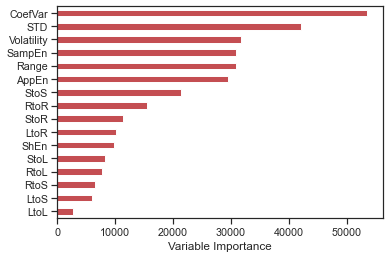

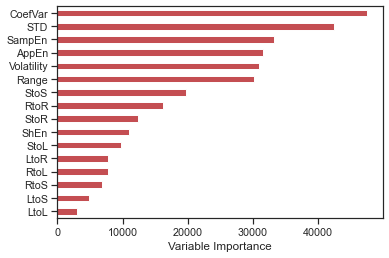

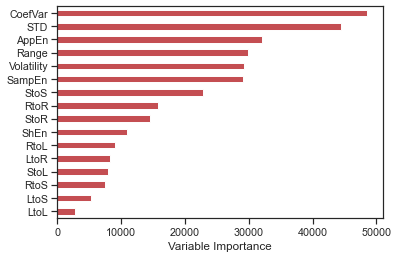

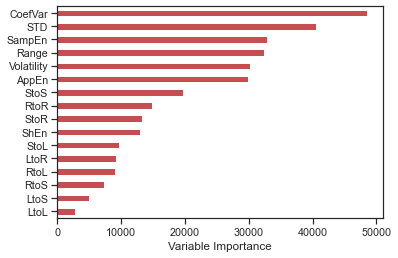

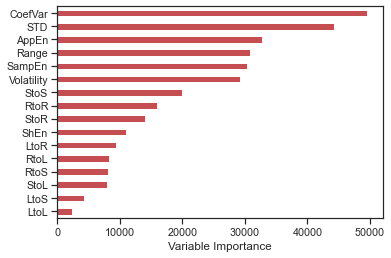

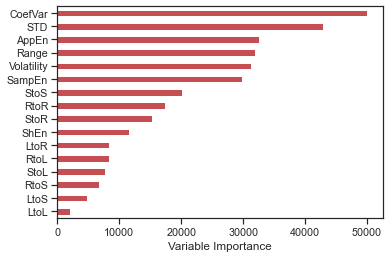

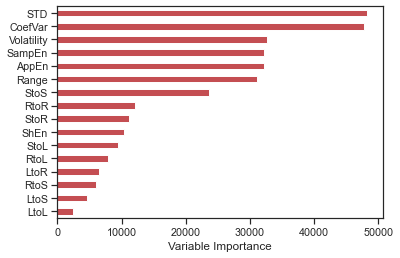

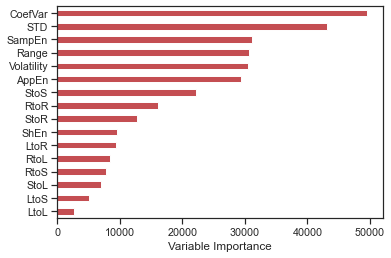

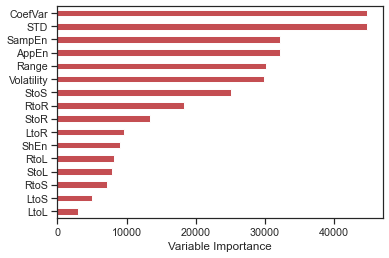

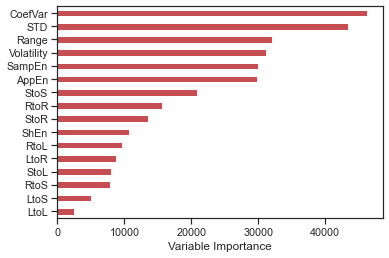

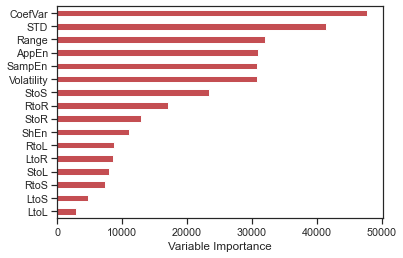

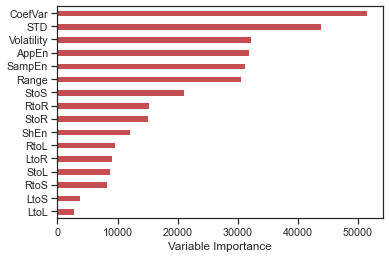

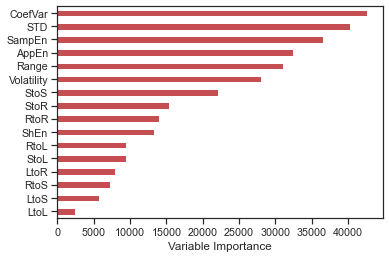

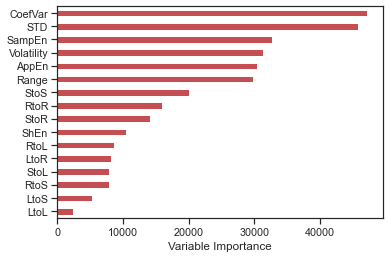

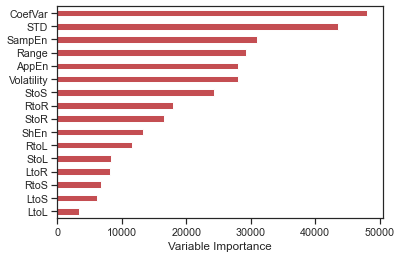

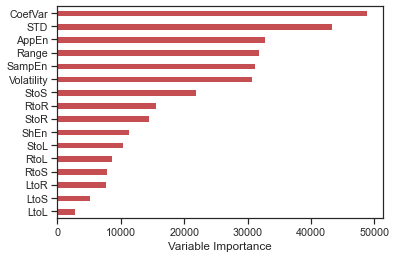

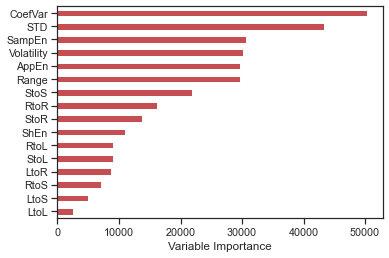

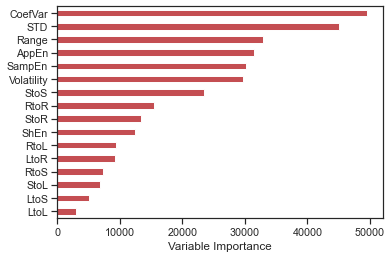

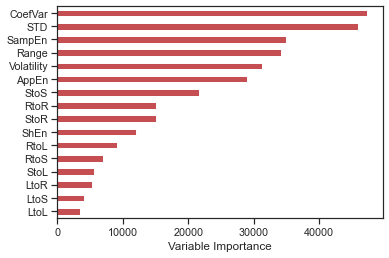

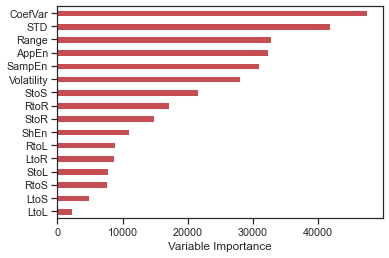

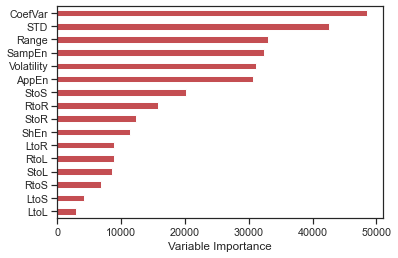

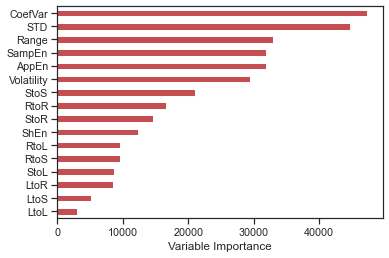

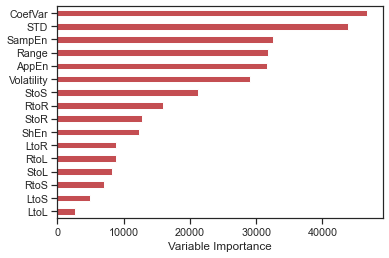

In [37]:
# https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html
import lightgbm

#Implementing cross validation 
kf = KFold(n_splits=23, random_state=1, shuffle=True)


from time import time
import timeit #imports timeit module
start_time = timeit.default_timer() #defines start time so computational time can be calculated

acc_score = [];
Truth = [];
Output = [];
n_estimators_list = []
max_depth_list = []

x_values = ['StoS', 'StoR', 'StoL', 'RtoS', 'RtoR', 'RtoL', 'LtoS',
       'LtoR', 'LtoL', 'STD', 'CoefVar', 'Range', 'Volatility', 'ShEn',
       'AppEn', 'SampEn']
y_values = ['Rhythm']
df = features_maindf

for idx, subject in enumerate(good_list):
    
    train_index = ~df['Subject'].str.contains(subject)
    test_index = df['Subject'].str.contains(subject)
    X_train , X_test = df.loc[train_index,x_values], df.loc[test_index,x_values]
    y_train , y_test = df.loc[train_index,y_values].values.ravel(), df.loc[test_index,y_values]

    temp_model = model.fit(X_train,y_train,eval_set=[(X_test,y_test),(X_train,y_train)],eval_metric='logloss')    
    param_distributions = {'n_estimators': randint(105, 110),
                           'max_depth': randint(7,10)}

    search = RandomizedSearchCV(estimator=temp_model, param_distributions=param_distributions, random_state=0)
    search.fit(X_train, y_train)

    n_estimators_list.append(search.best_params_['n_estimators'])
    max_depth_list.append(search.best_params_['max_depth'])

#     model.fit(X_train,y_train,eval_set=[(X_test,y_test),(X_train,y_train)],
#           eval_metric='logloss')
    model = lightgbm.LGBMClassifier(learning_rate=0.09,max_depth=search.best_params_['max_depth'],n_estimators=search.best_params_['n_estimators'], random_state=42)
    
    # Create the LightGBM data containers
    model.fit(X_train,y_train,eval_set=[(X_test,y_test),(X_train,y_train)],
          eval_metric='logloss')

    pred_values = model.predict(X_test)
     
    acc = accuracy_score(y_test, pred_values)
    acc_score.append(acc)
    
    Truth.extend(y_test.values.reshape(y_test.shape[0])); ## it is a list
    Output.extend(pred_values); ## it is a list  
    
    #print(model.feature_importances_)
    Importance = pd.DataFrame({'Importance':(model.feature_importances_*100)}, 
                          index = (X_train.columns))
    Importance.sort_values(by = 'Importance', 
                       axis = 0, 
                       ascending = True).plot(kind = 'barh', 
                                              color = 'r')
    plt.xlabel('Variable Importance')
    plt.gca().legend_ = None
    #plt.savefig('plot1.png')


elapsed = timeit.default_timer() - start_time #gives total computation time
print("---Run time is %s seconds ---" % elapsed) #prints computation time
print()

print('Accuracy of each fold: \n {}'.format(acc_score))
print()
print('Avg accuracy : \n{}'.format(np.mean(acc_score))); 
print()
print('Std of accuracy : \n{}'.format(np.std(acc_score)))

In [34]:
print(confusion_matrix(Truth, Output))
print(classification_report(Truth, Output))
print(acc_score)
print(elapsed)
print(n_estimators_list)
print(max_depth_list)
#old confusion matrix
#[23104  1639]
#  [ 1720 18505]]
# ---Run time is 155.16974349999873 seconds ---

# Accuracy of each fold: 
#  [0.9164759725400458, 0.9537525354969574, 0.9962216624685138, 0.9268585131894485, 0.9979101358411703, 0.959026369168357, 0.7678654834189631, 0.998638529611981, 0.9392570281124498, 0.9718853362734289, 0.9823049001814882, 0.990667623833453, 0.8285714285714286, 0.9560509554140127, 0.6040799333888426, 0.9880372175454143, 0.9897189856065799, 0.9873052510098096, 0.7514792899408284, 0.959868059373282, 0.9957228400342173, 0.997489014438167, 0.9974630021141649]

# Avg accuracy : 
# 0.9328978290249132

# Std of accuracy : 
# 0.09852275116924226

[[23104  1639]
 [ 1720 18505]]
              precision    recall  f1-score   support

           0       0.93      0.93      0.93     24743
           1       0.92      0.91      0.92     20225

    accuracy                           0.93     44968
   macro avg       0.92      0.92      0.92     44968
weighted avg       0.93      0.93      0.93     44968

[0.9164759725400458, 0.9537525354969574, 0.9962216624685138, 0.9268585131894485, 0.9979101358411703, 0.959026369168357, 0.7678654834189631, 0.998638529611981, 0.9392570281124498, 0.9718853362734289, 0.9823049001814882, 0.990667623833453, 0.8285714285714286, 0.9560509554140127, 0.6040799333888426, 0.9880372175454143, 0.9897189856065799, 0.9873052510098096, 0.7514792899408284, 0.959868059373282, 0.9957228400342173, 0.997489014438167, 0.9974630021141649]
199.88120800000615
[106, 105, 106, 106, 106, 107, 106, 105, 107, 105, 106, 109, 106, 106, 108, 108, 106, 108, 107, 106, 106, 109, 106]
[9, 9, 9, 9, 9, 8, 9, 9, 8, 9, 9, 8, 8, 9, 8, 8, 9,

In [35]:
# ---Run time is 199.88120800000615 seconds ---

# Accuracy of each fold: 
#  [0.9164759725400458, 0.9537525354969574, 0.9962216624685138, 0.9268585131894485, 0.9979101358411703, 0.959026369168357, 0.7678654834189631, 0.998638529611981, 0.9392570281124498, 0.9718853362734289, 0.9823049001814882, 0.990667623833453, 0.8285714285714286, 0.9560509554140127, 0.6040799333888426, 0.9880372175454143, 0.9897189856065799, 0.9873052510098096, 0.7514792899408284, 0.959868059373282, 0.9957228400342173, 0.997489014438167, 0.9974630021141649]

# Avg accuracy : 
# 0.9328978290249132

# Std of accuracy : 
# 0.09852275116924226
#[[23104  1639]
# [ 1720 18505]]

In [28]:
temp_list = []
temp_idx = []
for acc in acc_score:
    if acc >= 0.97:
        temp_list.append(acc)
        temp_idx.append(acc_score.index(acc))
for idx in temp_idx:
    print(n_estimators_list[idx])
    print(max_depth_list[idx])

106
9
106
9
105
9
105
9
106
9
109
8
108
8
106
9
108
8
106
9
109
8
106
9


In [33]:
import statistics

print(statistics.mode(n_estimators_list))
print(statistics.mode(max_depth_list))

106
9


# All

In [8]:
# https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html
import lightgbm

#Implementing cross validation 
kf = KFold(n_splits=23, random_state=1, shuffle=True)


from time import time
import timeit #imports timeit module
start_time = timeit.default_timer() #defines start time so computational time can be calculated

acc_score = [];
Truth = [];
Output = [];
n_estimators_list = []
max_depth_list = []

from sklearn.inspection import permutation_importance
x_values = ['AppEn','SampEn','CosEn','RangeEn', 'FuzzyEn',
       'EntropyAF', 'PermEn', 'BubbleEn', 'MultiscaleEn', 'Volatility',]
y_values = ['Rhythm']
#for df in features_df_list:

zero_values_list = [0] * len(x_values)

perm_imp_dict = dict(zip(x_values,zero_values_list))

# Initialize dataframe with zeros
average_importance = pd.DataFrame({'Importance':np.zeros(len(x_values))}, 
                                  index = x_values)

counts = pd.DataFrame({'Count':np.zeros(len(x_values))}, 
                                  index = x_values)


df = features_maindf

for idx, subject in enumerate(good_list):
    
    train_index = ~df['Subject'].str.contains(subject)
    test_index = df['Subject'].str.contains(subject)
    X_train , X_test = df.loc[train_index,x_values], df.loc[test_index,x_values]
    y_train , y_test = df.loc[train_index,y_values].values.ravel(), df.loc[test_index,y_values]

#     temp_model = model.fit(X_train,y_train,eval_set=[(X_test,y_test),(X_train,y_train)],eval_metric='logloss')    
#     param_distributions = {'n_estimators': randint(105, 110),
#                            'max_depth': randint(7,10)}

#     search = RandomizedSearchCV(estimator=temp_model, param_distributions=param_distributions, random_state=0)
#     search.fit(X_train, y_train)

#     n_estimators_list.append(search.best_params_['n_estimators'])
#     max_depth_list.append(search.best_params_['max_depth'])

#     model.fit(X_train,y_train,eval_set=[(X_test,y_test),(X_train,y_train)],
#           eval_metric='logloss')
    model = lightgbm.LGBMClassifier(learning_rate=0.09,max_depth=9,n_estimators=106, random_state=42)
    
    # Create the LightGBM data containers
    model.fit(X_train,y_train,eval_set=[(X_test,y_test),(X_train,y_train)],
          eval_metric='logloss')

    pred_values = model.predict(X_test)
     
    acc = accuracy_score(y_test, pred_values)
    acc_score.append(acc)
    
    Truth.extend(y_test.values.reshape(y_test.shape[0])); ## it is a list
    Output.extend(pred_values); ## it is a list  
    
    #print(model.feature_importances_)
    temp_importance = pd.DataFrame({'Importance':model.feature_importances_*100}, 
                          index = X_train.columns)
    for feature in X_train.columns:
        average_importance.loc[feature, 'Importance'] += temp_importance.loc[feature, 'Importance']
        counts.loc[feature, 'Count'] += 1
    
    result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=0)

    for i in range(0,len(x_values)):
        perm_imp_dict[x_values[i]] += result.importances_mean[i]*100



elapsed = timeit.default_timer() - start_time #gives total computation time
print("---Run time is %s seconds ---" % elapsed) #prints computation time
print()

print('Accuracy of each fold: \n {}'.format(acc_score))
print()
print('Avg accuracy : \n{}'.format(np.mean(acc_score))); 
print()
print('Std of accuracy : \n{}'.format(np.std(acc_score)))

for i in range(0,len(x_values)):
    perm_imp_dict[x_values[i]] = perm_imp_dict[x_values[i]] / 23

perm_imp_dict["LightGBM"] = 100
perm_imp_df = pd.DataFrame([perm_imp_dict])

perm_imp_df_t = perm_imp_df.T
perm_imp_df_t.columns = ["Importance"]
perm_imp_df_t.sort_values(by=['Importance'],ascending=False)

perm_imp_df_t.to_csv('perm_imp.csv',mode='a',header=False)

perm_imp_df_t = perm_imp_df_t.drop(["LightGBM"])

C:\Users\NNL\anacondareal\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	training's binary_logloss: 0.619776	valid_0's binary_logloss: 0.572474
[2]	training's binary_logloss: 0.559836	valid_0's binary_logloss: 0.523066
[3]	training's binary_logloss: 0.50907	valid_0's binary_logloss: 0.48133
[4]	training's binary_logloss: 0.465575	valid_0's binary_logloss: 0.446228
[5]	training's binary_logloss: 0.427763	valid_0's binary_logloss: 0.416026
[6]	training's binary_logloss: 0.39495	valid_0's binary_logloss: 0.390095
[7]	training's binary_logloss: 0.366144	valid_0's binary_logloss: 0.367423
[8]	training's binary_logloss: 0.340723	valid_0's binary_logloss: 0.348641
[9]	training's binary_logloss: 0.318338	valid_0's binary_logloss: 0.332125
[10]	training's binary_logloss: 0.298061	valid_0's binary_logloss: 0.317631
[11]	training's binary_logloss: 0.28001	valid_0's binary_logloss: 0.305534
[12]	training's binary_logloss: 0.263882	valid_0's binary_logloss: 0.294814
[13]	training's binary_logloss: 0.249506	valid_0's binary_logloss: 0.285717
[14]	training's binary_lo

C:\Users\NNL\anacondareal\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	training's binary_logloss: 0.619616	valid_0's binary_logloss: 0.586801
[2]	training's binary_logloss: 0.560351	valid_0's binary_logloss: 0.529392
[3]	training's binary_logloss: 0.509918	valid_0's binary_logloss: 0.480808
[4]	training's binary_logloss: 0.466742	valid_0's binary_logloss: 0.439028
[5]	training's binary_logloss: 0.429233	valid_0's binary_logloss: 0.402644
[6]	training's binary_logloss: 0.396537	valid_0's binary_logloss: 0.371153
[7]	training's binary_logloss: 0.36787	valid_0's binary_logloss: 0.342653
[8]	training's binary_logloss: 0.342824	valid_0's binary_logloss: 0.318842
[9]	training's binary_logloss: 0.320576	valid_0's binary_logloss: 0.297315
[10]	training's binary_logloss: 0.300797	valid_0's binary_logloss: 0.278385
[11]	training's binary_logloss: 0.283218	valid_0's binary_logloss: 0.26142
[12]	training's binary_logloss: 0.267402	valid_0's binary_logloss: 0.246357
[13]	training's binary_logloss: 0.252898	valid_0's binary_logloss: 0.232571
[14]	training's binary_

C:\Users\NNL\anacondareal\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	training's binary_logloss: 0.62055	valid_0's binary_logloss: 0.557125
[2]	training's binary_logloss: 0.561419	valid_0's binary_logloss: 0.495651
[3]	training's binary_logloss: 0.511223	valid_0's binary_logloss: 0.443306
[4]	training's binary_logloss: 0.468175	valid_0's binary_logloss: 0.397794
[5]	training's binary_logloss: 0.431	valid_0's binary_logloss: 0.358298
[6]	training's binary_logloss: 0.398279	valid_0's binary_logloss: 0.324235
[7]	training's binary_logloss: 0.369817	valid_0's binary_logloss: 0.294037
[8]	training's binary_logloss: 0.344901	valid_0's binary_logloss: 0.26686
[9]	training's binary_logloss: 0.322376	valid_0's binary_logloss: 0.242798
[10]	training's binary_logloss: 0.302572	valid_0's binary_logloss: 0.221521
[11]	training's binary_logloss: 0.284877	valid_0's binary_logloss: 0.202521
[12]	training's binary_logloss: 0.268943	valid_0's binary_logloss: 0.185289
[13]	training's binary_logloss: 0.254868	valid_0's binary_logloss: 0.169882
[14]	training's binary_log

C:\Users\NNL\anacondareal\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	training's binary_logloss: 0.618316	valid_0's binary_logloss: 0.604551
[2]	training's binary_logloss: 0.557733	valid_0's binary_logloss: 0.579975
[3]	training's binary_logloss: 0.506462	valid_0's binary_logloss: 0.559684
[4]	training's binary_logloss: 0.462385	valid_0's binary_logloss: 0.543301
[5]	training's binary_logloss: 0.424089	valid_0's binary_logloss: 0.52974
[6]	training's binary_logloss: 0.390949	valid_0's binary_logloss: 0.521607
[7]	training's binary_logloss: 0.361902	valid_0's binary_logloss: 0.511474
[8]	training's binary_logloss: 0.336062	valid_0's binary_logloss: 0.500469
[9]	training's binary_logloss: 0.312894	valid_0's binary_logloss: 0.48923
[10]	training's binary_logloss: 0.292658	valid_0's binary_logloss: 0.481677
[11]	training's binary_logloss: 0.274676	valid_0's binary_logloss: 0.477034
[12]	training's binary_logloss: 0.258553	valid_0's binary_logloss: 0.472347
[13]	training's binary_logloss: 0.244006	valid_0's binary_logloss: 0.466311
[14]	training's binary_

C:\Users\NNL\anacondareal\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	training's binary_logloss: 0.616029	valid_0's binary_logloss: 0.650399
[2]	training's binary_logloss: 0.55725	valid_0's binary_logloss: 0.579717
[3]	training's binary_logloss: 0.507516	valid_0's binary_logloss: 0.520022
[4]	training's binary_logloss: 0.46485	valid_0's binary_logloss: 0.469878
[5]	training's binary_logloss: 0.427677	valid_0's binary_logloss: 0.424393
[6]	training's binary_logloss: 0.39536	valid_0's binary_logloss: 0.385645
[7]	training's binary_logloss: 0.367106	valid_0's binary_logloss: 0.351559
[8]	training's binary_logloss: 0.34206	valid_0's binary_logloss: 0.321379
[9]	training's binary_logloss: 0.320009	valid_0's binary_logloss: 0.294856
[10]	training's binary_logloss: 0.300502	valid_0's binary_logloss: 0.271477
[11]	training's binary_logloss: 0.282883	valid_0's binary_logloss: 0.249909
[12]	training's binary_logloss: 0.267312	valid_0's binary_logloss: 0.23041
[13]	training's binary_logloss: 0.253331	valid_0's binary_logloss: 0.213309
[14]	training's binary_log

C:\Users\NNL\anacondareal\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	training's binary_logloss: 0.620484	valid_0's binary_logloss: 0.578457
[2]	training's binary_logloss: 0.56132	valid_0's binary_logloss: 0.521436
[3]	training's binary_logloss: 0.510991	valid_0's binary_logloss: 0.472594
[4]	training's binary_logloss: 0.467778	valid_0's binary_logloss: 0.430292
[5]	training's binary_logloss: 0.430283	valid_0's binary_logloss: 0.393924
[6]	training's binary_logloss: 0.397703	valid_0's binary_logloss: 0.362142
[7]	training's binary_logloss: 0.368983	valid_0's binary_logloss: 0.334452
[8]	training's binary_logloss: 0.343756	valid_0's binary_logloss: 0.310108
[9]	training's binary_logloss: 0.321352	valid_0's binary_logloss: 0.288179
[10]	training's binary_logloss: 0.301554	valid_0's binary_logloss: 0.268586
[11]	training's binary_logloss: 0.283852	valid_0's binary_logloss: 0.250951
[12]	training's binary_logloss: 0.267892	valid_0's binary_logloss: 0.235813
[13]	training's binary_logloss: 0.253407	valid_0's binary_logloss: 0.222135
[14]	training's binary

C:\Users\NNL\anacondareal\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	training's binary_logloss: 0.612237	valid_0's binary_logloss: 0.714784
[2]	training's binary_logloss: 0.551573	valid_0's binary_logloss: 0.678317
[3]	training's binary_logloss: 0.500171	valid_0's binary_logloss: 0.645664
[4]	training's binary_logloss: 0.455994	valid_0's binary_logloss: 0.617216
[5]	training's binary_logloss: 0.417637	valid_0's binary_logloss: 0.599313
[6]	training's binary_logloss: 0.384315	valid_0's binary_logloss: 0.585105
[7]	training's binary_logloss: 0.355107	valid_0's binary_logloss: 0.571322
[8]	training's binary_logloss: 0.329364	valid_0's binary_logloss: 0.561351
[9]	training's binary_logloss: 0.306502	valid_0's binary_logloss: 0.553335
[10]	training's binary_logloss: 0.286298	valid_0's binary_logloss: 0.547966
[11]	training's binary_logloss: 0.268073	valid_0's binary_logloss: 0.541231
[12]	training's binary_logloss: 0.251919	valid_0's binary_logloss: 0.536944
[13]	training's binary_logloss: 0.237491	valid_0's binary_logloss: 0.533004
[14]	training's binar

C:\Users\NNL\anacondareal\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	training's binary_logloss: 0.620127	valid_0's binary_logloss: 0.557599
[2]	training's binary_logloss: 0.561015	valid_0's binary_logloss: 0.499983
[3]	training's binary_logloss: 0.510934	valid_0's binary_logloss: 0.448408
[4]	training's binary_logloss: 0.46786	valid_0's binary_logloss: 0.405544
[5]	training's binary_logloss: 0.430549	valid_0's binary_logloss: 0.366836
[6]	training's binary_logloss: 0.398034	valid_0's binary_logloss: 0.332367
[7]	training's binary_logloss: 0.369498	valid_0's binary_logloss: 0.303398
[8]	training's binary_logloss: 0.344418	valid_0's binary_logloss: 0.276657
[9]	training's binary_logloss: 0.321952	valid_0's binary_logloss: 0.252763
[10]	training's binary_logloss: 0.302101	valid_0's binary_logloss: 0.232316
[11]	training's binary_logloss: 0.284648	valid_0's binary_logloss: 0.214223
[12]	training's binary_logloss: 0.268745	valid_0's binary_logloss: 0.198262
[13]	training's binary_logloss: 0.254494	valid_0's binary_logloss: 0.183511
[14]	training's binary

C:\Users\NNL\anacondareal\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	training's binary_logloss: 0.614784	valid_0's binary_logloss: 0.668262
[2]	training's binary_logloss: 0.555357	valid_0's binary_logloss: 0.606944
[3]	training's binary_logloss: 0.504921	valid_0's binary_logloss: 0.554948
[4]	training's binary_logloss: 0.461766	valid_0's binary_logloss: 0.511513
[5]	training's binary_logloss: 0.424214	valid_0's binary_logloss: 0.473204
[6]	training's binary_logloss: 0.391755	valid_0's binary_logloss: 0.440075
[7]	training's binary_logloss: 0.363247	valid_0's binary_logloss: 0.410912
[8]	training's binary_logloss: 0.338124	valid_0's binary_logloss: 0.386653
[9]	training's binary_logloss: 0.315876	valid_0's binary_logloss: 0.365409
[10]	training's binary_logloss: 0.296116	valid_0's binary_logloss: 0.346612
[11]	training's binary_logloss: 0.278384	valid_0's binary_logloss: 0.329683
[12]	training's binary_logloss: 0.26261	valid_0's binary_logloss: 0.315101
[13]	training's binary_logloss: 0.248388	valid_0's binary_logloss: 0.30218
[14]	training's binary_

C:\Users\NNL\anacondareal\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	training's binary_logloss: 0.619987	valid_0's binary_logloss: 0.571065
[2]	training's binary_logloss: 0.560565	valid_0's binary_logloss: 0.518317
[3]	training's binary_logloss: 0.510203	valid_0's binary_logloss: 0.472689
[4]	training's binary_logloss: 0.467016	valid_0's binary_logloss: 0.432855
[5]	training's binary_logloss: 0.429537	valid_0's binary_logloss: 0.399324
[6]	training's binary_logloss: 0.396836	valid_0's binary_logloss: 0.369409
[7]	training's binary_logloss: 0.36832	valid_0's binary_logloss: 0.343079
[8]	training's binary_logloss: 0.342993	valid_0's binary_logloss: 0.320409
[9]	training's binary_logloss: 0.320743	valid_0's binary_logloss: 0.30012
[10]	training's binary_logloss: 0.300758	valid_0's binary_logloss: 0.281476
[11]	training's binary_logloss: 0.282946	valid_0's binary_logloss: 0.264703
[12]	training's binary_logloss: 0.267056	valid_0's binary_logloss: 0.249811
[13]	training's binary_logloss: 0.252776	valid_0's binary_logloss: 0.237235
[14]	training's binary_

C:\Users\NNL\anacondareal\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	training's binary_logloss: 0.611269	valid_0's binary_logloss: 0.744114
[2]	training's binary_logloss: 0.552522	valid_0's binary_logloss: 0.658648
[3]	training's binary_logloss: 0.502942	valid_0's binary_logloss: 0.588253
[4]	training's binary_logloss: 0.460339	valid_0's binary_logloss: 0.528977
[5]	training's binary_logloss: 0.423643	valid_0's binary_logloss: 0.477937
[6]	training's binary_logloss: 0.391665	valid_0's binary_logloss: 0.433409
[7]	training's binary_logloss: 0.363554	valid_0's binary_logloss: 0.395419
[8]	training's binary_logloss: 0.338987	valid_0's binary_logloss: 0.361683
[9]	training's binary_logloss: 0.317076	valid_0's binary_logloss: 0.332061
[10]	training's binary_logloss: 0.297782	valid_0's binary_logloss: 0.306176
[11]	training's binary_logloss: 0.280292	valid_0's binary_logloss: 0.283074
[12]	training's binary_logloss: 0.264885	valid_0's binary_logloss: 0.262436
[13]	training's binary_logloss: 0.250846	valid_0's binary_logloss: 0.244072
[14]	training's binar

C:\Users\NNL\anacondareal\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	training's binary_logloss: 0.619939	valid_0's binary_logloss: 0.556538
[2]	training's binary_logloss: 0.560689	valid_0's binary_logloss: 0.498854
[3]	training's binary_logloss: 0.510581	valid_0's binary_logloss: 0.44899
[4]	training's binary_logloss: 0.467305	valid_0's binary_logloss: 0.406207
[5]	training's binary_logloss: 0.429864	valid_0's binary_logloss: 0.368527
[6]	training's binary_logloss: 0.397173	valid_0's binary_logloss: 0.336235
[7]	training's binary_logloss: 0.368629	valid_0's binary_logloss: 0.307093
[8]	training's binary_logloss: 0.343519	valid_0's binary_logloss: 0.281263
[9]	training's binary_logloss: 0.321118	valid_0's binary_logloss: 0.259028
[10]	training's binary_logloss: 0.301429	valid_0's binary_logloss: 0.238734
[11]	training's binary_logloss: 0.283619	valid_0's binary_logloss: 0.220607
[12]	training's binary_logloss: 0.267806	valid_0's binary_logloss: 0.204581
[13]	training's binary_logloss: 0.253545	valid_0's binary_logloss: 0.19039
[14]	training's binary_

C:\Users\NNL\anacondareal\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	training's binary_logloss: 0.614381	valid_0's binary_logloss: 0.652874
[2]	training's binary_logloss: 0.553394	valid_0's binary_logloss: 0.61802
[3]	training's binary_logloss: 0.501631	valid_0's binary_logloss: 0.589787
[4]	training's binary_logloss: 0.457399	valid_0's binary_logloss: 0.568606
[5]	training's binary_logloss: 0.418962	valid_0's binary_logloss: 0.550355
[6]	training's binary_logloss: 0.385561	valid_0's binary_logloss: 0.532552
[7]	training's binary_logloss: 0.356069	valid_0's binary_logloss: 0.518377
[8]	training's binary_logloss: 0.330187	valid_0's binary_logloss: 0.50998
[9]	training's binary_logloss: 0.307243	valid_0's binary_logloss: 0.500494
[10]	training's binary_logloss: 0.286732	valid_0's binary_logloss: 0.49311
[11]	training's binary_logloss: 0.268587	valid_0's binary_logloss: 0.489084
[12]	training's binary_logloss: 0.252416	valid_0's binary_logloss: 0.485446
[13]	training's binary_logloss: 0.237858	valid_0's binary_logloss: 0.483186
[14]	training's binary_l

C:\Users\NNL\anacondareal\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	training's binary_logloss: 0.613277	valid_0's binary_logloss: 0.742655
[2]	training's binary_logloss: 0.554671	valid_0's binary_logloss: 0.656753
[3]	training's binary_logloss: 0.505023	valid_0's binary_logloss: 0.58712
[4]	training's binary_logloss: 0.462342	valid_0's binary_logloss: 0.525694
[5]	training's binary_logloss: 0.425399	valid_0's binary_logloss: 0.472318
[6]	training's binary_logloss: 0.393419	valid_0's binary_logloss: 0.425931
[7]	training's binary_logloss: 0.365328	valid_0's binary_logloss: 0.387916
[8]	training's binary_logloss: 0.340368	valid_0's binary_logloss: 0.359745
[9]	training's binary_logloss: 0.318632	valid_0's binary_logloss: 0.328225
[10]	training's binary_logloss: 0.299084	valid_0's binary_logloss: 0.300464
[11]	training's binary_logloss: 0.281628	valid_0's binary_logloss: 0.275313
[12]	training's binary_logloss: 0.266244	valid_0's binary_logloss: 0.253639
[13]	training's binary_logloss: 0.252168	valid_0's binary_logloss: 0.235023
[14]	training's binary

C:\Users\NNL\anacondareal\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	training's binary_logloss: 0.607573	valid_0's binary_logloss: 0.830087
[2]	training's binary_logloss: 0.547502	valid_0's binary_logloss: 0.792518
[3]	training's binary_logloss: 0.496784	valid_0's binary_logloss: 0.761907
[4]	training's binary_logloss: 0.453299	valid_0's binary_logloss: 0.730861
[5]	training's binary_logloss: 0.415724	valid_0's binary_logloss: 0.708061
[6]	training's binary_logloss: 0.383153	valid_0's binary_logloss: 0.690621
[7]	training's binary_logloss: 0.354479	valid_0's binary_logloss: 0.679085
[8]	training's binary_logloss: 0.329272	valid_0's binary_logloss: 0.663957
[9]	training's binary_logloss: 0.306842	valid_0's binary_logloss: 0.65082
[10]	training's binary_logloss: 0.286982	valid_0's binary_logloss: 0.639467
[11]	training's binary_logloss: 0.269459	valid_0's binary_logloss: 0.627272
[12]	training's binary_logloss: 0.253657	valid_0's binary_logloss: 0.613749
[13]	training's binary_logloss: 0.239457	valid_0's binary_logloss: 0.603179
[14]	training's binary

C:\Users\NNL\anacondareal\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	training's binary_logloss: 0.614216	valid_0's binary_logloss: 0.678859
[2]	training's binary_logloss: 0.555484	valid_0's binary_logloss: 0.616196
[3]	training's binary_logloss: 0.505413	valid_0's binary_logloss: 0.563911
[4]	training's binary_logloss: 0.462403	valid_0's binary_logloss: 0.516829
[5]	training's binary_logloss: 0.425475	valid_0's binary_logloss: 0.478055
[6]	training's binary_logloss: 0.393165	valid_0's binary_logloss: 0.442061
[7]	training's binary_logloss: 0.364846	valid_0's binary_logloss: 0.412085
[8]	training's binary_logloss: 0.339937	valid_0's binary_logloss: 0.385035
[9]	training's binary_logloss: 0.317876	valid_0's binary_logloss: 0.359928
[10]	training's binary_logloss: 0.298147	valid_0's binary_logloss: 0.337761
[11]	training's binary_logloss: 0.280571	valid_0's binary_logloss: 0.318792
[12]	training's binary_logloss: 0.264801	valid_0's binary_logloss: 0.301372
[13]	training's binary_logloss: 0.250719	valid_0's binary_logloss: 0.285034
[14]	training's binar

C:\Users\NNL\anacondareal\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	training's binary_logloss: 0.619211	valid_0's binary_logloss: 0.57116
[2]	training's binary_logloss: 0.560119	valid_0's binary_logloss: 0.50929
[3]	training's binary_logloss: 0.510037	valid_0's binary_logloss: 0.456445
[4]	training's binary_logloss: 0.467145	valid_0's binary_logloss: 0.410814
[5]	training's binary_logloss: 0.429948	valid_0's binary_logloss: 0.370944
[6]	training's binary_logloss: 0.397422	valid_0's binary_logloss: 0.336582
[7]	training's binary_logloss: 0.369005	valid_0's binary_logloss: 0.306152
[8]	training's binary_logloss: 0.343899	valid_0's binary_logloss: 0.279246
[9]	training's binary_logloss: 0.321517	valid_0's binary_logloss: 0.25519
[10]	training's binary_logloss: 0.30171	valid_0's binary_logloss: 0.233687
[11]	training's binary_logloss: 0.284035	valid_0's binary_logloss: 0.214701
[12]	training's binary_logloss: 0.268201	valid_0's binary_logloss: 0.197322
[13]	training's binary_logloss: 0.253852	valid_0's binary_logloss: 0.18178
[14]	training's binary_log

C:\Users\NNL\anacondareal\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	training's binary_logloss: 0.615284	valid_0's binary_logloss: 0.673869
[2]	training's binary_logloss: 0.556638	valid_0's binary_logloss: 0.596196
[3]	training's binary_logloss: 0.506855	valid_0's binary_logloss: 0.530341
[4]	training's binary_logloss: 0.464059	valid_0's binary_logloss: 0.473541
[5]	training's binary_logloss: 0.42712	valid_0's binary_logloss: 0.425329
[6]	training's binary_logloss: 0.395001	valid_0's binary_logloss: 0.383797
[7]	training's binary_logloss: 0.36698	valid_0's binary_logloss: 0.347167
[8]	training's binary_logloss: 0.342064	valid_0's binary_logloss: 0.314421
[9]	training's binary_logloss: 0.320077	valid_0's binary_logloss: 0.286037
[10]	training's binary_logloss: 0.300579	valid_0's binary_logloss: 0.260691
[11]	training's binary_logloss: 0.283295	valid_0's binary_logloss: 0.238171
[12]	training's binary_logloss: 0.267626	valid_0's binary_logloss: 0.218111
[13]	training's binary_logloss: 0.253509	valid_0's binary_logloss: 0.199703
[14]	training's binary_

C:\Users\NNL\anacondareal\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	training's binary_logloss: 0.618296	valid_0's binary_logloss: 0.607733
[2]	training's binary_logloss: 0.558388	valid_0's binary_logloss: 0.56886
[3]	training's binary_logloss: 0.507358	valid_0's binary_logloss: 0.537918
[4]	training's binary_logloss: 0.463568	valid_0's binary_logloss: 0.50775
[5]	training's binary_logloss: 0.42564	valid_0's binary_logloss: 0.483207
[6]	training's binary_logloss: 0.392519	valid_0's binary_logloss: 0.459724
[7]	training's binary_logloss: 0.363532	valid_0's binary_logloss: 0.441089
[8]	training's binary_logloss: 0.337831	valid_0's binary_logloss: 0.421602
[9]	training's binary_logloss: 0.315147	valid_0's binary_logloss: 0.403817
[10]	training's binary_logloss: 0.294972	valid_0's binary_logloss: 0.390362
[11]	training's binary_logloss: 0.27712	valid_0's binary_logloss: 0.379715
[12]	training's binary_logloss: 0.261085	valid_0's binary_logloss: 0.367984
[13]	training's binary_logloss: 0.246824	valid_0's binary_logloss: 0.358543
[14]	training's binary_lo

C:\Users\NNL\anacondareal\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	training's binary_logloss: 0.619205	valid_0's binary_logloss: 0.583274
[2]	training's binary_logloss: 0.560186	valid_0's binary_logloss: 0.522362
[3]	training's binary_logloss: 0.509985	valid_0's binary_logloss: 0.470753
[4]	training's binary_logloss: 0.466987	valid_0's binary_logloss: 0.425739
[5]	training's binary_logloss: 0.429601	valid_0's binary_logloss: 0.386915
[6]	training's binary_logloss: 0.397294	valid_0's binary_logloss: 0.352979
[7]	training's binary_logloss: 0.368748	valid_0's binary_logloss: 0.322421
[8]	training's binary_logloss: 0.343796	valid_0's binary_logloss: 0.295977
[9]	training's binary_logloss: 0.321367	valid_0's binary_logloss: 0.272558
[10]	training's binary_logloss: 0.301709	valid_0's binary_logloss: 0.251681
[11]	training's binary_logloss: 0.284334	valid_0's binary_logloss: 0.232924
[12]	training's binary_logloss: 0.268468	valid_0's binary_logloss: 0.216029
[13]	training's binary_logloss: 0.254246	valid_0's binary_logloss: 0.200815
[14]	training's binar

C:\Users\NNL\anacondareal\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	training's binary_logloss: 0.613977	valid_0's binary_logloss: 0.682314
[2]	training's binary_logloss: 0.555463	valid_0's binary_logloss: 0.6061
[3]	training's binary_logloss: 0.505893	valid_0's binary_logloss: 0.541982
[4]	training's binary_logloss: 0.463248	valid_0's binary_logloss: 0.487165
[5]	training's binary_logloss: 0.426546	valid_0's binary_logloss: 0.439557
[6]	training's binary_logloss: 0.394353	valid_0's binary_logloss: 0.398033
[7]	training's binary_logloss: 0.366481	valid_0's binary_logloss: 0.36226
[8]	training's binary_logloss: 0.341571	valid_0's binary_logloss: 0.330528
[9]	training's binary_logloss: 0.319462	valid_0's binary_logloss: 0.302507
[10]	training's binary_logloss: 0.30008	valid_0's binary_logloss: 0.277612
[11]	training's binary_logloss: 0.282687	valid_0's binary_logloss: 0.25549
[12]	training's binary_logloss: 0.267228	valid_0's binary_logloss: 0.235688
[13]	training's binary_logloss: 0.253299	valid_0's binary_logloss: 0.217941
[14]	training's binary_log

C:\Users\NNL\anacondareal\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	training's binary_logloss: 0.619841	valid_0's binary_logloss: 0.564177
[2]	training's binary_logloss: 0.560955	valid_0's binary_logloss: 0.506926
[3]	training's binary_logloss: 0.510794	valid_0's binary_logloss: 0.456114
[4]	training's binary_logloss: 0.467666	valid_0's binary_logloss: 0.412599
[5]	training's binary_logloss: 0.430336	valid_0's binary_logloss: 0.374255
[6]	training's binary_logloss: 0.397893	valid_0's binary_logloss: 0.34094
[7]	training's binary_logloss: 0.369321	valid_0's binary_logloss: 0.311848
[8]	training's binary_logloss: 0.344119	valid_0's binary_logloss: 0.286225
[9]	training's binary_logloss: 0.321903	valid_0's binary_logloss: 0.263356
[10]	training's binary_logloss: 0.302201	valid_0's binary_logloss: 0.242737
[11]	training's binary_logloss: 0.28445	valid_0's binary_logloss: 0.223917
[12]	training's binary_logloss: 0.26847	valid_0's binary_logloss: 0.207293
[13]	training's binary_logloss: 0.254192	valid_0's binary_logloss: 0.191898
[14]	training's binary_l

C:\Users\NNL\anacondareal\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	training's binary_logloss: 0.614288	valid_0's binary_logloss: 0.677614
[2]	training's binary_logloss: 0.555497	valid_0's binary_logloss: 0.60383
[3]	training's binary_logloss: 0.505771	valid_0's binary_logloss: 0.541941
[4]	training's binary_logloss: 0.463173	valid_0's binary_logloss: 0.488673
[5]	training's binary_logloss: 0.426282	valid_0's binary_logloss: 0.442869
[6]	training's binary_logloss: 0.394098	valid_0's binary_logloss: 0.403138
[7]	training's binary_logloss: 0.366109	valid_0's binary_logloss: 0.368275
[8]	training's binary_logloss: 0.341013	valid_0's binary_logloss: 0.337381
[9]	training's binary_logloss: 0.319164	valid_0's binary_logloss: 0.310195
[10]	training's binary_logloss: 0.299607	valid_0's binary_logloss: 0.285953
[11]	training's binary_logloss: 0.282376	valid_0's binary_logloss: 0.264409
[12]	training's binary_logloss: 0.266692	valid_0's binary_logloss: 0.245124
[13]	training's binary_logloss: 0.252817	valid_0's binary_logloss: 0.228061
[14]	training's binary

In [9]:
print(confusion_matrix(Truth, Output))
print(classification_report(Truth, Output))
print(acc_score)
print(elapsed)
# [[22875  1868]
#  [ 1984 18241]]
# Accuracy of each fold: 
#  [0.9096109839816934, 0.9533468559837728, 0.9955919395465995, 0.8974820143884892, 0.9947753396029259, 0.9484787018255578, 0.832788416627744, 0.9965963240299524, 0.9362449799196787, 0.964167585446527, 0.9818511796733213, 0.9899497487437185, 0.7836734693877551, 0.9178343949044586, 0.4995836802664446, 0.9787328311918476, 0.9876627827278959, 0.9924985574148875, 0.7176669484361792, 0.9741616272677295, 0.9957228400342173, 0.9912115505335845, 0.9877378435517971]

# Avg accuracy : 
# 0.9229291563255121

# Std of accuracy : 
# 0.11533339006243011

[[23364  1379]
 [ 1315 18910]]
              precision    recall  f1-score   support

           0       0.95      0.94      0.95     24743
           1       0.93      0.93      0.93     20225

    accuracy                           0.94     44968
   macro avg       0.94      0.94      0.94     44968
weighted avg       0.94      0.94      0.94     44968

[0.9216247139588101, 0.9606490872210953, 0.9955919395465995, 0.8405275779376499, 0.9905956112852664, 0.9716024340770791, 0.7580569827183559, 0.9959155888359428, 0.9352409638554217, 0.9647188533627343, 0.9818511796733213, 0.9834888729361091, 0.7922902494331066, 0.964968152866242, 0.8151540383014155, 0.9707576428887904, 0.9945167923235092, 0.9971148297749567, 0.9163144547759933, 0.9840571742715778, 0.9923011120615911, 0.9912115505335845, 0.9898520084566597]
20.298865799995838


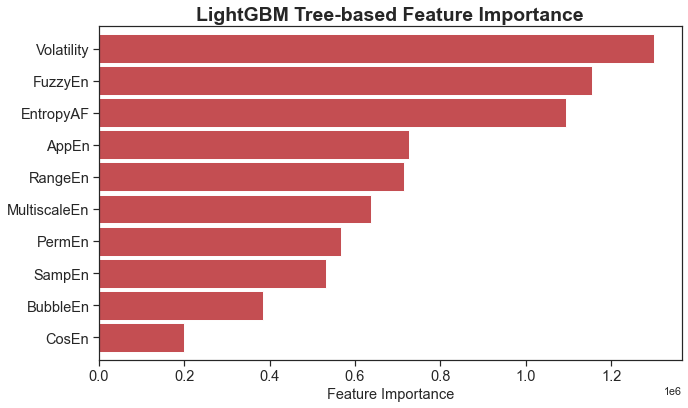

In [9]:
import matplotlib as mpl
df61 = average_importance.sort_values(by='Importance', axis=0, ascending=True)

mpl.rcParams['font.family'] = 'Arial'

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(10, 6))

# Create the plot
df61.plot(kind='barh', color='r', ax=ax, legend=False,width=0.9)

# Set axes labels and title
ax.set_xlabel("Feature Importance", fontsize=15)
ax.set_title("LightGBM Tree-based Feature Importance", fontsize=20, weight='bold')

# Make the axes labels bigger
ax.tick_params(axis='both', which='major', labelsize=15)

plt.tight_layout()
plt.show()


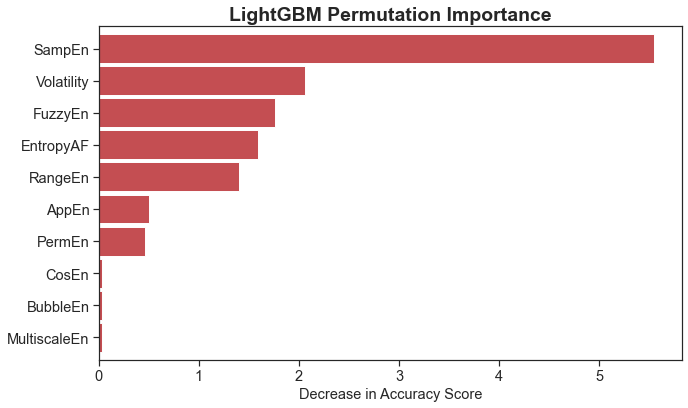

In [10]:
import matplotlib as mpl




df62 = perm_imp_df_t.sort_values(by='Importance', axis=0, ascending=True)

mpl.rcParams['font.family'] = 'Arial'

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(10, 6))

# Create the plot
df62.plot(kind='barh', color='r', ax=ax, legend=False,width=0.9)

# Set axes labels and title
ax.set_xlabel("Decrease in Accuracy Score", fontsize=15)
ax.set_title("LightGBM Permutation Importance", fontsize=20, weight='bold')

# Make the axes labels bigger
ax.tick_params(axis='both', which='major', labelsize=15)

plt.xlim(0)
plt.tight_layout()
plt.show()


In [11]:
print(confusion_matrix(Truth, Output))
print(classification_report(Truth, Output))
print(acc_score)
print(elapsed)

confusion_matrix1 = pd.DataFrame(confusion_matrix(Truth, Output))
acc_score1 = pd.DataFrame([acc_score])

confusion_matrix1.to_csv("model_results/LightGBM_cm.csv",index=False)
acc_score1 = pd.DataFrame([acc_score])
acc_score1 = acc_score1.T
acc_score1.columns = ["Accuracy"]
acc_score1.to_csv("model_results/LightGBM_accuracy.csv",index=False)

[[23367  1376]
 [ 1336 18889]]
              precision    recall  f1-score   support

           0       0.95      0.94      0.95     24743
           1       0.93      0.93      0.93     20225

    accuracy                           0.94     44968
   macro avg       0.94      0.94      0.94     44968
weighted avg       0.94      0.94      0.94     44968

[0.9204805491990846, 0.959026369168357, 0.9962216624685138, 0.8369304556354916, 0.9921630094043887, 0.9691683569979715, 0.7561886968706212, 0.9952348536419333, 0.9357429718875502, 0.9652701212789415, 0.9795825771324864, 0.9834888729361091, 0.7959183673469388, 0.9687898089171975, 0.8084929225645295, 0.9716437749224635, 0.9917751884852639, 0.9988459319099827, 0.9192730346576501, 0.9818581638262782, 0.9923011120615911, 0.9912115505335845, 0.9906976744186047]
21.499793100000034


# No SampEn

In [12]:
# https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html
import lightgbm

#Implementing cross validation 
kf = KFold(n_splits=23, random_state=1, shuffle=True)


from time import time
import timeit #imports timeit module
start_time = timeit.default_timer() #defines start time so computational time can be calculated

acc_score = [];
Truth = [];
Output = [];
n_estimators_list = []
max_depth_list = []

from sklearn.inspection import permutation_importance
x_values = ['AppEn','CosEn','RangeEn', 'FuzzyEn',
       'EntropyAF', 'PermEn', 'BubbleEn', 'MultiscaleEn', 'Volatility',]
y_values = ['Rhythm']
#for df in features_df_list:

zero_values_list = [0] * len(x_values)

perm_imp_dict = dict(zip(x_values,zero_values_list))

# Initialize dataframe with zeros
average_importance = pd.DataFrame({'Importance':np.zeros(len(x_values))}, 
                                  index = x_values)

counts = pd.DataFrame({'Count':np.zeros(len(x_values))}, 
                                  index = x_values)


df = features_maindf

for idx, subject in enumerate(good_list):
    
    train_index = ~df['Subject'].str.contains(subject)
    test_index = df['Subject'].str.contains(subject)
    X_train , X_test = df.loc[train_index,x_values], df.loc[test_index,x_values]
    y_train , y_test = df.loc[train_index,y_values].values.ravel(), df.loc[test_index,y_values]

#     temp_model = model.fit(X_train,y_train,eval_set=[(X_test,y_test),(X_train,y_train)],eval_metric='logloss')    
#     param_distributions = {'n_estimators': randint(105, 110),
#                            'max_depth': randint(7,10)}

#     search = RandomizedSearchCV(estimator=temp_model, param_distributions=param_distributions, random_state=0)
#     search.fit(X_train, y_train)

#     n_estimators_list.append(search.best_params_['n_estimators'])
#     max_depth_list.append(search.best_params_['max_depth'])

#     model.fit(X_train,y_train,eval_set=[(X_test,y_test),(X_train,y_train)],
#           eval_metric='logloss')
    model = lightgbm.LGBMClassifier(learning_rate=0.09,max_depth=9,n_estimators=106, random_state=42)
    
    # Create the LightGBM data containers
    model.fit(X_train,y_train,eval_set=[(X_test,y_test),(X_train,y_train)],
          eval_metric='logloss')

    pred_values = model.predict(X_test)
     
    acc = accuracy_score(y_test, pred_values)
    acc_score.append(acc)
    
    Truth.extend(y_test.values.reshape(y_test.shape[0])); ## it is a list
    Output.extend(pred_values); ## it is a list  
    
    #print(model.feature_importances_)
    temp_importance = pd.DataFrame({'Importance':model.feature_importances_*100}, 
                          index = X_train.columns)
    for feature in X_train.columns:
        average_importance.loc[feature, 'Importance'] += temp_importance.loc[feature, 'Importance']
        counts.loc[feature, 'Count'] += 1
    
    result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=0)

    for i in range(0,len(x_values)):
        perm_imp_dict[x_values[i]] += result.importances_mean[i]*100



elapsed = timeit.default_timer() - start_time #gives total computation time
print("---Run time is %s seconds ---" % elapsed) #prints computation time
print()

print('Accuracy of each fold: \n {}'.format(acc_score))
print()
print('Avg accuracy : \n{}'.format(np.mean(acc_score))); 
print()
print('Std of accuracy : \n{}'.format(np.std(acc_score)))

[1]	training's binary_logloss: 0.619777	valid_0's binary_logloss: 0.572489


C:\Users\NNL\anacondareal\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[2]	training's binary_logloss: 0.559838	valid_0's binary_logloss: 0.523082
[3]	training's binary_logloss: 0.509072	valid_0's binary_logloss: 0.481343
[4]	training's binary_logloss: 0.465576	valid_0's binary_logloss: 0.446226
[5]	training's binary_logloss: 0.427766	valid_0's binary_logloss: 0.416077
[6]	training's binary_logloss: 0.394944	valid_0's binary_logloss: 0.390104
[7]	training's binary_logloss: 0.36613	valid_0's binary_logloss: 0.367465
[8]	training's binary_logloss: 0.340714	valid_0's binary_logloss: 0.348752
[9]	training's binary_logloss: 0.318206	valid_0's binary_logloss: 0.332082
[10]	training's binary_logloss: 0.297958	valid_0's binary_logloss: 0.317813
[11]	training's binary_logloss: 0.280013	valid_0's binary_logloss: 0.305308
[12]	training's binary_logloss: 0.263891	valid_0's binary_logloss: 0.294867
[13]	training's binary_logloss: 0.249419	valid_0's binary_logloss: 0.285759
[14]	training's binary_logloss: 0.236588	valid_0's binary_logloss: 0.277707
[15]	training's binar

C:\Users\NNL\anacondareal\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	training's binary_logloss: 0.619616	valid_0's binary_logloss: 0.586801
[2]	training's binary_logloss: 0.560351	valid_0's binary_logloss: 0.529392
[3]	training's binary_logloss: 0.509903	valid_0's binary_logloss: 0.480775
[4]	training's binary_logloss: 0.466725	valid_0's binary_logloss: 0.438994
[5]	training's binary_logloss: 0.429276	valid_0's binary_logloss: 0.402442
[6]	training's binary_logloss: 0.396544	valid_0's binary_logloss: 0.370974
[7]	training's binary_logloss: 0.367957	valid_0's binary_logloss: 0.342718
[8]	training's binary_logloss: 0.342925	valid_0's binary_logloss: 0.318891
[9]	training's binary_logloss: 0.320527	valid_0's binary_logloss: 0.297097
[10]	training's binary_logloss: 0.300749	valid_0's binary_logloss: 0.278197
[11]	training's binary_logloss: 0.283007	valid_0's binary_logloss: 0.261502
[12]	training's binary_logloss: 0.267154	valid_0's binary_logloss: 0.246092
[13]	training's binary_logloss: 0.252609	valid_0's binary_logloss: 0.232554
[14]	training's binar

C:\Users\NNL\anacondareal\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	training's binary_logloss: 0.620551	valid_0's binary_logloss: 0.557123
[2]	training's binary_logloss: 0.56142	valid_0's binary_logloss: 0.49565
[3]	training's binary_logloss: 0.51129	valid_0's binary_logloss: 0.44352
[4]	training's binary_logloss: 0.468254	valid_0's binary_logloss: 0.398134
[5]	training's binary_logloss: 0.431022	valid_0's binary_logloss: 0.358466
[6]	training's binary_logloss: 0.39818	valid_0's binary_logloss: 0.323917
[7]	training's binary_logloss: 0.369773	valid_0's binary_logloss: 0.293339
[8]	training's binary_logloss: 0.344646	valid_0's binary_logloss: 0.266306
[9]	training's binary_logloss: 0.322468	valid_0's binary_logloss: 0.242501
[10]	training's binary_logloss: 0.302685	valid_0's binary_logloss: 0.221198
[11]	training's binary_logloss: 0.285052	valid_0's binary_logloss: 0.20204
[12]	training's binary_logloss: 0.269025	valid_0's binary_logloss: 0.184904
[13]	training's binary_logloss: 0.254755	valid_0's binary_logloss: 0.169684
[14]	training's binary_logl

C:\Users\NNL\anacondareal\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	training's binary_logloss: 0.618316	valid_0's binary_logloss: 0.604551
[2]	training's binary_logloss: 0.557733	valid_0's binary_logloss: 0.579972
[3]	training's binary_logloss: 0.506515	valid_0's binary_logloss: 0.560722
[4]	training's binary_logloss: 0.462545	valid_0's binary_logloss: 0.54452
[5]	training's binary_logloss: 0.424263	valid_0's binary_logloss: 0.530681
[6]	training's binary_logloss: 0.391067	valid_0's binary_logloss: 0.522234
[7]	training's binary_logloss: 0.361872	valid_0's binary_logloss: 0.510415
[8]	training's binary_logloss: 0.336255	valid_0's binary_logloss: 0.50013
[9]	training's binary_logloss: 0.312978	valid_0's binary_logloss: 0.48986
[10]	training's binary_logloss: 0.292778	valid_0's binary_logloss: 0.481746
[11]	training's binary_logloss: 0.274882	valid_0's binary_logloss: 0.478845
[12]	training's binary_logloss: 0.258686	valid_0's binary_logloss: 0.474368
[13]	training's binary_logloss: 0.244281	valid_0's binary_logloss: 0.468452
[14]	training's binary_l

C:\Users\NNL\anacondareal\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	training's binary_logloss: 0.616033	valid_0's binary_logloss: 0.650394
[2]	training's binary_logloss: 0.557254	valid_0's binary_logloss: 0.579713
[3]	training's binary_logloss: 0.50745	valid_0's binary_logloss: 0.519917
[4]	training's binary_logloss: 0.464564	valid_0's binary_logloss: 0.468892
[5]	training's binary_logloss: 0.42746	valid_0's binary_logloss: 0.4246
[6]	training's binary_logloss: 0.395273	valid_0's binary_logloss: 0.385783
[7]	training's binary_logloss: 0.366932	valid_0's binary_logloss: 0.352365
[8]	training's binary_logloss: 0.342034	valid_0's binary_logloss: 0.322159
[9]	training's binary_logloss: 0.320049	valid_0's binary_logloss: 0.295916
[10]	training's binary_logloss: 0.30044	valid_0's binary_logloss: 0.271603
[11]	training's binary_logloss: 0.283104	valid_0's binary_logloss: 0.250236
[12]	training's binary_logloss: 0.267351	valid_0's binary_logloss: 0.230909
[13]	training's binary_logloss: 0.253334	valid_0's binary_logloss: 0.213684
[14]	training's binary_log

C:\Users\NNL\anacondareal\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	training's binary_logloss: 0.620484	valid_0's binary_logloss: 0.578457
[2]	training's binary_logloss: 0.561275	valid_0's binary_logloss: 0.52121
[3]	training's binary_logloss: 0.511052	valid_0's binary_logloss: 0.472685
[4]	training's binary_logloss: 0.467753	valid_0's binary_logloss: 0.430606
[5]	training's binary_logloss: 0.430301	valid_0's binary_logloss: 0.394581
[6]	training's binary_logloss: 0.397565	valid_0's binary_logloss: 0.362909
[7]	training's binary_logloss: 0.368884	valid_0's binary_logloss: 0.334949
[8]	training's binary_logloss: 0.34362	valid_0's binary_logloss: 0.310627
[9]	training's binary_logloss: 0.321327	valid_0's binary_logloss: 0.288677
[10]	training's binary_logloss: 0.301538	valid_0's binary_logloss: 0.26938
[11]	training's binary_logloss: 0.283808	valid_0's binary_logloss: 0.252057
[12]	training's binary_logloss: 0.267997	valid_0's binary_logloss: 0.236834
[13]	training's binary_logloss: 0.253525	valid_0's binary_logloss: 0.222923
[14]	training's binary_l

C:\Users\NNL\anacondareal\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	training's binary_logloss: 0.612237	valid_0's binary_logloss: 0.714784
[2]	training's binary_logloss: 0.551575	valid_0's binary_logloss: 0.678227
[3]	training's binary_logloss: 0.500115	valid_0's binary_logloss: 0.642682
[4]	training's binary_logloss: 0.455905	valid_0's binary_logloss: 0.616936
[5]	training's binary_logloss: 0.417639	valid_0's binary_logloss: 0.599852
[6]	training's binary_logloss: 0.384259	valid_0's binary_logloss: 0.584847
[7]	training's binary_logloss: 0.355038	valid_0's binary_logloss: 0.57424
[8]	training's binary_logloss: 0.329295	valid_0's binary_logloss: 0.564326
[9]	training's binary_logloss: 0.306589	valid_0's binary_logloss: 0.55645
[10]	training's binary_logloss: 0.286403	valid_0's binary_logloss: 0.548577
[11]	training's binary_logloss: 0.268139	valid_0's binary_logloss: 0.538851
[12]	training's binary_logloss: 0.251919	valid_0's binary_logloss: 0.533691
[13]	training's binary_logloss: 0.237242	valid_0's binary_logloss: 0.530866
[14]	training's binary_

C:\Users\NNL\anacondareal\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	training's binary_logloss: 0.620121	valid_0's binary_logloss: 0.557543
[2]	training's binary_logloss: 0.561007	valid_0's binary_logloss: 0.499932
[3]	training's binary_logloss: 0.51093	valid_0's binary_logloss: 0.448322
[4]	training's binary_logloss: 0.46784	valid_0's binary_logloss: 0.405483
[5]	training's binary_logloss: 0.430582	valid_0's binary_logloss: 0.366826
[6]	training's binary_logloss: 0.397994	valid_0's binary_logloss: 0.332886
[7]	training's binary_logloss: 0.369437	valid_0's binary_logloss: 0.30353
[8]	training's binary_logloss: 0.34434	valid_0's binary_logloss: 0.276824
[9]	training's binary_logloss: 0.321932	valid_0's binary_logloss: 0.252974
[10]	training's binary_logloss: 0.301991	valid_0's binary_logloss: 0.232531
[11]	training's binary_logloss: 0.284495	valid_0's binary_logloss: 0.214656
[12]	training's binary_logloss: 0.268547	valid_0's binary_logloss: 0.197663
[13]	training's binary_logloss: 0.254154	valid_0's binary_logloss: 0.182938
[14]	training's binary_lo

C:\Users\NNL\anacondareal\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	training's binary_logloss: 0.614784	valid_0's binary_logloss: 0.668262
[2]	training's binary_logloss: 0.555356	valid_0's binary_logloss: 0.606943
[3]	training's binary_logloss: 0.505019	valid_0's binary_logloss: 0.554662
[4]	training's binary_logloss: 0.461755	valid_0's binary_logloss: 0.511125
[5]	training's binary_logloss: 0.424202	valid_0's binary_logloss: 0.473851
[6]	training's binary_logloss: 0.391645	valid_0's binary_logloss: 0.441114
[7]	training's binary_logloss: 0.363238	valid_0's binary_logloss: 0.411918
[8]	training's binary_logloss: 0.337965	valid_0's binary_logloss: 0.387525
[9]	training's binary_logloss: 0.31596	valid_0's binary_logloss: 0.365764
[10]	training's binary_logloss: 0.296186	valid_0's binary_logloss: 0.346981
[11]	training's binary_logloss: 0.278625	valid_0's binary_logloss: 0.330231
[12]	training's binary_logloss: 0.262648	valid_0's binary_logloss: 0.315321
[13]	training's binary_logloss: 0.248377	valid_0's binary_logloss: 0.302664
[14]	training's binary

C:\Users\NNL\anacondareal\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	training's binary_logloss: 0.619987	valid_0's binary_logloss: 0.571065
[2]	training's binary_logloss: 0.560565	valid_0's binary_logloss: 0.518317
[3]	training's binary_logloss: 0.510203	valid_0's binary_logloss: 0.472691
[4]	training's binary_logloss: 0.467017	valid_0's binary_logloss: 0.432856
[5]	training's binary_logloss: 0.429538	valid_0's binary_logloss: 0.399326
[6]	training's binary_logloss: 0.396838	valid_0's binary_logloss: 0.36941
[7]	training's binary_logloss: 0.368321	valid_0's binary_logloss: 0.343081
[8]	training's binary_logloss: 0.342995	valid_0's binary_logloss: 0.32041
[9]	training's binary_logloss: 0.320745	valid_0's binary_logloss: 0.300121
[10]	training's binary_logloss: 0.300759	valid_0's binary_logloss: 0.281477
[11]	training's binary_logloss: 0.282947	valid_0's binary_logloss: 0.264704
[12]	training's binary_logloss: 0.267058	valid_0's binary_logloss: 0.249812
[13]	training's binary_logloss: 0.252778	valid_0's binary_logloss: 0.237237
[14]	training's binary_

C:\Users\NNL\anacondareal\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	training's binary_logloss: 0.611269	valid_0's binary_logloss: 0.744114
[2]	training's binary_logloss: 0.552522	valid_0's binary_logloss: 0.658648
[3]	training's binary_logloss: 0.502942	valid_0's binary_logloss: 0.588253
[4]	training's binary_logloss: 0.460339	valid_0's binary_logloss: 0.528977
[5]	training's binary_logloss: 0.423643	valid_0's binary_logloss: 0.477937
[6]	training's binary_logloss: 0.391665	valid_0's binary_logloss: 0.433409
[7]	training's binary_logloss: 0.363554	valid_0's binary_logloss: 0.395419
[8]	training's binary_logloss: 0.338987	valid_0's binary_logloss: 0.361683
[9]	training's binary_logloss: 0.317076	valid_0's binary_logloss: 0.332061
[10]	training's binary_logloss: 0.297782	valid_0's binary_logloss: 0.306176
[11]	training's binary_logloss: 0.280292	valid_0's binary_logloss: 0.283074
[12]	training's binary_logloss: 0.264885	valid_0's binary_logloss: 0.262436
[13]	training's binary_logloss: 0.250846	valid_0's binary_logloss: 0.244072
[14]	training's binar

C:\Users\NNL\anacondareal\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	training's binary_logloss: 0.61993	valid_0's binary_logloss: 0.556539
[2]	training's binary_logloss: 0.56068	valid_0's binary_logloss: 0.498855
[3]	training's binary_logloss: 0.510548	valid_0's binary_logloss: 0.448912
[4]	training's binary_logloss: 0.467271	valid_0's binary_logloss: 0.406125
[5]	training's binary_logloss: 0.429867	valid_0's binary_logloss: 0.368503
[6]	training's binary_logloss: 0.397164	valid_0's binary_logloss: 0.336209
[7]	training's binary_logloss: 0.368613	valid_0's binary_logloss: 0.307066
[8]	training's binary_logloss: 0.343595	valid_0's binary_logloss: 0.281113
[9]	training's binary_logloss: 0.321206	valid_0's binary_logloss: 0.25891
[10]	training's binary_logloss: 0.301365	valid_0's binary_logloss: 0.238814
[11]	training's binary_logloss: 0.283714	valid_0's binary_logloss: 0.221037
[12]	training's binary_logloss: 0.267789	valid_0's binary_logloss: 0.204952
[13]	training's binary_logloss: 0.253607	valid_0's binary_logloss: 0.190214
[14]	training's binary_l

C:\Users\NNL\anacondareal\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	training's binary_logloss: 0.614418	valid_0's binary_logloss: 0.652622
[2]	training's binary_logloss: 0.553435	valid_0's binary_logloss: 0.617794
[3]	training's binary_logloss: 0.501667	valid_0's binary_logloss: 0.589755
[4]	training's binary_logloss: 0.457465	valid_0's binary_logloss: 0.568747
[5]	training's binary_logloss: 0.418991	valid_0's binary_logloss: 0.551086
[6]	training's binary_logloss: 0.385467	valid_0's binary_logloss: 0.534788
[7]	training's binary_logloss: 0.355996	valid_0's binary_logloss: 0.521809
[8]	training's binary_logloss: 0.330058	valid_0's binary_logloss: 0.513347
[9]	training's binary_logloss: 0.3072	valid_0's binary_logloss: 0.504419
[10]	training's binary_logloss: 0.286965	valid_0's binary_logloss: 0.495766
[11]	training's binary_logloss: 0.268684	valid_0's binary_logloss: 0.49011
[12]	training's binary_logloss: 0.252499	valid_0's binary_logloss: 0.48691
[13]	training's binary_logloss: 0.237868	valid_0's binary_logloss: 0.483465
[14]	training's binary_lo

C:\Users\NNL\anacondareal\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	training's binary_logloss: 0.613277	valid_0's binary_logloss: 0.742655
[2]	training's binary_logloss: 0.554671	valid_0's binary_logloss: 0.656753
[3]	training's binary_logloss: 0.505023	valid_0's binary_logloss: 0.58712
[4]	training's binary_logloss: 0.462342	valid_0's binary_logloss: 0.525694
[5]	training's binary_logloss: 0.425399	valid_0's binary_logloss: 0.472318
[6]	training's binary_logloss: 0.393419	valid_0's binary_logloss: 0.425931
[7]	training's binary_logloss: 0.365328	valid_0's binary_logloss: 0.387916
[8]	training's binary_logloss: 0.340368	valid_0's binary_logloss: 0.359745
[9]	training's binary_logloss: 0.318632	valid_0's binary_logloss: 0.328225
[10]	training's binary_logloss: 0.299084	valid_0's binary_logloss: 0.300464
[11]	training's binary_logloss: 0.281628	valid_0's binary_logloss: 0.275313
[12]	training's binary_logloss: 0.266244	valid_0's binary_logloss: 0.253639
[13]	training's binary_logloss: 0.252168	valid_0's binary_logloss: 0.235023
[14]	training's binary

C:\Users\NNL\anacondareal\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	training's binary_logloss: 0.607577	valid_0's binary_logloss: 0.830086
[2]	training's binary_logloss: 0.547509	valid_0's binary_logloss: 0.792531
[3]	training's binary_logloss: 0.496794	valid_0's binary_logloss: 0.761938
[4]	training's binary_logloss: 0.453308	valid_0's binary_logloss: 0.730887
[5]	training's binary_logloss: 0.415734	valid_0's binary_logloss: 0.708077
[6]	training's binary_logloss: 0.383162	valid_0's binary_logloss: 0.690636
[7]	training's binary_logloss: 0.354488	valid_0's binary_logloss: 0.679097
[8]	training's binary_logloss: 0.329281	valid_0's binary_logloss: 0.66397
[9]	training's binary_logloss: 0.30685	valid_0's binary_logloss: 0.650834
[10]	training's binary_logloss: 0.28699	valid_0's binary_logloss: 0.639479
[11]	training's binary_logloss: 0.269471	valid_0's binary_logloss: 0.627344
[12]	training's binary_logloss: 0.25367	valid_0's binary_logloss: 0.615568
[13]	training's binary_logloss: 0.239364	valid_0's binary_logloss: 0.60484
[14]	training's binary_log

C:\Users\NNL\anacondareal\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	training's binary_logloss: 0.614216	valid_0's binary_logloss: 0.678859
[2]	training's binary_logloss: 0.555485	valid_0's binary_logloss: 0.616191
[3]	training's binary_logloss: 0.505414	valid_0's binary_logloss: 0.563906
[4]	training's binary_logloss: 0.462398	valid_0's binary_logloss: 0.516682
[5]	training's binary_logloss: 0.425472	valid_0's binary_logloss: 0.477869
[6]	training's binary_logloss: 0.393154	valid_0's binary_logloss: 0.441843
[7]	training's binary_logloss: 0.364833	valid_0's binary_logloss: 0.411863
[8]	training's binary_logloss: 0.339921	valid_0's binary_logloss: 0.384805
[9]	training's binary_logloss: 0.31786	valid_0's binary_logloss: 0.359702
[10]	training's binary_logloss: 0.298135	valid_0's binary_logloss: 0.337524
[11]	training's binary_logloss: 0.28057	valid_0's binary_logloss: 0.318618
[12]	training's binary_logloss: 0.264868	valid_0's binary_logloss: 0.301547
[13]	training's binary_logloss: 0.250752	valid_0's binary_logloss: 0.285279
[14]	training's binary_

C:\Users\NNL\anacondareal\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	training's binary_logloss: 0.619211	valid_0's binary_logloss: 0.57116
[2]	training's binary_logloss: 0.560119	valid_0's binary_logloss: 0.50929
[3]	training's binary_logloss: 0.510037	valid_0's binary_logloss: 0.456445
[4]	training's binary_logloss: 0.467145	valid_0's binary_logloss: 0.410814
[5]	training's binary_logloss: 0.429949	valid_0's binary_logloss: 0.370895
[6]	training's binary_logloss: 0.397425	valid_0's binary_logloss: 0.336438
[7]	training's binary_logloss: 0.368992	valid_0's binary_logloss: 0.306018
[8]	training's binary_logloss: 0.344033	valid_0's binary_logloss: 0.279188
[9]	training's binary_logloss: 0.321723	valid_0's binary_logloss: 0.25494
[10]	training's binary_logloss: 0.301699	valid_0's binary_logloss: 0.233583
[11]	training's binary_logloss: 0.284088	valid_0's binary_logloss: 0.214288
[12]	training's binary_logloss: 0.268055	valid_0's binary_logloss: 0.197087
[13]	training's binary_logloss: 0.253942	valid_0's binary_logloss: 0.18163
[14]	training's binary_lo

C:\Users\NNL\anacondareal\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	training's binary_logloss: 0.615286	valid_0's binary_logloss: 0.673953
[2]	training's binary_logloss: 0.556644	valid_0's binary_logloss: 0.596271
[3]	training's binary_logloss: 0.50678	valid_0's binary_logloss: 0.530353
[4]	training's binary_logloss: 0.464068	valid_0's binary_logloss: 0.473543
[5]	training's binary_logloss: 0.427154	valid_0's binary_logloss: 0.425401
[6]	training's binary_logloss: 0.394984	valid_0's binary_logloss: 0.383843
[7]	training's binary_logloss: 0.366792	valid_0's binary_logloss: 0.347182
[8]	training's binary_logloss: 0.341812	valid_0's binary_logloss: 0.314786
[9]	training's binary_logloss: 0.319945	valid_0's binary_logloss: 0.286213
[10]	training's binary_logloss: 0.300297	valid_0's binary_logloss: 0.260362
[11]	training's binary_logloss: 0.283058	valid_0's binary_logloss: 0.237992
[12]	training's binary_logloss: 0.267364	valid_0's binary_logloss: 0.217763
[13]	training's binary_logloss: 0.253197	valid_0's binary_logloss: 0.19923
[14]	training's binary_

C:\Users\NNL\anacondareal\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	training's binary_logloss: 0.618296	valid_0's binary_logloss: 0.607733
[2]	training's binary_logloss: 0.558388	valid_0's binary_logloss: 0.56886
[3]	training's binary_logloss: 0.507358	valid_0's binary_logloss: 0.537918
[4]	training's binary_logloss: 0.463568	valid_0's binary_logloss: 0.50775
[5]	training's binary_logloss: 0.42564	valid_0's binary_logloss: 0.483207
[6]	training's binary_logloss: 0.392519	valid_0's binary_logloss: 0.459724
[7]	training's binary_logloss: 0.363532	valid_0's binary_logloss: 0.441089
[8]	training's binary_logloss: 0.337831	valid_0's binary_logloss: 0.421602
[9]	training's binary_logloss: 0.315147	valid_0's binary_logloss: 0.403817
[10]	training's binary_logloss: 0.294972	valid_0's binary_logloss: 0.390362
[11]	training's binary_logloss: 0.277122	valid_0's binary_logloss: 0.379713
[12]	training's binary_logloss: 0.261088	valid_0's binary_logloss: 0.368008
[13]	training's binary_logloss: 0.246826	valid_0's binary_logloss: 0.358567
[14]	training's binary_l

C:\Users\NNL\anacondareal\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	training's binary_logloss: 0.619203	valid_0's binary_logloss: 0.583273
[2]	training's binary_logloss: 0.560187	valid_0's binary_logloss: 0.522355
[3]	training's binary_logloss: 0.509985	valid_0's binary_logloss: 0.470746
[4]	training's binary_logloss: 0.466988	valid_0's binary_logloss: 0.425734
[5]	training's binary_logloss: 0.429602	valid_0's binary_logloss: 0.38703
[6]	training's binary_logloss: 0.397279	valid_0's binary_logloss: 0.35311
[7]	training's binary_logloss: 0.36886	valid_0's binary_logloss: 0.322592
[8]	training's binary_logloss: 0.343803	valid_0's binary_logloss: 0.295927
[9]	training's binary_logloss: 0.321354	valid_0's binary_logloss: 0.272495
[10]	training's binary_logloss: 0.301641	valid_0's binary_logloss: 0.251775
[11]	training's binary_logloss: 0.284089	valid_0's binary_logloss: 0.233356
[12]	training's binary_logloss: 0.268132	valid_0's binary_logloss: 0.216294
[13]	training's binary_logloss: 0.253897	valid_0's binary_logloss: 0.201104
[14]	training's binary_l

C:\Users\NNL\anacondareal\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	training's binary_logloss: 0.613977	valid_0's binary_logloss: 0.682314
[2]	training's binary_logloss: 0.555463	valid_0's binary_logloss: 0.6061
[3]	training's binary_logloss: 0.505893	valid_0's binary_logloss: 0.541982
[4]	training's binary_logloss: 0.463248	valid_0's binary_logloss: 0.487165
[5]	training's binary_logloss: 0.426546	valid_0's binary_logloss: 0.439557
[6]	training's binary_logloss: 0.394353	valid_0's binary_logloss: 0.398033
[7]	training's binary_logloss: 0.366481	valid_0's binary_logloss: 0.36226
[8]	training's binary_logloss: 0.341571	valid_0's binary_logloss: 0.330528
[9]	training's binary_logloss: 0.319462	valid_0's binary_logloss: 0.302507
[10]	training's binary_logloss: 0.30008	valid_0's binary_logloss: 0.277612
[11]	training's binary_logloss: 0.28269	valid_0's binary_logloss: 0.25549
[12]	training's binary_logloss: 0.267231	valid_0's binary_logloss: 0.235693
[13]	training's binary_logloss: 0.253302	valid_0's binary_logloss: 0.217946
[14]	training's binary_logl

C:\Users\NNL\anacondareal\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	training's binary_logloss: 0.619841	valid_0's binary_logloss: 0.564177
[2]	training's binary_logloss: 0.560953	valid_0's binary_logloss: 0.506896
[3]	training's binary_logloss: 0.510789	valid_0's binary_logloss: 0.456081
[4]	training's binary_logloss: 0.467662	valid_0's binary_logloss: 0.412567
[5]	training's binary_logloss: 0.430391	valid_0's binary_logloss: 0.374208
[6]	training's binary_logloss: 0.39795	valid_0's binary_logloss: 0.340736
[7]	training's binary_logloss: 0.369392	valid_0's binary_logloss: 0.311549
[8]	training's binary_logloss: 0.344201	valid_0's binary_logloss: 0.285556
[9]	training's binary_logloss: 0.322083	valid_0's binary_logloss: 0.262613
[10]	training's binary_logloss: 0.302406	valid_0's binary_logloss: 0.242201
[11]	training's binary_logloss: 0.28466	valid_0's binary_logloss: 0.223467
[12]	training's binary_logloss: 0.268659	valid_0's binary_logloss: 0.206713
[13]	training's binary_logloss: 0.254293	valid_0's binary_logloss: 0.191524
[14]	training's binary_

C:\Users\NNL\anacondareal\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	training's binary_logloss: 0.614262	valid_0's binary_logloss: 0.677499
[2]	training's binary_logloss: 0.555509	valid_0's binary_logloss: 0.60359
[3]	training's binary_logloss: 0.505702	valid_0's binary_logloss: 0.541273
[4]	training's binary_logloss: 0.462992	valid_0's binary_logloss: 0.487945
[5]	training's binary_logloss: 0.426137	valid_0's binary_logloss: 0.442207
[6]	training's binary_logloss: 0.394118	valid_0's binary_logloss: 0.402462
[7]	training's binary_logloss: 0.366184	valid_0's binary_logloss: 0.367424
[8]	training's binary_logloss: 0.341224	valid_0's binary_logloss: 0.336804
[9]	training's binary_logloss: 0.319288	valid_0's binary_logloss: 0.309759
[10]	training's binary_logloss: 0.299718	valid_0's binary_logloss: 0.285428
[11]	training's binary_logloss: 0.282385	valid_0's binary_logloss: 0.263887
[12]	training's binary_logloss: 0.266773	valid_0's binary_logloss: 0.244853
[13]	training's binary_logloss: 0.252806	valid_0's binary_logloss: 0.227683
[14]	training's binary

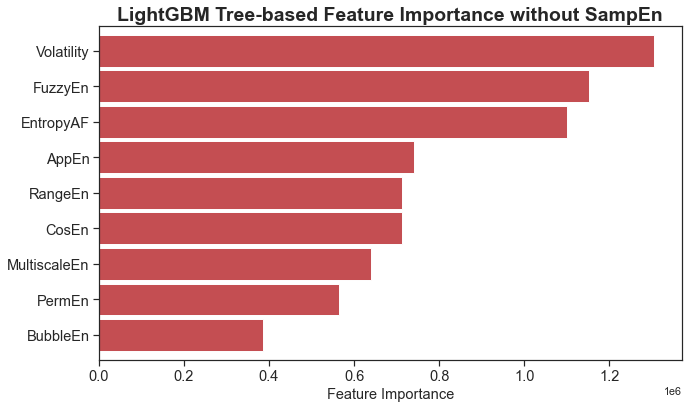

In [13]:
import matplotlib as mpl
df61 = average_importance.sort_values(by='Importance', axis=0, ascending=True)

mpl.rcParams['font.family'] = 'Arial'

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(10, 6))

# Create the plot
df61.plot(kind='barh', color='r', ax=ax, legend=False,width=0.9)

# Set axes labels and title
ax.set_xlabel("Feature Importance", fontsize=15)
ax.set_title("LightGBM Tree-based Feature Importance without SampEn", fontsize=20, weight='bold')

# Make the axes labels bigger
ax.tick_params(axis='both', which='major', labelsize=15)

plt.tight_layout()
plt.show()


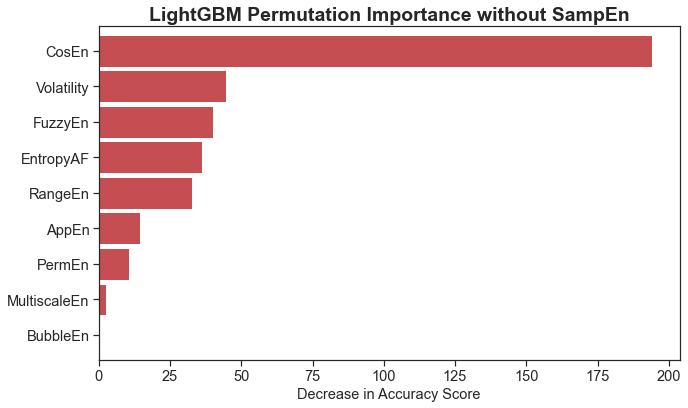

In [14]:
import matplotlib as mpl

perm_imp_df = pd.DataFrame([perm_imp_dict])

perm_imp_df_t = perm_imp_df.T
perm_imp_df_t.columns = ["Importance"]
perm_imp_df_t.sort_values(by=['Importance'],ascending=False)


df62 = perm_imp_df_t.sort_values(by='Importance', axis=0, ascending=True)

mpl.rcParams['font.family'] = 'Arial'

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(10, 6))

# Create the plot
df62.plot(kind='barh', color='r', ax=ax, legend=False,width=0.9)

# Set axes labels and title
ax.set_xlabel("Decrease in Accuracy Score", fontsize=15)
ax.set_title("LightGBM Permutation Importance without SampEn", fontsize=20, weight='bold')

# Make the axes labels bigger
ax.tick_params(axis='both', which='major', labelsize=15)

plt.xlim(0)
plt.tight_layout()
plt.show()


# No SampEn or CosEn

In [15]:
# https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html
import lightgbm

#Implementing cross validation 
kf = KFold(n_splits=23, random_state=1, shuffle=True)


from time import time
import timeit #imports timeit module
start_time = timeit.default_timer() #defines start time so computational time can be calculated

acc_score = [];
Truth = [];
Output = [];
n_estimators_list = []
max_depth_list = []

from sklearn.inspection import permutation_importance
x_values = ['AppEn','RangeEn', 'FuzzyEn',
       'EntropyAF', 'PermEn', 'BubbleEn', 'MultiscaleEn', 'Volatility',]
y_values = ['Rhythm']
#for df in features_df_list:

zero_values_list = [0] * len(x_values)

perm_imp_dict = dict(zip(x_values,zero_values_list))

# Initialize dataframe with zeros
average_importance = pd.DataFrame({'Importance':np.zeros(len(x_values))}, 
                                  index = x_values)

counts = pd.DataFrame({'Count':np.zeros(len(x_values))}, 
                                  index = x_values)


df = features_maindf

for idx, subject in enumerate(good_list):
    
    train_index = ~df['Subject'].str.contains(subject)
    test_index = df['Subject'].str.contains(subject)
    X_train , X_test = df.loc[train_index,x_values], df.loc[test_index,x_values]
    y_train , y_test = df.loc[train_index,y_values].values.ravel(), df.loc[test_index,y_values]

#     temp_model = model.fit(X_train,y_train,eval_set=[(X_test,y_test),(X_train,y_train)],eval_metric='logloss')    
#     param_distributions = {'n_estimators': randint(105, 110),
#                            'max_depth': randint(7,10)}

#     search = RandomizedSearchCV(estimator=temp_model, param_distributions=param_distributions, random_state=0)
#     search.fit(X_train, y_train)

#     n_estimators_list.append(search.best_params_['n_estimators'])
#     max_depth_list.append(search.best_params_['max_depth'])

#     model.fit(X_train,y_train,eval_set=[(X_test,y_test),(X_train,y_train)],
#           eval_metric='logloss')
    model = lightgbm.LGBMClassifier(learning_rate=0.09,max_depth=9,n_estimators=106, random_state=42)
    
    # Create the LightGBM data containers
    model.fit(X_train,y_train,eval_set=[(X_test,y_test),(X_train,y_train)],
          eval_metric='logloss')

    pred_values = model.predict(X_test)
     
    acc = accuracy_score(y_test, pred_values)
    acc_score.append(acc)
    
    Truth.extend(y_test.values.reshape(y_test.shape[0])); ## it is a list
    Output.extend(pred_values); ## it is a list  
    
    #print(model.feature_importances_)
    temp_importance = pd.DataFrame({'Importance':model.feature_importances_*100}, 
                          index = X_train.columns)
    for feature in X_train.columns:
        average_importance.loc[feature, 'Importance'] += temp_importance.loc[feature, 'Importance']
        counts.loc[feature, 'Count'] += 1
    
    result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=0)

    for i in range(0,len(x_values)):
        perm_imp_dict[x_values[i]] += result.importances_mean[i]*100



elapsed = timeit.default_timer() - start_time #gives total computation time
print("---Run time is %s seconds ---" % elapsed) #prints computation time
print()

print('Accuracy of each fold: \n {}'.format(acc_score))
print()
print('Avg accuracy : \n{}'.format(np.mean(acc_score))); 
print()
print('Std of accuracy : \n{}'.format(np.std(acc_score)))


C:\Users\NNL\anacondareal\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	training's binary_logloss: 0.62007	valid_0's binary_logloss: 0.572733
[2]	training's binary_logloss: 0.560391	valid_0's binary_logloss: 0.523359
[3]	training's binary_logloss: 0.509773	valid_0's binary_logloss: 0.481998
[4]	training's binary_logloss: 0.466371	valid_0's binary_logloss: 0.446633
[5]	training's binary_logloss: 0.428796	valid_0's binary_logloss: 0.416386
[6]	training's binary_logloss: 0.396058	valid_0's binary_logloss: 0.391016
[7]	training's binary_logloss: 0.367315	valid_0's binary_logloss: 0.368878
[8]	training's binary_logloss: 0.342009	valid_0's binary_logloss: 0.349733
[9]	training's binary_logloss: 0.319078	valid_0's binary_logloss: 0.332614
[10]	training's binary_logloss: 0.298901	valid_0's binary_logloss: 0.318001
[11]	training's binary_logloss: 0.280894	valid_0's binary_logloss: 0.305404
[12]	training's binary_logloss: 0.264933	valid_0's binary_logloss: 0.294824
[13]	training's binary_logloss: 0.250396	valid_0's binary_logloss: 0.285279
[14]	training's binary

C:\Users\NNL\anacondareal\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	training's binary_logloss: 0.619918	valid_0's binary_logloss: 0.587657
[2]	training's binary_logloss: 0.560778	valid_0's binary_logloss: 0.530094
[3]	training's binary_logloss: 0.510483	valid_0's binary_logloss: 0.481851
[4]	training's binary_logloss: 0.467407	valid_0's binary_logloss: 0.439485
[5]	training's binary_logloss: 0.430138	valid_0's binary_logloss: 0.403392
[6]	training's binary_logloss: 0.397781	valid_0's binary_logloss: 0.37184
[7]	training's binary_logloss: 0.369068	valid_0's binary_logloss: 0.344086
[8]	training's binary_logloss: 0.344	valid_0's binary_logloss: 0.319921
[9]	training's binary_logloss: 0.321677	valid_0's binary_logloss: 0.298615
[10]	training's binary_logloss: 0.302177	valid_0's binary_logloss: 0.279646
[11]	training's binary_logloss: 0.284275	valid_0's binary_logloss: 0.262495
[12]	training's binary_logloss: 0.268311	valid_0's binary_logloss: 0.246851
[13]	training's binary_logloss: 0.253921	valid_0's binary_logloss: 0.232903
[14]	training's binary_lo

C:\Users\NNL\anacondareal\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	training's binary_logloss: 0.620492	valid_0's binary_logloss: 0.557291
[2]	training's binary_logloss: 0.561642	valid_0's binary_logloss: 0.496484
[3]	training's binary_logloss: 0.511741	valid_0's binary_logloss: 0.444559
[4]	training's binary_logloss: 0.468755	valid_0's binary_logloss: 0.399294
[5]	training's binary_logloss: 0.431561	valid_0's binary_logloss: 0.360256
[6]	training's binary_logloss: 0.399251	valid_0's binary_logloss: 0.32576
[7]	training's binary_logloss: 0.370927	valid_0's binary_logloss: 0.295405
[8]	training's binary_logloss: 0.346034	valid_0's binary_logloss: 0.268553
[9]	training's binary_logloss: 0.323705	valid_0's binary_logloss: 0.244375
[10]	training's binary_logloss: 0.303778	valid_0's binary_logloss: 0.223089
[11]	training's binary_logloss: 0.286373	valid_0's binary_logloss: 0.203938
[12]	training's binary_logloss: 0.270602	valid_0's binary_logloss: 0.186787
[13]	training's binary_logloss: 0.256516	valid_0's binary_logloss: 0.171524
[14]	training's binary

C:\Users\NNL\anacondareal\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	training's binary_logloss: 0.618437	valid_0's binary_logloss: 0.603078
[2]	training's binary_logloss: 0.558069	valid_0's binary_logloss: 0.579592
[3]	training's binary_logloss: 0.50683	valid_0's binary_logloss: 0.559418
[4]	training's binary_logloss: 0.462995	valid_0's binary_logloss: 0.543573
[5]	training's binary_logloss: 0.425044	valid_0's binary_logloss: 0.532357
[6]	training's binary_logloss: 0.391852	valid_0's binary_logloss: 0.521141
[7]	training's binary_logloss: 0.362553	valid_0's binary_logloss: 0.512691
[8]	training's binary_logloss: 0.336814	valid_0's binary_logloss: 0.503343
[9]	training's binary_logloss: 0.314214	valid_0's binary_logloss: 0.497899
[10]	training's binary_logloss: 0.294274	valid_0's binary_logloss: 0.495437
[11]	training's binary_logloss: 0.276333	valid_0's binary_logloss: 0.490643
[12]	training's binary_logloss: 0.259838	valid_0's binary_logloss: 0.483737
[13]	training's binary_logloss: 0.245309	valid_0's binary_logloss: 0.477307
[14]	training's binary

C:\Users\NNL\anacondareal\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	training's binary_logloss: 0.616107	valid_0's binary_logloss: 0.649724
[2]	training's binary_logloss: 0.557449	valid_0's binary_logloss: 0.57977
[3]	training's binary_logloss: 0.507709	valid_0's binary_logloss: 0.519401
[4]	training's binary_logloss: 0.465165	valid_0's binary_logloss: 0.46807
[5]	training's binary_logloss: 0.428471	valid_0's binary_logloss: 0.424882
[6]	training's binary_logloss: 0.396366	valid_0's binary_logloss: 0.38712
[7]	training's binary_logloss: 0.368091	valid_0's binary_logloss: 0.353034
[8]	training's binary_logloss: 0.343088	valid_0's binary_logloss: 0.322677
[9]	training's binary_logloss: 0.321019	valid_0's binary_logloss: 0.296884
[10]	training's binary_logloss: 0.301646	valid_0's binary_logloss: 0.274124
[11]	training's binary_logloss: 0.284276	valid_0's binary_logloss: 0.252759
[12]	training's binary_logloss: 0.268275	valid_0's binary_logloss: 0.23342
[13]	training's binary_logloss: 0.254569	valid_0's binary_logloss: 0.216141
[14]	training's binary_lo

C:\Users\NNL\anacondareal\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	training's binary_logloss: 0.620719	valid_0's binary_logloss: 0.579355
[2]	training's binary_logloss: 0.56176	valid_0's binary_logloss: 0.522292
[3]	training's binary_logloss: 0.511575	valid_0's binary_logloss: 0.473677
[4]	training's binary_logloss: 0.468455	valid_0's binary_logloss: 0.431973
[5]	training's binary_logloss: 0.431079	valid_0's binary_logloss: 0.395608
[6]	training's binary_logloss: 0.398661	valid_0's binary_logloss: 0.364104
[7]	training's binary_logloss: 0.370245	valid_0's binary_logloss: 0.33653
[8]	training's binary_logloss: 0.345144	valid_0's binary_logloss: 0.312009
[9]	training's binary_logloss: 0.322664	valid_0's binary_logloss: 0.290249
[10]	training's binary_logloss: 0.302536	valid_0's binary_logloss: 0.270862
[11]	training's binary_logloss: 0.284763	valid_0's binary_logloss: 0.253232
[12]	training's binary_logloss: 0.268894	valid_0's binary_logloss: 0.237966
[13]	training's binary_logloss: 0.254726	valid_0's binary_logloss: 0.224116
[14]	training's binary_

C:\Users\NNL\anacondareal\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	training's binary_logloss: 0.612081	valid_0's binary_logloss: 0.71512
[2]	training's binary_logloss: 0.55139	valid_0's binary_logloss: 0.677049
[3]	training's binary_logloss: 0.500161	valid_0's binary_logloss: 0.648417
[4]	training's binary_logloss: 0.456167	valid_0's binary_logloss: 0.623362
[5]	training's binary_logloss: 0.417665	valid_0's binary_logloss: 0.60439
[6]	training's binary_logloss: 0.384186	valid_0's binary_logloss: 0.58999
[7]	training's binary_logloss: 0.355241	valid_0's binary_logloss: 0.579474
[8]	training's binary_logloss: 0.329584	valid_0's binary_logloss: 0.571629
[9]	training's binary_logloss: 0.306617	valid_0's binary_logloss: 0.561349
[10]	training's binary_logloss: 0.286342	valid_0's binary_logloss: 0.552275
[11]	training's binary_logloss: 0.268007	valid_0's binary_logloss: 0.545315
[12]	training's binary_logloss: 0.251546	valid_0's binary_logloss: 0.541714
[13]	training's binary_logloss: 0.236912	valid_0's binary_logloss: 0.538169
[14]	training's binary_lo

C:\Users\NNL\anacondareal\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	training's binary_logloss: 0.620322	valid_0's binary_logloss: 0.556293
[2]	training's binary_logloss: 0.561412	valid_0's binary_logloss: 0.496986
[3]	training's binary_logloss: 0.511565	valid_0's binary_logloss: 0.446296
[4]	training's binary_logloss: 0.468455	valid_0's binary_logloss: 0.402805
[5]	training's binary_logloss: 0.431238	valid_0's binary_logloss: 0.365709
[6]	training's binary_logloss: 0.39891	valid_0's binary_logloss: 0.332271
[7]	training's binary_logloss: 0.370413	valid_0's binary_logloss: 0.30273
[8]	training's binary_logloss: 0.345347	valid_0's binary_logloss: 0.276105
[9]	training's binary_logloss: 0.322984	valid_0's binary_logloss: 0.253037
[10]	training's binary_logloss: 0.303503	valid_0's binary_logloss: 0.232773
[11]	training's binary_logloss: 0.285585	valid_0's binary_logloss: 0.214135
[12]	training's binary_logloss: 0.269753	valid_0's binary_logloss: 0.198201
[13]	training's binary_logloss: 0.255632	valid_0's binary_logloss: 0.183006
[14]	training's binary_

C:\Users\NNL\anacondareal\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	training's binary_logloss: 0.614629	valid_0's binary_logloss: 0.668961
[2]	training's binary_logloss: 0.555569	valid_0's binary_logloss: 0.606758
[3]	training's binary_logloss: 0.505401	valid_0's binary_logloss: 0.55576
[4]	training's binary_logloss: 0.462461	valid_0's binary_logloss: 0.511681
[5]	training's binary_logloss: 0.425333	valid_0's binary_logloss: 0.473861
[6]	training's binary_logloss: 0.392602	valid_0's binary_logloss: 0.440793
[7]	training's binary_logloss: 0.36408	valid_0's binary_logloss: 0.41199
[8]	training's binary_logloss: 0.339241	valid_0's binary_logloss: 0.386784
[9]	training's binary_logloss: 0.317028	valid_0's binary_logloss: 0.365458
[10]	training's binary_logloss: 0.297146	valid_0's binary_logloss: 0.346479
[11]	training's binary_logloss: 0.279718	valid_0's binary_logloss: 0.330083
[12]	training's binary_logloss: 0.263945	valid_0's binary_logloss: 0.315435
[13]	training's binary_logloss: 0.249535	valid_0's binary_logloss: 0.301816
[14]	training's binary_l

C:\Users\NNL\anacondareal\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	training's binary_logloss: 0.620491	valid_0's binary_logloss: 0.569668
[2]	training's binary_logloss: 0.561274	valid_0's binary_logloss: 0.515714
[3]	training's binary_logloss: 0.511035	valid_0's binary_logloss: 0.469443
[4]	training's binary_logloss: 0.468079	valid_0's binary_logloss: 0.429736
[5]	training's binary_logloss: 0.430577	valid_0's binary_logloss: 0.394517
[6]	training's binary_logloss: 0.397942	valid_0's binary_logloss: 0.364732
[7]	training's binary_logloss: 0.369421	valid_0's binary_logloss: 0.337914
[8]	training's binary_logloss: 0.344219	valid_0's binary_logloss: 0.313714
[9]	training's binary_logloss: 0.321788	valid_0's binary_logloss: 0.292163
[10]	training's binary_logloss: 0.301881	valid_0's binary_logloss: 0.273051
[11]	training's binary_logloss: 0.284175	valid_0's binary_logloss: 0.256549
[12]	training's binary_logloss: 0.268326	valid_0's binary_logloss: 0.242063
[13]	training's binary_logloss: 0.253909	valid_0's binary_logloss: 0.228314
[14]	training's binar

C:\Users\NNL\anacondareal\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	training's binary_logloss: 0.611108	valid_0's binary_logloss: 0.743337
[2]	training's binary_logloss: 0.552968	valid_0's binary_logloss: 0.658857
[3]	training's binary_logloss: 0.50345	valid_0's binary_logloss: 0.588658
[4]	training's binary_logloss: 0.461197	valid_0's binary_logloss: 0.529026
[5]	training's binary_logloss: 0.424597	valid_0's binary_logloss: 0.477957
[6]	training's binary_logloss: 0.39257	valid_0's binary_logloss: 0.433623
[7]	training's binary_logloss: 0.364659	valid_0's binary_logloss: 0.395985
[8]	training's binary_logloss: 0.340117	valid_0's binary_logloss: 0.362491
[9]	training's binary_logloss: 0.317957	valid_0's binary_logloss: 0.332889
[10]	training's binary_logloss: 0.298748	valid_0's binary_logloss: 0.306876
[11]	training's binary_logloss: 0.281456	valid_0's binary_logloss: 0.283414
[12]	training's binary_logloss: 0.265656	valid_0's binary_logloss: 0.262492
[13]	training's binary_logloss: 0.251753	valid_0's binary_logloss: 0.244132
[14]	training's binary_

C:\Users\NNL\anacondareal\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	training's binary_logloss: 0.620157	valid_0's binary_logloss: 0.55637
[2]	training's binary_logloss: 0.561132	valid_0's binary_logloss: 0.498753
[3]	training's binary_logloss: 0.511167	valid_0's binary_logloss: 0.449342
[4]	training's binary_logloss: 0.468201	valid_0's binary_logloss: 0.406249
[5]	training's binary_logloss: 0.431079	valid_0's binary_logloss: 0.368755
[6]	training's binary_logloss: 0.398752	valid_0's binary_logloss: 0.336093
[7]	training's binary_logloss: 0.370228	valid_0's binary_logloss: 0.306948
[8]	training's binary_logloss: 0.344883	valid_0's binary_logloss: 0.281534
[9]	training's binary_logloss: 0.32273	valid_0's binary_logloss: 0.258814
[10]	training's binary_logloss: 0.303087	valid_0's binary_logloss: 0.238745
[11]	training's binary_logloss: 0.285287	valid_0's binary_logloss: 0.22047
[12]	training's binary_logloss: 0.269672	valid_0's binary_logloss: 0.204368
[13]	training's binary_logloss: 0.255257	valid_0's binary_logloss: 0.189343
[14]	training's binary_l

C:\Users\NNL\anacondareal\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	training's binary_logloss: 0.614619	valid_0's binary_logloss: 0.652378
[2]	training's binary_logloss: 0.553922	valid_0's binary_logloss: 0.617025
[3]	training's binary_logloss: 0.502457	valid_0's binary_logloss: 0.588224
[4]	training's binary_logloss: 0.458229	valid_0's binary_logloss: 0.565801
[5]	training's binary_logloss: 0.419968	valid_0's binary_logloss: 0.548181
[6]	training's binary_logloss: 0.38656	valid_0's binary_logloss: 0.531675
[7]	training's binary_logloss: 0.357291	valid_0's binary_logloss: 0.519294
[8]	training's binary_logloss: 0.331596	valid_0's binary_logloss: 0.509116
[9]	training's binary_logloss: 0.308744	valid_0's binary_logloss: 0.499971
[10]	training's binary_logloss: 0.28846	valid_0's binary_logloss: 0.495315
[11]	training's binary_logloss: 0.270248	valid_0's binary_logloss: 0.489275
[12]	training's binary_logloss: 0.253859	valid_0's binary_logloss: 0.483566
[13]	training's binary_logloss: 0.239214	valid_0's binary_logloss: 0.480539
[14]	training's binary_

C:\Users\NNL\anacondareal\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	training's binary_logloss: 0.613056	valid_0's binary_logloss: 0.738739
[2]	training's binary_logloss: 0.554694	valid_0's binary_logloss: 0.652279
[3]	training's binary_logloss: 0.505257	valid_0's binary_logloss: 0.583473
[4]	training's binary_logloss: 0.462808	valid_0's binary_logloss: 0.521763
[5]	training's binary_logloss: 0.426372	valid_0's binary_logloss: 0.469102
[6]	training's binary_logloss: 0.394295	valid_0's binary_logloss: 0.426238
[7]	training's binary_logloss: 0.366104	valid_0's binary_logloss: 0.385449
[8]	training's binary_logloss: 0.341176	valid_0's binary_logloss: 0.349957
[9]	training's binary_logloss: 0.319472	valid_0's binary_logloss: 0.318955
[10]	training's binary_logloss: 0.30018	valid_0's binary_logloss: 0.295563
[11]	training's binary_logloss: 0.282823	valid_0's binary_logloss: 0.270551
[12]	training's binary_logloss: 0.267482	valid_0's binary_logloss: 0.249095
[13]	training's binary_logloss: 0.253284	valid_0's binary_logloss: 0.231526
[14]	training's binary

C:\Users\NNL\anacondareal\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	training's binary_logloss: 0.607586	valid_0's binary_logloss: 0.827251
[2]	training's binary_logloss: 0.547564	valid_0's binary_logloss: 0.789637
[3]	training's binary_logloss: 0.4968	valid_0's binary_logloss: 0.761392
[4]	training's binary_logloss: 0.453365	valid_0's binary_logloss: 0.734006
[5]	training's binary_logloss: 0.415874	valid_0's binary_logloss: 0.717166
[6]	training's binary_logloss: 0.383165	valid_0's binary_logloss: 0.697853
[7]	training's binary_logloss: 0.354549	valid_0's binary_logloss: 0.684562
[8]	training's binary_logloss: 0.329166	valid_0's binary_logloss: 0.6708
[9]	training's binary_logloss: 0.307008	valid_0's binary_logloss: 0.654778
[10]	training's binary_logloss: 0.28724	valid_0's binary_logloss: 0.643397
[11]	training's binary_logloss: 0.269676	valid_0's binary_logloss: 0.632707
[12]	training's binary_logloss: 0.254008	valid_0's binary_logloss: 0.621623
[13]	training's binary_logloss: 0.239954	valid_0's binary_logloss: 0.613027
[14]	training's binary_log

C:\Users\NNL\anacondareal\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	training's binary_logloss: 0.614535	valid_0's binary_logloss: 0.67739
[2]	training's binary_logloss: 0.555848	valid_0's binary_logloss: 0.613527
[3]	training's binary_logloss: 0.506096	valid_0's binary_logloss: 0.559183
[4]	training's binary_logloss: 0.463333	valid_0's binary_logloss: 0.512555
[5]	training's binary_logloss: 0.42642	valid_0's binary_logloss: 0.474547
[6]	training's binary_logloss: 0.393816	valid_0's binary_logloss: 0.43898
[7]	training's binary_logloss: 0.365556	valid_0's binary_logloss: 0.408877
[8]	training's binary_logloss: 0.340573	valid_0's binary_logloss: 0.380827
[9]	training's binary_logloss: 0.318772	valid_0's binary_logloss: 0.35708
[10]	training's binary_logloss: 0.299172	valid_0's binary_logloss: 0.335248
[11]	training's binary_logloss: 0.281484	valid_0's binary_logloss: 0.316179
[12]	training's binary_logloss: 0.265852	valid_0's binary_logloss: 0.298581
[13]	training's binary_logloss: 0.251914	valid_0's binary_logloss: 0.283544
[14]	training's binary_lo

C:\Users\NNL\anacondareal\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	training's binary_logloss: 0.619407	valid_0's binary_logloss: 0.571074
[2]	training's binary_logloss: 0.560596	valid_0's binary_logloss: 0.509331
[3]	training's binary_logloss: 0.510656	valid_0's binary_logloss: 0.456587
[4]	training's binary_logloss: 0.467735	valid_0's binary_logloss: 0.410844
[5]	training's binary_logloss: 0.430634	valid_0's binary_logloss: 0.371288
[6]	training's binary_logloss: 0.39825	valid_0's binary_logloss: 0.336717
[7]	training's binary_logloss: 0.369812	valid_0's binary_logloss: 0.305969
[8]	training's binary_logloss: 0.344565	valid_0's binary_logloss: 0.278694
[9]	training's binary_logloss: 0.322367	valid_0's binary_logloss: 0.254661
[10]	training's binary_logloss: 0.302932	valid_0's binary_logloss: 0.233164
[11]	training's binary_logloss: 0.285273	valid_0's binary_logloss: 0.213972
[12]	training's binary_logloss: 0.269507	valid_0's binary_logloss: 0.19661
[13]	training's binary_logloss: 0.255475	valid_0's binary_logloss: 0.181372
[14]	training's binary_

C:\Users\NNL\anacondareal\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	training's binary_logloss: 0.615151	valid_0's binary_logloss: 0.673601
[2]	training's binary_logloss: 0.556779	valid_0's binary_logloss: 0.595781
[3]	training's binary_logloss: 0.507329	valid_0's binary_logloss: 0.530355
[4]	training's binary_logloss: 0.464939	valid_0's binary_logloss: 0.473696
[5]	training's binary_logloss: 0.428134	valid_0's binary_logloss: 0.425403
[6]	training's binary_logloss: 0.396051	valid_0's binary_logloss: 0.382959
[7]	training's binary_logloss: 0.367611	valid_0's binary_logloss: 0.345838
[8]	training's binary_logloss: 0.342965	valid_0's binary_logloss: 0.313781
[9]	training's binary_logloss: 0.321181	valid_0's binary_logloss: 0.285424
[10]	training's binary_logloss: 0.301675	valid_0's binary_logloss: 0.259722
[11]	training's binary_logloss: 0.284378	valid_0's binary_logloss: 0.237225
[12]	training's binary_logloss: 0.26878	valid_0's binary_logloss: 0.217004
[13]	training's binary_logloss: 0.254706	valid_0's binary_logloss: 0.198927
[14]	training's binary

C:\Users\NNL\anacondareal\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	training's binary_logloss: 0.618811	valid_0's binary_logloss: 0.609081
[2]	training's binary_logloss: 0.558924	valid_0's binary_logloss: 0.566355
[3]	training's binary_logloss: 0.508285	valid_0's binary_logloss: 0.529771
[4]	training's binary_logloss: 0.46461	valid_0's binary_logloss: 0.497138
[5]	training's binary_logloss: 0.42701	valid_0's binary_logloss: 0.473446
[6]	training's binary_logloss: 0.393866	valid_0's binary_logloss: 0.450348
[7]	training's binary_logloss: 0.364982	valid_0's binary_logloss: 0.429882
[8]	training's binary_logloss: 0.339502	valid_0's binary_logloss: 0.412062
[9]	training's binary_logloss: 0.317133	valid_0's binary_logloss: 0.396433
[10]	training's binary_logloss: 0.297042	valid_0's binary_logloss: 0.38335
[11]	training's binary_logloss: 0.279222	valid_0's binary_logloss: 0.368551
[12]	training's binary_logloss: 0.262899	valid_0's binary_logloss: 0.357413
[13]	training's binary_logloss: 0.248268	valid_0's binary_logloss: 0.348794
[14]	training's binary_l

C:\Users\NNL\anacondareal\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	training's binary_logloss: 0.619418	valid_0's binary_logloss: 0.584192
[2]	training's binary_logloss: 0.560632	valid_0's binary_logloss: 0.523382
[3]	training's binary_logloss: 0.510615	valid_0's binary_logloss: 0.471367
[4]	training's binary_logloss: 0.467757	valid_0's binary_logloss: 0.426559
[5]	training's binary_logloss: 0.430533	valid_0's binary_logloss: 0.387631
[6]	training's binary_logloss: 0.398228	valid_0's binary_logloss: 0.353502
[7]	training's binary_logloss: 0.369908	valid_0's binary_logloss: 0.323192
[8]	training's binary_logloss: 0.344871	valid_0's binary_logloss: 0.296585
[9]	training's binary_logloss: 0.322478	valid_0's binary_logloss: 0.273109
[10]	training's binary_logloss: 0.302686	valid_0's binary_logloss: 0.252201
[11]	training's binary_logloss: 0.285065	valid_0's binary_logloss: 0.233137
[12]	training's binary_logloss: 0.269389	valid_0's binary_logloss: 0.216263
[13]	training's binary_logloss: 0.255211	valid_0's binary_logloss: 0.201339
[14]	training's binar

C:\Users\NNL\anacondareal\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	training's binary_logloss: 0.614141	valid_0's binary_logloss: 0.682325
[2]	training's binary_logloss: 0.555875	valid_0's binary_logloss: 0.60561
[3]	training's binary_logloss: 0.506373	valid_0's binary_logloss: 0.541324
[4]	training's binary_logloss: 0.463938	valid_0's binary_logloss: 0.48607
[5]	training's binary_logloss: 0.427499	valid_0's binary_logloss: 0.43853
[6]	training's binary_logloss: 0.395604	valid_0's binary_logloss: 0.39746
[7]	training's binary_logloss: 0.367557	valid_0's binary_logloss: 0.361958
[8]	training's binary_logloss: 0.342859	valid_0's binary_logloss: 0.330163
[9]	training's binary_logloss: 0.320726	valid_0's binary_logloss: 0.301864
[10]	training's binary_logloss: 0.301445	valid_0's binary_logloss: 0.27713
[11]	training's binary_logloss: 0.284358	valid_0's binary_logloss: 0.255059
[12]	training's binary_logloss: 0.269006	valid_0's binary_logloss: 0.235236
[13]	training's binary_logloss: 0.255121	valid_0's binary_logloss: 0.217303
[14]	training's binary_log

C:\Users\NNL\anacondareal\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	training's binary_logloss: 0.620166	valid_0's binary_logloss: 0.564221
[2]	training's binary_logloss: 0.561332	valid_0's binary_logloss: 0.505977
[3]	training's binary_logloss: 0.511318	valid_0's binary_logloss: 0.456133
[4]	training's binary_logloss: 0.468464	valid_0's binary_logloss: 0.412918
[5]	training's binary_logloss: 0.431269	valid_0's binary_logloss: 0.375256
[6]	training's binary_logloss: 0.398965	valid_0's binary_logloss: 0.342157
[7]	training's binary_logloss: 0.370574	valid_0's binary_logloss: 0.313019
[8]	training's binary_logloss: 0.34534	valid_0's binary_logloss: 0.286674
[9]	training's binary_logloss: 0.323332	valid_0's binary_logloss: 0.26366
[10]	training's binary_logloss: 0.30342	valid_0's binary_logloss: 0.24291
[11]	training's binary_logloss: 0.28596	valid_0's binary_logloss: 0.224434
[12]	training's binary_logloss: 0.26989	valid_0's binary_logloss: 0.207118
[13]	training's binary_logloss: 0.25581	valid_0's binary_logloss: 0.192249
[14]	training's binary_loglo

C:\Users\NNL\anacondareal\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	training's binary_logloss: 0.614383	valid_0's binary_logloss: 0.677731
[2]	training's binary_logloss: 0.555774	valid_0's binary_logloss: 0.603752
[3]	training's binary_logloss: 0.506406	valid_0's binary_logloss: 0.541776
[4]	training's binary_logloss: 0.46392	valid_0's binary_logloss: 0.488599
[5]	training's binary_logloss: 0.427166	valid_0's binary_logloss: 0.442972
[6]	training's binary_logloss: 0.395241	valid_0's binary_logloss: 0.402905
[7]	training's binary_logloss: 0.367311	valid_0's binary_logloss: 0.367827
[8]	training's binary_logloss: 0.342467	valid_0's binary_logloss: 0.336957
[9]	training's binary_logloss: 0.320703	valid_0's binary_logloss: 0.309815
[10]	training's binary_logloss: 0.301309	valid_0's binary_logloss: 0.285691
[11]	training's binary_logloss: 0.283876	valid_0's binary_logloss: 0.264192
[12]	training's binary_logloss: 0.268336	valid_0's binary_logloss: 0.245005
[13]	training's binary_logloss: 0.254406	valid_0's binary_logloss: 0.227777
[14]	training's binary

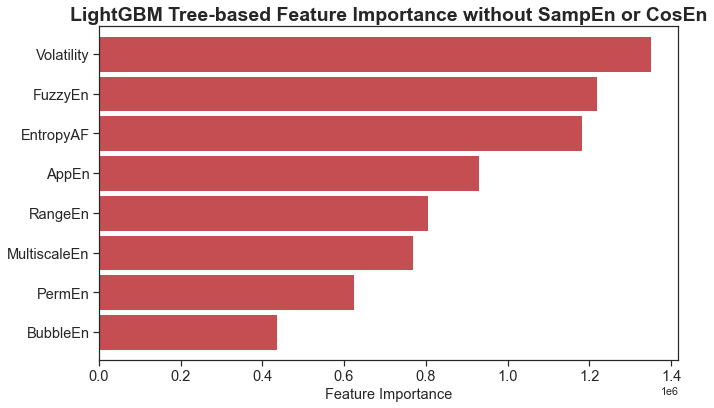

In [16]:
import matplotlib as mpl
df61 = average_importance.sort_values(by='Importance', axis=0, ascending=True)

mpl.rcParams['font.family'] = 'Arial'

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(10, 6))

# Create the plot
df61.plot(kind='barh', color='r', ax=ax, legend=False,width=0.9)

# Set axes labels and title
ax.set_xlabel("Feature Importance", fontsize=15)
ax.set_title("LightGBM Tree-based Feature Importance without SampEn or CosEn", fontsize=20, weight='bold')

# Make the axes labels bigger
ax.tick_params(axis='both', which='major', labelsize=15)

plt.tight_layout()
plt.show()


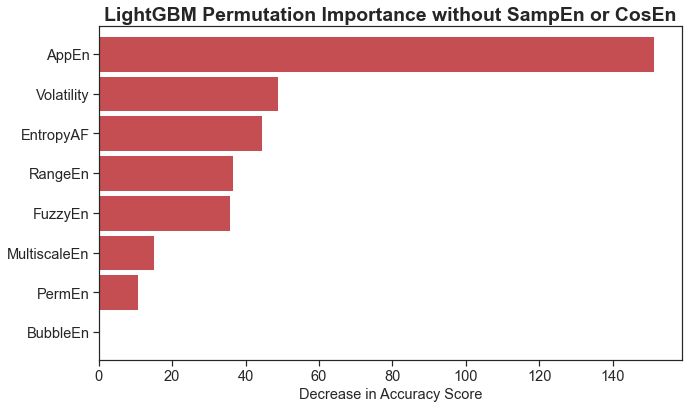

In [17]:
import matplotlib as mpl

perm_imp_df = pd.DataFrame([perm_imp_dict])

perm_imp_df_t = perm_imp_df.T
perm_imp_df_t.columns = ["Importance"]
perm_imp_df_t.sort_values(by=['Importance'],ascending=False)


df62 = perm_imp_df_t.sort_values(by='Importance', axis=0, ascending=True)

mpl.rcParams['font.family'] = 'Arial'

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(10, 6))

# Create the plot
df62.plot(kind='barh', color='r', ax=ax, legend=False,width=0.9)

# Set axes labels and title
ax.set_xlabel("Decrease in Accuracy Score", fontsize=15)
ax.set_title("LightGBM Permutation Importance without SampEn or CosEn", fontsize=20, weight='bold')

# Make the axes labels bigger
ax.tick_params(axis='both', which='major', labelsize=15)

plt.xlim(0)
plt.tight_layout()
plt.show()


C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.619785	valid_0's binary_logloss: 0.571695
[2]	training's binary_logloss: 0.560111	valid_0's binary_logloss: 0.522158
[3]	training's binary_logloss: 0.508618	valid_0's binary_logloss: 0.479956
[4]	training's binary_logloss: 0.464706	valid_0's binary_logloss: 0.445
[5]	training's binary_logloss: 0.426801	valid_0's binary_logloss: 0.414863
[6]	training's binary_logloss: 0.393525	valid_0's binary_logloss: 0.389393
[7]	training's binary_logloss: 0.364499	valid_0's binary_logloss: 0.366794
[8]	training's binary_logloss: 0.338916	valid_0's binary_logloss: 0.347773
[9]	training's binary_logloss: 0.316286	valid_0's binary_logloss: 0.330947
[10]	training's binary_logloss: 0.296104	valid_0's binary_logloss: 0.316558
[11]	training's binary_logloss: 0.278171	valid_0's binary_logloss: 0.304312
[12]	training's binary_logloss: 0.262098	valid_0's binary_logloss: 0.293579
[13]	training's binary_logloss: 0.247713	valid_0's binary_logloss: 0.284032
[14]	training's binary_l

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.619457	valid_0's binary_logloss: 0.588633
[2]	training's binary_logloss: 0.560417	valid_0's binary_logloss: 0.532332
[3]	training's binary_logloss: 0.509475	valid_0's binary_logloss: 0.483348
[4]	training's binary_logloss: 0.465921	valid_0's binary_logloss: 0.442001
[5]	training's binary_logloss: 0.428195	valid_0's binary_logloss: 0.405542
[6]	training's binary_logloss: 0.395441	valid_0's binary_logloss: 0.375074
[7]	training's binary_logloss: 0.366724	valid_0's binary_logloss: 0.346869
[8]	training's binary_logloss: 0.341186	valid_0's binary_logloss: 0.322124
[9]	training's binary_logloss: 0.318579	valid_0's binary_logloss: 0.300297
[10]	training's binary_logloss: 0.298644	valid_0's binary_logloss: 0.281749
[11]	training's binary_logloss: 0.280906	valid_0's binary_logloss: 0.264615
[12]	training's binary_logloss: 0.264934	valid_0's binary_logloss: 0.250217
[13]	training's binary_logloss: 0.250709	valid_0's binary_logloss: 0.236351
[14]	training's binar

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.620399	valid_0's binary_logloss: 0.555687
[2]	training's binary_logloss: 0.561544	valid_0's binary_logloss: 0.493788
[3]	training's binary_logloss: 0.511606	valid_0's binary_logloss: 0.440647
[4]	training's binary_logloss: 0.46808	valid_0's binary_logloss: 0.394532
[5]	training's binary_logloss: 0.430544	valid_0's binary_logloss: 0.35443
[6]	training's binary_logloss: 0.397563	valid_0's binary_logloss: 0.319224
[7]	training's binary_logloss: 0.368817	valid_0's binary_logloss: 0.288419
[8]	training's binary_logloss: 0.34345	valid_0's binary_logloss: 0.261193
[9]	training's binary_logloss: 0.321015	valid_0's binary_logloss: 0.236824
[10]	training's binary_logloss: 0.301176	valid_0's binary_logloss: 0.215177
[11]	training's binary_logloss: 0.283526	valid_0's binary_logloss: 0.195767
[12]	training's binary_logloss: 0.267752	valid_0's binary_logloss: 0.178418
[13]	training's binary_logloss: 0.253645	valid_0's binary_logloss: 0.162775
[14]	training's binary_l

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.618607	valid_0's binary_logloss: 0.58306
[2]	training's binary_logloss: 0.558485	valid_0's binary_logloss: 0.542338
[3]	training's binary_logloss: 0.507351	valid_0's binary_logloss: 0.510876
[4]	training's binary_logloss: 0.463656	valid_0's binary_logloss: 0.482032
[5]	training's binary_logloss: 0.425722	valid_0's binary_logloss: 0.459296
[6]	training's binary_logloss: 0.392816	valid_0's binary_logloss: 0.438448
[7]	training's binary_logloss: 0.363873	valid_0's binary_logloss: 0.418649
[8]	training's binary_logloss: 0.338315	valid_0's binary_logloss: 0.401452
[9]	training's binary_logloss: 0.315669	valid_0's binary_logloss: 0.383506
[10]	training's binary_logloss: 0.295801	valid_0's binary_logloss: 0.368383
[11]	training's binary_logloss: 0.277991	valid_0's binary_logloss: 0.356025
[12]	training's binary_logloss: 0.262093	valid_0's binary_logloss: 0.345996
[13]	training's binary_logloss: 0.247917	valid_0's binary_logloss: 0.336213
[14]	training's binary

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.61593	valid_0's binary_logloss: 0.645337
[2]	training's binary_logloss: 0.557411	valid_0's binary_logloss: 0.571588
[3]	training's binary_logloss: 0.506942	valid_0's binary_logloss: 0.509261
[4]	training's binary_logloss: 0.463915	valid_0's binary_logloss: 0.456162
[5]	training's binary_logloss: 0.426835	valid_0's binary_logloss: 0.41047
[6]	training's binary_logloss: 0.394324	valid_0's binary_logloss: 0.370273
[7]	training's binary_logloss: 0.365992	valid_0's binary_logloss: 0.335065
[8]	training's binary_logloss: 0.340873	valid_0's binary_logloss: 0.304186
[9]	training's binary_logloss: 0.318751	valid_0's binary_logloss: 0.276634
[10]	training's binary_logloss: 0.299116	valid_0's binary_logloss: 0.252716
[11]	training's binary_logloss: 0.281675	valid_0's binary_logloss: 0.231095
[12]	training's binary_logloss: 0.266105	valid_0's binary_logloss: 0.211497
[13]	training's binary_logloss: 0.252157	valid_0's binary_logloss: 0.193908
[14]	training's binary_

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.62037	valid_0's binary_logloss: 0.590617
[2]	training's binary_logloss: 0.560248	valid_0's binary_logloss: 0.53401
[3]	training's binary_logloss: 0.509252	valid_0's binary_logloss: 0.486109
[4]	training's binary_logloss: 0.465653	valid_0's binary_logloss: 0.444785
[5]	training's binary_logloss: 0.42789	valid_0's binary_logloss: 0.409881
[6]	training's binary_logloss: 0.395011	valid_0's binary_logloss: 0.379257
[7]	training's binary_logloss: 0.366265	valid_0's binary_logloss: 0.352787
[8]	training's binary_logloss: 0.340747	valid_0's binary_logloss: 0.329379
[9]	training's binary_logloss: 0.318356	valid_0's binary_logloss: 0.308795
[10]	training's binary_logloss: 0.298353	valid_0's binary_logloss: 0.291515
[11]	training's binary_logloss: 0.280591	valid_0's binary_logloss: 0.280709
[12]	training's binary_logloss: 0.264793	valid_0's binary_logloss: 0.265561
[13]	training's binary_logloss: 0.250517	valid_0's binary_logloss: 0.256576
[14]	training's binary_l

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.612442	valid_0's binary_logloss: 0.705193
[2]	training's binary_logloss: 0.552381	valid_0's binary_logloss: 0.653016
[3]	training's binary_logloss: 0.501429	valid_0's binary_logloss: 0.613435
[4]	training's binary_logloss: 0.457624	valid_0's binary_logloss: 0.578779
[5]	training's binary_logloss: 0.419501	valid_0's binary_logloss: 0.547914
[6]	training's binary_logloss: 0.386127	valid_0's binary_logloss: 0.523275
[7]	training's binary_logloss: 0.356969	valid_0's binary_logloss: 0.502707
[8]	training's binary_logloss: 0.331365	valid_0's binary_logloss: 0.485365
[9]	training's binary_logloss: 0.308605	valid_0's binary_logloss: 0.472589
[10]	training's binary_logloss: 0.288365	valid_0's binary_logloss: 0.458413
[11]	training's binary_logloss: 0.270471	valid_0's binary_logloss: 0.446222
[12]	training's binary_logloss: 0.254627	valid_0's binary_logloss: 0.436292
[13]	training's binary_logloss: 0.240202	valid_0's binary_logloss: 0.428576
[14]	training's binar

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.6202	valid_0's binary_logloss: 0.552247
[2]	training's binary_logloss: 0.561281	valid_0's binary_logloss: 0.490268
[3]	training's binary_logloss: 0.511219	valid_0's binary_logloss: 0.437103
[4]	training's binary_logloss: 0.467662	valid_0's binary_logloss: 0.391104
[5]	training's binary_logloss: 0.430117	valid_0's binary_logloss: 0.35101
[6]	training's binary_logloss: 0.39736	valid_0's binary_logloss: 0.31588
[7]	training's binary_logloss: 0.368614	valid_0's binary_logloss: 0.285014
[8]	training's binary_logloss: 0.343295	valid_0's binary_logloss: 0.257624
[9]	training's binary_logloss: 0.320892	valid_0's binary_logloss: 0.233252
[10]	training's binary_logloss: 0.300964	valid_0's binary_logloss: 0.211583
[11]	training's binary_logloss: 0.283311	valid_0's binary_logloss: 0.192266
[12]	training's binary_logloss: 0.267479	valid_0's binary_logloss: 0.17496
[13]	training's binary_logloss: 0.253147	valid_0's binary_logloss: 0.159491
[14]	training's binary_logl

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.614728	valid_0's binary_logloss: 0.666423
[2]	training's binary_logloss: 0.555586	valid_0's binary_logloss: 0.60276
[3]	training's binary_logloss: 0.505635	valid_0's binary_logloss: 0.54873
[4]	training's binary_logloss: 0.462012	valid_0's binary_logloss: 0.502835
[5]	training's binary_logloss: 0.424382	valid_0's binary_logloss: 0.463729
[6]	training's binary_logloss: 0.391637	valid_0's binary_logloss: 0.429849
[7]	training's binary_logloss: 0.362975	valid_0's binary_logloss: 0.400446
[8]	training's binary_logloss: 0.337586	valid_0's binary_logloss: 0.374902
[9]	training's binary_logloss: 0.315308	valid_0's binary_logloss: 0.352035
[10]	training's binary_logloss: 0.295472	valid_0's binary_logloss: 0.332412
[11]	training's binary_logloss: 0.277804	valid_0's binary_logloss: 0.314726
[12]	training's binary_logloss: 0.261955	valid_0's binary_logloss: 0.299508
[13]	training's binary_logloss: 0.247889	valid_0's binary_logloss: 0.285741
[14]	training's binary_

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.619559	valid_0's binary_logloss: 0.567428
[2]	training's binary_logloss: 0.559981	valid_0's binary_logloss: 0.513426
[3]	training's binary_logloss: 0.509471	valid_0's binary_logloss: 0.467236
[4]	training's binary_logloss: 0.466122	valid_0's binary_logloss: 0.42581
[5]	training's binary_logloss: 0.428483	valid_0's binary_logloss: 0.389746
[6]	training's binary_logloss: 0.395722	valid_0's binary_logloss: 0.358303
[7]	training's binary_logloss: 0.366943	valid_0's binary_logloss: 0.330285
[8]	training's binary_logloss: 0.341648	valid_0's binary_logloss: 0.305631
[9]	training's binary_logloss: 0.319249	valid_0's binary_logloss: 0.283801
[10]	training's binary_logloss: 0.299342	valid_0's binary_logloss: 0.265631
[11]	training's binary_logloss: 0.281712	valid_0's binary_logloss: 0.248478
[12]	training's binary_logloss: 0.265817	valid_0's binary_logloss: 0.233691
[13]	training's binary_logloss: 0.25167	valid_0's binary_logloss: 0.219684
[14]	training's binary_

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.611129	valid_0's binary_logloss: 0.741678
[2]	training's binary_logloss: 0.552791	valid_0's binary_logloss: 0.655155
[3]	training's binary_logloss: 0.502827	valid_0's binary_logloss: 0.583529
[4]	training's binary_logloss: 0.460178	valid_0's binary_logloss: 0.522912
[5]	training's binary_logloss: 0.42295	valid_0's binary_logloss: 0.471093
[6]	training's binary_logloss: 0.390808	valid_0's binary_logloss: 0.426545
[7]	training's binary_logloss: 0.362618	valid_0's binary_logloss: 0.38823
[8]	training's binary_logloss: 0.337748	valid_0's binary_logloss: 0.354371
[9]	training's binary_logloss: 0.315856	valid_0's binary_logloss: 0.324551
[10]	training's binary_logloss: 0.296396	valid_0's binary_logloss: 0.298304
[11]	training's binary_logloss: 0.279066	valid_0's binary_logloss: 0.275211
[12]	training's binary_logloss: 0.263644	valid_0's binary_logloss: 0.254628
[13]	training's binary_logloss: 0.249875	valid_0's binary_logloss: 0.235909
[14]	training's binary_

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.619965	valid_0's binary_logloss: 0.554029
[2]	training's binary_logloss: 0.560972	valid_0's binary_logloss: 0.49423
[3]	training's binary_logloss: 0.510299	valid_0's binary_logloss: 0.44297
[4]	training's binary_logloss: 0.466652	valid_0's binary_logloss: 0.399012
[5]	training's binary_logloss: 0.429126	valid_0's binary_logloss: 0.360556
[6]	training's binary_logloss: 0.39648	valid_0's binary_logloss: 0.327152
[7]	training's binary_logloss: 0.367677	valid_0's binary_logloss: 0.297392
[8]	training's binary_logloss: 0.342334	valid_0's binary_logloss: 0.271062
[9]	training's binary_logloss: 0.319975	valid_0's binary_logloss: 0.247948
[10]	training's binary_logloss: 0.300176	valid_0's binary_logloss: 0.227221
[11]	training's binary_logloss: 0.282288	valid_0's binary_logloss: 0.208838
[12]	training's binary_logloss: 0.266437	valid_0's binary_logloss: 0.192314
[13]	training's binary_logloss: 0.252303	valid_0's binary_logloss: 0.177542
[14]	training's binary_l

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.61575	valid_0's binary_logloss: 0.654833
[2]	training's binary_logloss: 0.554785	valid_0's binary_logloss: 0.619046
[3]	training's binary_logloss: 0.503063	valid_0's binary_logloss: 0.590644
[4]	training's binary_logloss: 0.459463	valid_0's binary_logloss: 0.563165
[5]	training's binary_logloss: 0.421092	valid_0's binary_logloss: 0.542584
[6]	training's binary_logloss: 0.387494	valid_0's binary_logloss: 0.527715
[7]	training's binary_logloss: 0.358266	valid_0's binary_logloss: 0.515506
[8]	training's binary_logloss: 0.332419	valid_0's binary_logloss: 0.503939
[9]	training's binary_logloss: 0.309753	valid_0's binary_logloss: 0.492665
[10]	training's binary_logloss: 0.289606	valid_0's binary_logloss: 0.48617
[11]	training's binary_logloss: 0.271609	valid_0's binary_logloss: 0.480848
[12]	training's binary_logloss: 0.255409	valid_0's binary_logloss: 0.473803
[13]	training's binary_logloss: 0.240785	valid_0's binary_logloss: 0.466986
[14]	training's binary_

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.613166	valid_0's binary_logloss: 0.751539
[2]	training's binary_logloss: 0.554791	valid_0's binary_logloss: 0.670789
[3]	training's binary_logloss: 0.504686	valid_0's binary_logloss: 0.610533
[4]	training's binary_logloss: 0.461838	valid_0's binary_logloss: 0.552302
[5]	training's binary_logloss: 0.424568	valid_0's binary_logloss: 0.504068
[6]	training's binary_logloss: 0.392285	valid_0's binary_logloss: 0.462191
[7]	training's binary_logloss: 0.363965	valid_0's binary_logloss: 0.427934
[8]	training's binary_logloss: 0.339017	valid_0's binary_logloss: 0.401301
[9]	training's binary_logloss: 0.316872	valid_0's binary_logloss: 0.377546
[10]	training's binary_logloss: 0.297309	valid_0's binary_logloss: 0.352595
[11]	training's binary_logloss: 0.279798	valid_0's binary_logloss: 0.334745
[12]	training's binary_logloss: 0.26429	valid_0's binary_logloss: 0.311238
[13]	training's binary_logloss: 0.25013	valid_0's binary_logloss: 0.291497
[14]	training's binary_

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.605826	valid_0's binary_logloss: 0.847027
[2]	training's binary_logloss: 0.54431	valid_0's binary_logloss: 0.838427
[3]	training's binary_logloss: 0.492294	valid_0's binary_logloss: 0.828468
[4]	training's binary_logloss: 0.447972	valid_0's binary_logloss: 0.820605
[5]	training's binary_logloss: 0.409714	valid_0's binary_logloss: 0.817954
[6]	training's binary_logloss: 0.376443	valid_0's binary_logloss: 0.818721
[7]	training's binary_logloss: 0.347439	valid_0's binary_logloss: 0.819336
[8]	training's binary_logloss: 0.321646	valid_0's binary_logloss: 0.819477
[9]	training's binary_logloss: 0.298908	valid_0's binary_logloss: 0.827181
[10]	training's binary_logloss: 0.278908	valid_0's binary_logloss: 0.828685
[11]	training's binary_logloss: 0.261052	valid_0's binary_logloss: 0.832037
[12]	training's binary_logloss: 0.244911	valid_0's binary_logloss: 0.839704
[13]	training's binary_logloss: 0.230665	valid_0's binary_logloss: 0.842384
[14]	training's binary

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.614599	valid_0's binary_logloss: 0.670824
[2]	training's binary_logloss: 0.555262	valid_0's binary_logloss: 0.601633
[3]	training's binary_logloss: 0.505138	valid_0's binary_logloss: 0.545052
[4]	training's binary_logloss: 0.462133	valid_0's binary_logloss: 0.495666
[5]	training's binary_logloss: 0.425107	valid_0's binary_logloss: 0.452148
[6]	training's binary_logloss: 0.392692	valid_0's binary_logloss: 0.414574
[7]	training's binary_logloss: 0.364354	valid_0's binary_logloss: 0.381424
[8]	training's binary_logloss: 0.339306	valid_0's binary_logloss: 0.352468
[9]	training's binary_logloss: 0.317249	valid_0's binary_logloss: 0.32745
[10]	training's binary_logloss: 0.297427	valid_0's binary_logloss: 0.30317
[11]	training's binary_logloss: 0.279875	valid_0's binary_logloss: 0.281662
[12]	training's binary_logloss: 0.26426	valid_0's binary_logloss: 0.262456
[13]	training's binary_logloss: 0.250356	valid_0's binary_logloss: 0.245793
[14]	training's binary_l

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.619156	valid_0's binary_logloss: 0.569966
[2]	training's binary_logloss: 0.560224	valid_0's binary_logloss: 0.50806
[3]	training's binary_logloss: 0.509593	valid_0's binary_logloss: 0.454714
[4]	training's binary_logloss: 0.46606	valid_0's binary_logloss: 0.408826
[5]	training's binary_logloss: 0.428491	valid_0's binary_logloss: 0.36874
[6]	training's binary_logloss: 0.395764	valid_0's binary_logloss: 0.334189
[7]	training's binary_logloss: 0.367117	valid_0's binary_logloss: 0.303554
[8]	training's binary_logloss: 0.3419	valid_0's binary_logloss: 0.27655
[9]	training's binary_logloss: 0.319619	valid_0's binary_logloss: 0.252647
[10]	training's binary_logloss: 0.299814	valid_0's binary_logloss: 0.231356
[11]	training's binary_logloss: 0.282188	valid_0's binary_logloss: 0.212309
[12]	training's binary_logloss: 0.266395	valid_0's binary_logloss: 0.19531
[13]	training's binary_logloss: 0.252131	valid_0's binary_logloss: 0.180099
[14]	training's binary_loglo

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.615146	valid_0's binary_logloss: 0.673905
[2]	training's binary_logloss: 0.556848	valid_0's binary_logloss: 0.596935
[3]	training's binary_logloss: 0.506469	valid_0's binary_logloss: 0.532169
[4]	training's binary_logloss: 0.463221	valid_0's binary_logloss: 0.477284
[5]	training's binary_logloss: 0.425997	valid_0's binary_logloss: 0.429403
[6]	training's binary_logloss: 0.393534	valid_0's binary_logloss: 0.387286
[7]	training's binary_logloss: 0.365072	valid_0's binary_logloss: 0.350799
[8]	training's binary_logloss: 0.339913	valid_0's binary_logloss: 0.320383
[9]	training's binary_logloss: 0.317817	valid_0's binary_logloss: 0.292081
[10]	training's binary_logloss: 0.298192	valid_0's binary_logloss: 0.268379
[11]	training's binary_logloss: 0.280786	valid_0's binary_logloss: 0.247851
[12]	training's binary_logloss: 0.26516	valid_0's binary_logloss: 0.227563
[13]	training's binary_logloss: 0.251199	valid_0's binary_logloss: 0.209465
[14]	training's binary

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.61632	valid_0's binary_logloss: 0.631705
[2]	training's binary_logloss: 0.554892	valid_0's binary_logloss: 0.613409
[3]	training's binary_logloss: 0.502368	valid_0's binary_logloss: 0.592177
[4]	training's binary_logloss: 0.45743	valid_0's binary_logloss: 0.580405
[5]	training's binary_logloss: 0.418757	valid_0's binary_logloss: 0.567483
[6]	training's binary_logloss: 0.384737	valid_0's binary_logloss: 0.560069
[7]	training's binary_logloss: 0.354972	valid_0's binary_logloss: 0.552802
[8]	training's binary_logloss: 0.32868	valid_0's binary_logloss: 0.548912
[9]	training's binary_logloss: 0.305502	valid_0's binary_logloss: 0.551094
[10]	training's binary_logloss: 0.28488	valid_0's binary_logloss: 0.549241
[11]	training's binary_logloss: 0.266516	valid_0's binary_logloss: 0.54921
[12]	training's binary_logloss: 0.250113	valid_0's binary_logloss: 0.549797
[13]	training's binary_logloss: 0.235102	valid_0's binary_logloss: 0.549642
[14]	training's binary_log

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.61899	valid_0's binary_logloss: 0.588371
[2]	training's binary_logloss: 0.560009	valid_0's binary_logloss: 0.531955
[3]	training's binary_logloss: 0.509117	valid_0's binary_logloss: 0.482409
[4]	training's binary_logloss: 0.465772	valid_0's binary_logloss: 0.439209
[5]	training's binary_logloss: 0.428222	valid_0's binary_logloss: 0.401369
[6]	training's binary_logloss: 0.395506	valid_0's binary_logloss: 0.368704
[7]	training's binary_logloss: 0.366819	valid_0's binary_logloss: 0.340817
[8]	training's binary_logloss: 0.341584	valid_0's binary_logloss: 0.315515
[9]	training's binary_logloss: 0.319246	valid_0's binary_logloss: 0.293378
[10]	training's binary_logloss: 0.299402	valid_0's binary_logloss: 0.27309
[11]	training's binary_logloss: 0.281568	valid_0's binary_logloss: 0.256608
[12]	training's binary_logloss: 0.265801	valid_0's binary_logloss: 0.24118
[13]	training's binary_logloss: 0.2516	valid_0's binary_logloss: 0.227882
[14]	training's binary_log

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\pandas\plotting\_matplotlib\core.py:386: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


[1]	training's binary_logloss: 0.613908	valid_0's binary_logloss: 0.682094
[2]	training's binary_logloss: 0.555603	valid_0's binary_logloss: 0.607107
[3]	training's binary_logloss: 0.505369	valid_0's binary_logloss: 0.543229
[4]	training's binary_logloss: 0.462553	valid_0's binary_logloss: 0.487694
[5]	training's binary_logloss: 0.425571	valid_0's binary_logloss: 0.440326
[6]	training's binary_logloss: 0.393234	valid_0's binary_logloss: 0.398641
[7]	training's binary_logloss: 0.365059	valid_0's binary_logloss: 0.363182
[8]	training's binary_logloss: 0.340248	valid_0's binary_logloss: 0.331692
[9]	training's binary_logloss: 0.31825	valid_0's binary_logloss: 0.303887
[10]	training's binary_logloss: 0.298683	valid_0's binary_logloss: 0.279605
[11]	training's binary_logloss: 0.281213	valid_0's binary_logloss: 0.257754
[12]	training's binary_logloss: 0.265686	valid_0's binary_logloss: 0.238371
[13]	training's binary_logloss: 0.251586	valid_0's binary_logloss: 0.220647
[14]	training's binary

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.619265	valid_0's binary_logloss: 0.559943
[2]	training's binary_logloss: 0.559881	valid_0's binary_logloss: 0.498942
[3]	training's binary_logloss: 0.509572	valid_0's binary_logloss: 0.447199
[4]	training's binary_logloss: 0.466446	valid_0's binary_logloss: 0.401906
[5]	training's binary_logloss: 0.429132	valid_0's binary_logloss: 0.36212
[6]	training's binary_logloss: 0.396642	valid_0's binary_logloss: 0.327661
[7]	training's binary_logloss: 0.367862	valid_0's binary_logloss: 0.297414
[8]	training's binary_logloss: 0.342639	valid_0's binary_logloss: 0.270936
[9]	training's binary_logloss: 0.320362	valid_0's binary_logloss: 0.246686
[10]	training's binary_logloss: 0.300607	valid_0's binary_logloss: 0.224887
[11]	training's binary_logloss: 0.282925	valid_0's binary_logloss: 0.206226
[12]	training's binary_logloss: 0.26716	valid_0's binary_logloss: 0.188672
[13]	training's binary_logloss: 0.252829	valid_0's binary_logloss: 0.172697
[14]	training's binary_

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.614138	valid_0's binary_logloss: 0.676483
[2]	training's binary_logloss: 0.555766	valid_0's binary_logloss: 0.600478
[3]	training's binary_logloss: 0.505385	valid_0's binary_logloss: 0.536879
[4]	training's binary_logloss: 0.462467	valid_0's binary_logloss: 0.484106
[5]	training's binary_logloss: 0.425388	valid_0's binary_logloss: 0.438263
[6]	training's binary_logloss: 0.393206	valid_0's binary_logloss: 0.398141
[7]	training's binary_logloss: 0.364942	valid_0's binary_logloss: 0.36305
[8]	training's binary_logloss: 0.340089	valid_0's binary_logloss: 0.33213
[9]	training's binary_logloss: 0.318103	valid_0's binary_logloss: 0.304505
[10]	training's binary_logloss: 0.29863	valid_0's binary_logloss: 0.280145
[11]	training's binary_logloss: 0.28121	valid_0's binary_logloss: 0.258943
[12]	training's binary_logloss: 0.265665	valid_0's binary_logloss: 0.238759
[13]	training's binary_logloss: 0.251716	valid_0's binary_logloss: 0.221686
[14]	training's binary_lo

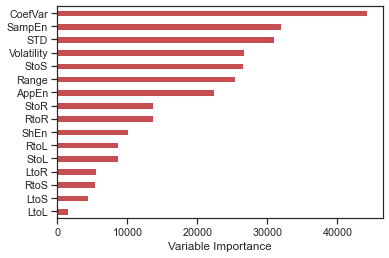

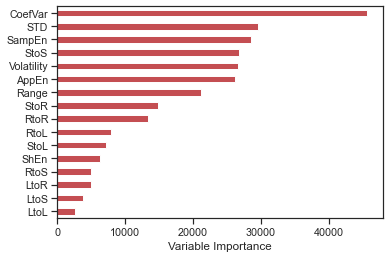

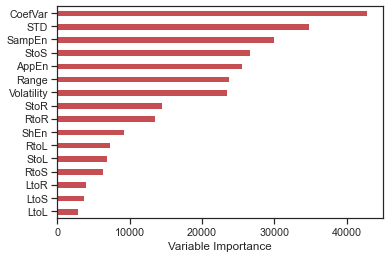

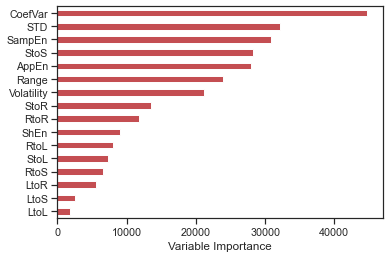

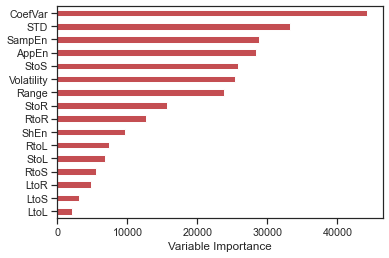

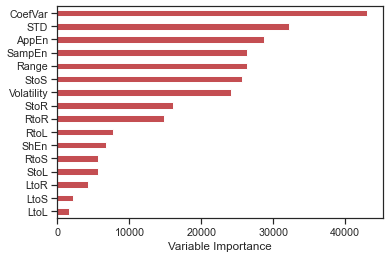

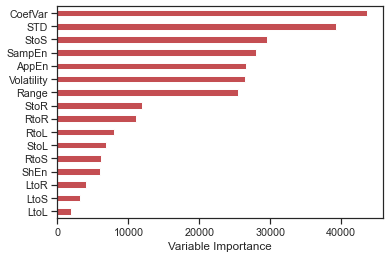

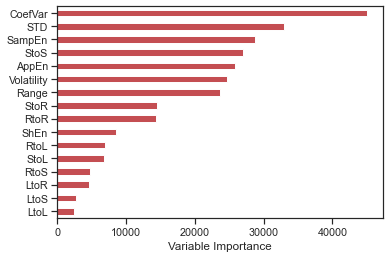

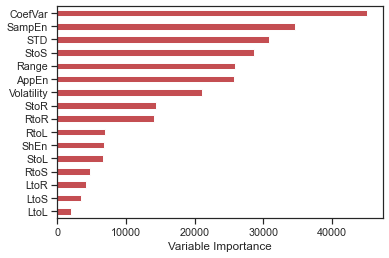

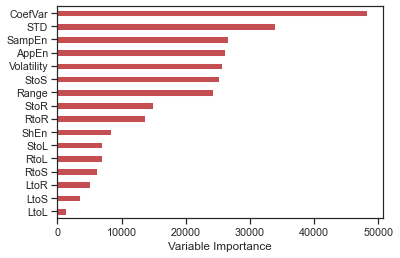

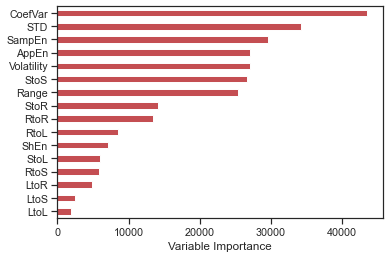

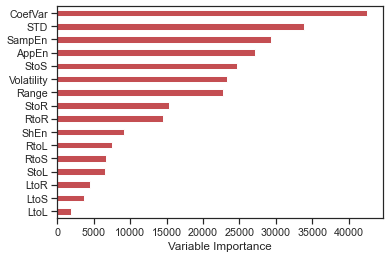

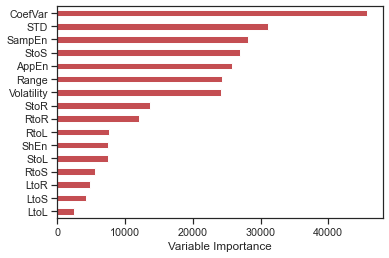

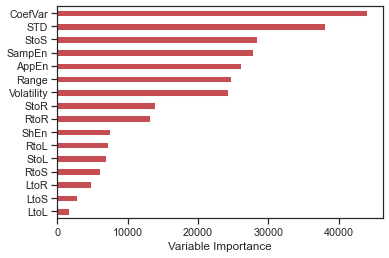

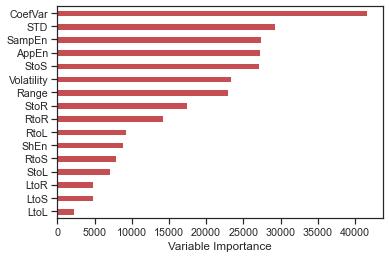

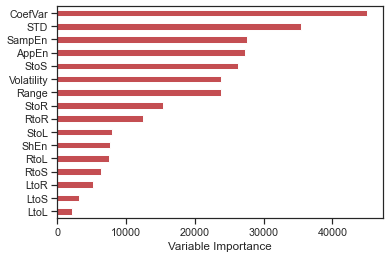

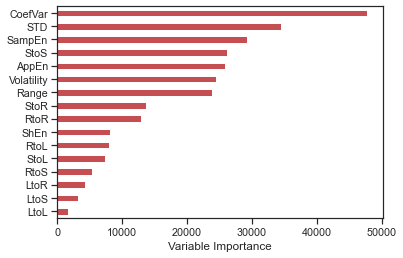

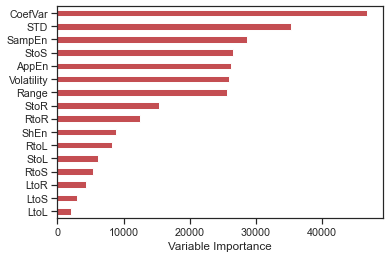

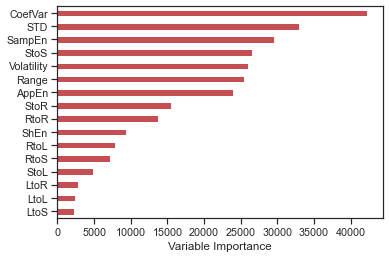

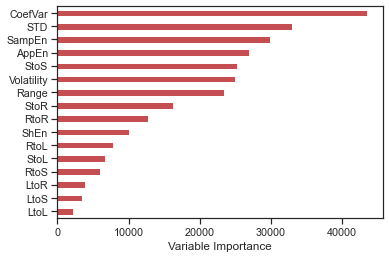

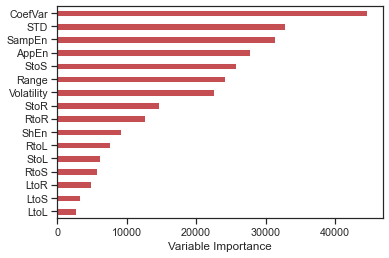

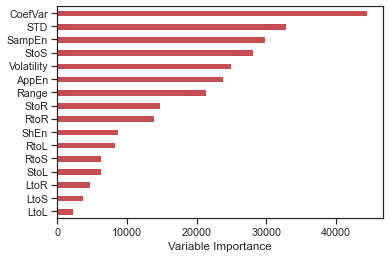

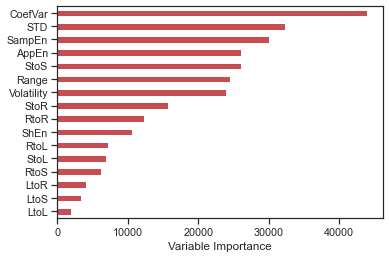

In [14]:
import lightgbm

#Implementing cross validation 
kf = KFold(n_splits=23, random_state=1, shuffle=True)


from time import time
import timeit #imports timeit module
start_time = timeit.default_timer() #defines start time so computational time can be calculated

acc_score = [];
Truth = [];
Output = [];
n_estimators_list = []
max_depth_list = []

x_values = ['StoS', 'StoR', 'StoL', 'RtoS', 'RtoR', 'RtoL', 'LtoS',
       'LtoR', 'LtoL', 'STD', 'CoefVar', 'Range', 'Volatility', 'ShEn',
       'AppEn', 'SampEn']
y_values = ['Rhythm']
df = features_maindf

for idx, subject in enumerate(good_list):
    
    train_index = ~df['Subject'].str.contains(subject)
    test_index = df['Subject'].str.contains(subject)
    X_train , X_test = df.loc[train_index,x_values], df.loc[test_index,x_values]
    y_train , y_test = df.loc[train_index,y_values].values.ravel(), df.loc[test_index,y_values]

#     temp_model = model.fit(X_train,y_train,eval_set=[(X_test,y_test),(X_train,y_train)],eval_metric='logloss')    
#     param_distributions = {'n_estimators': randint(105, 110),
#                            'max_depth': randint(7,10)}

#     search = RandomizedSearchCV(estimator=temp_model, param_distributions=param_distributions, random_state=0)
#     search.fit(X_train, y_train)

#     n_estimators_list.append(search.best_params_['n_estimators'])
#     max_depth_list.append(search.best_params_['max_depth'])

#     model.fit(X_train,y_train,eval_set=[(X_test,y_test),(X_train,y_train)],
#           eval_metric='logloss')
    model = lightgbm.LGBMClassifier(learning_rate=0.09,max_depth=5, random_state=42)
    
    # Create the LightGBM data containers
    model.fit(X_train,y_train,eval_set=[(X_test,y_test),(X_train,y_train)],
          eval_metric='logloss')

    pred_values = model.predict(X_test)
     
    acc = accuracy_score(y_test, pred_values)
    acc_score.append(acc)
    
    Truth.extend(y_test.values.reshape(y_test.shape[0])); ## it is a list
    Output.extend(pred_values); ## it is a list  
    
    #print(model.feature_importances_)
    Importance = pd.DataFrame({'Importance':(model.feature_importances_*100)}, 
                          index = (X_train.columns))
    Importance.sort_values(by = 'Importance', 
                       axis = 0, 
                       ascending = True).plot(kind = 'barh', 
                                              color = 'r')
    plt.xlabel('Variable Importance')
    plt.gca().legend_ = None
    #plt.savefig('plot1.png')


elapsed = timeit.default_timer() - start_time #gives total computation time
print("---Run time is %s seconds ---" % elapsed) #prints computation time
print()

print('Accuracy of each fold: \n {}'.format(acc_score))
print()
print('Avg accuracy : \n{}'.format(np.mean(acc_score))); 
print()
print('Std of accuracy : \n{}'.format(np.std(acc_score)))

In [15]:
print(confusion_matrix(Truth, Output))
print(classification_report(Truth, Output))
print(acc_score)
print(elapsed)

[[23043  1700]
 [ 1729 18496]]
              precision    recall  f1-score   support

           0       0.93      0.93      0.93     24743
           1       0.92      0.91      0.92     20225

    accuracy                           0.92     44968
   macro avg       0.92      0.92      0.92     44968
weighted avg       0.92      0.92      0.92     44968

[0.914187643020595, 0.9525354969574037, 0.9962216624685138, 0.9292565947242206, 0.9979101358411703, 0.954158215010142, 0.7860812704343765, 0.9979577944179714, 0.9372489959839357, 0.9691289966923925, 0.9832123411978222, 0.990667623833453, 0.8054421768707483, 0.9598726114649682, 0.577435470441299, 0.9893664155959238, 0.9917751884852639, 0.9861511829197923, 0.7502113271344041, 0.9719626168224299, 0.995295124037639, 0.9962335216572504, 0.9987315010570824]
5.280834200006211
